## Direct Marketing Optimization Using Cost sensitive Learning
by Bhanu Angam [bhn4477@gmail.com | bhanudurganath.angam@ugent.be]<br>

**SUMMARY<br>
I. <a href='#Data Exploration'>Data Exploration</a><br>
II. <a href='#Splitting Data for Train and Target sets'>Data Preparation(Train/Targets)</a><br>
III. <a href='# Feature Engineering and Data Preparation'>Feature Engineering</a><br>
IV.  <a href='# Propensity Modelling'>Propensity Modelling</a><br>
V. <a href='# Predictions on Target clients'>Predictions on Target clients</a><br>
VI. <a href='# Revenue'>Revenue</a><br>
VII. <a href='# Marketing Target'>Marketing Target and strategy</a><br>
    <a href='#Conclusion'>Conclusion</a>**
    
  ** **Other models are performed in .py files, can be found in the project repository for each model and compared the results in Technical report** **

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) # View all columns in dataframe display
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from model import *
from keras.optimizers import Adam
from tensorflow import keras
import datetime, os
import tensorflow as tf
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from numpy import mean

# Data Exploration
## Load Data

In [2]:
soc_dem = pd.read_excel('Task_Data_Scientist_Dataset.xlsx', sheet_name='Soc_Dem')
prod_accbal = pd.read_excel('Task_Data_Scientist_Dataset.xlsx', sheet_name='Products_ActBalance')
inflow_outflow = pd.read_excel('Task_Data_Scientist_Dataset.xlsx', sheet_name='Inflow_Outflow')
sales_rev = pd.read_excel('Task_Data_Scientist_Dataset.xlsx', sheet_name='Sales_Revenues')
tbls = [soc_dem, prod_accbal, inflow_outflow, sales_rev]

In [3]:
sales_rev
inflow_outflow
# prod_accbal

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12
3,667,1127.792857,1127.792857,4,4,1344.603571,1344.603571,642.857143,194.285714,249.321429,21,21,3,4,8
4,1381,571.618214,571.618214,3,3,57.071429,57.071429,10.714286,46.357143,0.000000,6,6,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,108,1175.480357,1171.326071,8,6,465.500000,465.500000,0.000000,31.607143,430.500000,10,10,0,2,7
1583,1079,281.812857,281.812857,2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0
1584,1126,283.104643,283.104643,2,2,40.285714,40.285714,0.000000,0.000000,39.285714,2,2,0,0,1
1585,134,528.711071,433.429286,3,2,403.821429,401.000000,285.714286,0.000000,0.000000,6,5,2,0,0


- There are 28 Client rows missing in the Inflow_Outflow table.
- These 28 clients have no significant products active nor the account balance Therefore these clients are ignored from the data as they bring no information and prevent bias in the modelling.

In [4]:
# Check for Duplicates
print("Duplicates: ",list(map(lambda x:x.duplicated().any(), tbls)))
# Check for size
print("No. of Clients: ", list(map(lambda x:len(x), tbls)))
# Finding the Clients with missing Inflow_Outflow data
total_clients = soc_dem['Client'].unique().tolist()
in_out_clients = inflow_outflow['Client'].unique().tolist()
missing_clients = [x for x in total_clients if x not in in_out_clients]
np.array(missing_clients)


Duplicates:  [False, False, False, False]
No. of Clients:  [1615, 1615, 1587, 969]


array([  84, 1528, 1139,  355, 1446, 1141, 1244,  305,  741, 1032,  522,
       1203, 1544,  315, 1199,  514,  799,  723, 1269,  962,  377,   58,
        334,  663,   50,  941, 1026,  833])


Check for missing values
- There are 3 missing gender values in soc_dem that are replaced with Mode (Male) 
- There are 28 missing client information in Inflow_Outflow table.


In [5]:
# Checking for missing values
# there are 3 missing gender values in soc_dem that are replaced with Node (Male) 
soc_dem.isna().sum()
soc_dem.fillna('M', inplace=True)
soc_dem.isna().sum()
# Converting the gender to binary variable
print(soc_dem['Sex'].value_counts())
soc_dem['Sex'] = soc_dem['Sex'].apply(lambda s: 1 if s=="M" else 0)

soc_dem.head()

M    859
F    756
Name: Sex, dtype: int64


,Client,Sex,Age,Tenure
0,909,1,21,27
1,1217,1,38,165
2,850,0,49,44
3,1473,1,54,34
4,1038,1,29,106


- There are Clients with 'Age' less than 'Tenure' which is impossible practically.
    - 47 customers have a Tenure higher than their Age
   
- There are also significant number of Clients with Age less than 15.  
    -  76 customers aged less than 15

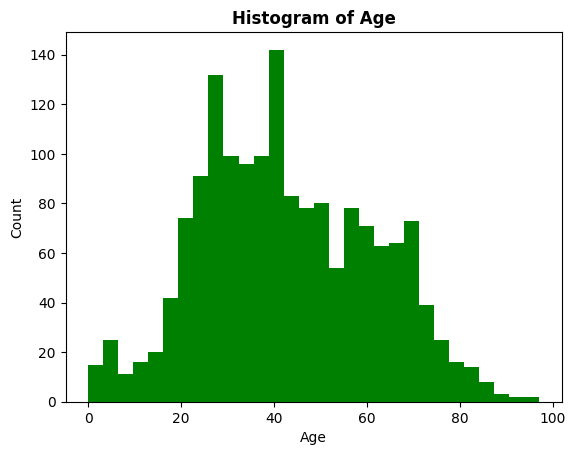

47 customers have a Tenure higher than their Age
76 customers aged less than 15


In [6]:
plt.hist(soc_dem['Age'], bins=30, histtype='bar', color='green')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age', fontweight ="bold")
plt.show()
# Age (in years) and Tenure (in months)
# Check customers who have a tenure higher than their age
print("{} customers have a Tenure higher than their Age"
      .format(len(soc_dem[soc_dem['Age'] < soc_dem['Tenure']/12])))

# Customers aged less than 15
print("{} customers aged less than 15"
      .format(len(soc_dem['Age'][soc_dem['Age'] < 15])))


## Products_ActBalance Features
- From the below correlation matrix all the independent features are least correlated between -0.35 to 0.35.

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
Client,1.000000,-0.003203,-0.004161,-0.065497,NaN,NaN,-0.002369,0.063782,-0.071675,-0.062954,0.086149,-0.129013,-0.137824
Count_CA,-0.003203,1.000000,0.017072,-0.071384,NaN,NaN,-0.017023,-0.007420,-0.016180,0.058439,-0.015916,0.086933,0.028229
Count_SA,-0.004161,0.017072,1.000000,0.040311,NaN,NaN,-0.097590,0.044101,-0.031067,0.037627,-0.036001,-0.164074,-0.197271
Count_MF,-0.065497,-0.071384,0.040311,1.000000,NaN,NaN,NaN,0.028366,0.154174,0.001381,0.084702,-0.024335,0.027880
Count_OVD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Count_CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Count_CL,-0.002369,-0.017023,-0.097590,NaN,NaN,NaN,1.000000,-0.077804,0.091109,NaN,0.201422,-0.252690,0.083053
ActBal_CA,0.063782,-0.007420,0.044101,0.028366,NaN,NaN,-0.077804,1.000000,-0.010861,0.010777,-0.037813,-0.015091,-0.053119
ActBal_SA,-0.071675,-0.016180,-0.031067,0.154174,NaN,NaN,0.091109,-0.010861,1.000000,-0.053401,-0.067888,-0.155816,-0.330615
ActBal_MF,-0.062954,0.058439,0.037627,0.001381,NaN,NaN,NaN,0.010777,-0.053401,1.000000,-0.105562,-0.171181,-0.312218


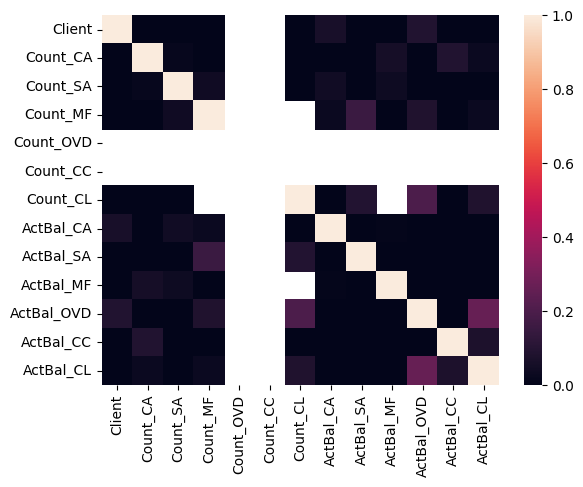

In [7]:
# print(prod_accbal)
sns.heatmap(prod_accbal.corr(), vmin=0, vmax=1)
prod_accbal.corr()
# prod_accbal[prod_accbal['Count_SA']== 1.0]

## Inflow_Outflow Features
- If we see the correlation plot that the feature pairs below are highly correlated because they are computed from same other features, so they are dependendent each other.
    - (VolumeCred, VolumeCred_CA)
    - (VolumeDeb, VolumeDeb_CA)
    - (TransactionsCred, TransactionsCred_SA)
    - (TransactionsDeb, TransactionsDeb_CA)
- The first feature in every pair(i.e. Total Volume) above is the sum of second (current account) and other features.

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
Client,1.000000,-0.022748,-0.016947,0.020671,0.014090,0.006466,0.003579,0.007841,-0.023025,0.028785,0.015582,-0.004383,-0.018591,0.029856,-0.012505
VolumeCred,-0.022748,1.000000,0.937090,0.213047,0.183878,0.853392,0.867303,0.402719,0.197889,0.661139,0.257709,0.243761,0.068836,0.166282,0.316406
VolumeCred_CA,-0.016947,0.937090,1.000000,0.205261,0.196940,0.795244,0.822232,0.495754,0.222961,0.665138,0.274631,0.272597,0.085940,0.195757,0.337042
TransactionsCred,0.020671,0.213047,0.205261,1.000000,0.947662,0.228223,0.206436,0.099935,0.264747,0.113016,0.690219,0.470851,0.250660,0.314382,0.447120
TransactionsCred_CA,0.014090,0.183878,0.196940,0.947662,1.000000,0.203141,0.193828,0.107650,0.242128,0.099206,0.648821,0.492969,0.261572,0.287904,0.439503
VolumeDeb,0.006466,0.853392,0.795244,0.228223,0.203141,1.000000,0.944994,0.284344,0.268377,0.829853,0.296911,0.286863,0.077603,0.205862,0.335275
VolumeDeb_CA,0.003579,0.867303,0.822232,0.206436,0.193828,0.944994,1.000000,0.320280,0.281033,0.838541,0.292509,0.299314,0.082525,0.207797,0.352552
VolumeDebCash_Card,0.007841,0.402719,0.495754,0.099935,0.107650,0.284344,0.320280,1.000000,0.194121,0.148398,0.247125,0.286450,0.348973,0.155097,0.204864
VolumeDebCashless_Card,-0.023025,0.197889,0.222961,0.264747,0.242128,0.268377,0.281033,0.194121,1.000000,0.198213,0.594317,0.612453,0.237026,0.703199,0.355057
VolumeDeb_PaymentOrder,0.028785,0.661139,0.665138,0.113016,0.099206,0.829853,0.838541,0.148398,0.198213,1.000000,0.203779,0.209834,0.010668,0.162034,0.297573


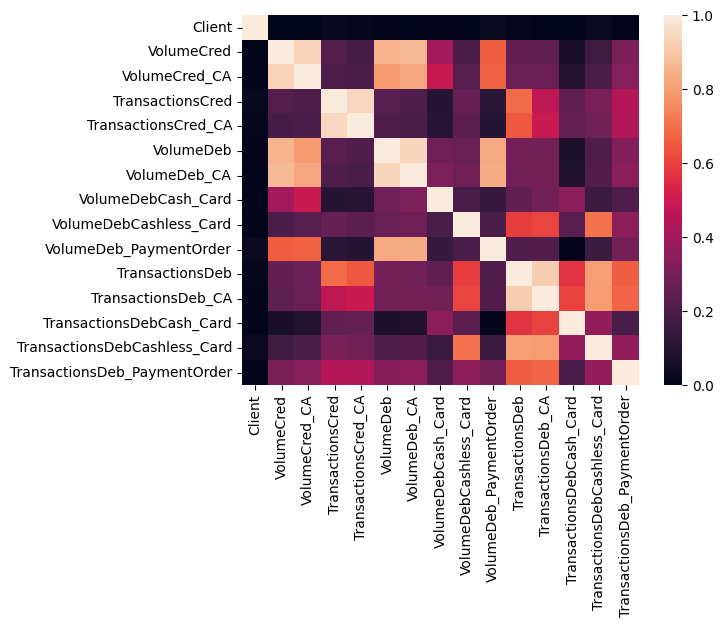

In [8]:
sns.heatmap(inflow_outflow.corr(), vmin=0, vmax=1)
inflow_outflow.corr()

- The best way to solve this is by discarding atleast one feature from those pairs.
    - Discarding VolumeCred, VolumeDeb, TransactionsCred & TransactionsDeb, as they convey no additional information.

,Client,VolumeCred_CA,TransactionsCred_CA,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
Client,1.000000,-0.016947,0.014090,0.003579,0.007841,-0.023025,0.028785,-0.004383,-0.018591,0.029856,-0.012505
VolumeCred_CA,-0.016947,1.000000,0.196940,0.822232,0.495754,0.222961,0.665138,0.272597,0.085940,0.195757,0.337042
TransactionsCred_CA,0.014090,0.196940,1.000000,0.193828,0.107650,0.242128,0.099206,0.492969,0.261572,0.287904,0.439503
VolumeDeb_CA,0.003579,0.822232,0.193828,1.000000,0.320280,0.281033,0.838541,0.299314,0.082525,0.207797,0.352552
VolumeDebCash_Card,0.007841,0.495754,0.107650,0.320280,1.000000,0.194121,0.148398,0.286450,0.348973,0.155097,0.204864
VolumeDebCashless_Card,-0.023025,0.222961,0.242128,0.281033,0.194121,1.000000,0.198213,0.612453,0.237026,0.703199,0.355057
VolumeDeb_PaymentOrder,0.028785,0.665138,0.099206,0.838541,0.148398,0.198213,1.000000,0.209834,0.010668,0.162034,0.297573
TransactionsDeb_CA,-0.004383,0.272597,0.492969,0.299314,0.286450,0.612453,0.209834,1.000000,0.608119,0.796987,0.673807
TransactionsDebCash_Card,-0.018591,0.085940,0.261572,0.082525,0.348973,0.237026,0.010668,0.608119,1.000000,0.367573,0.194726
TransactionsDebCashless_Card,0.029856,0.195757,0.287904,0.207797,0.155097,0.703199,0.162034,0.796987,0.367573,1.000000,0.367440


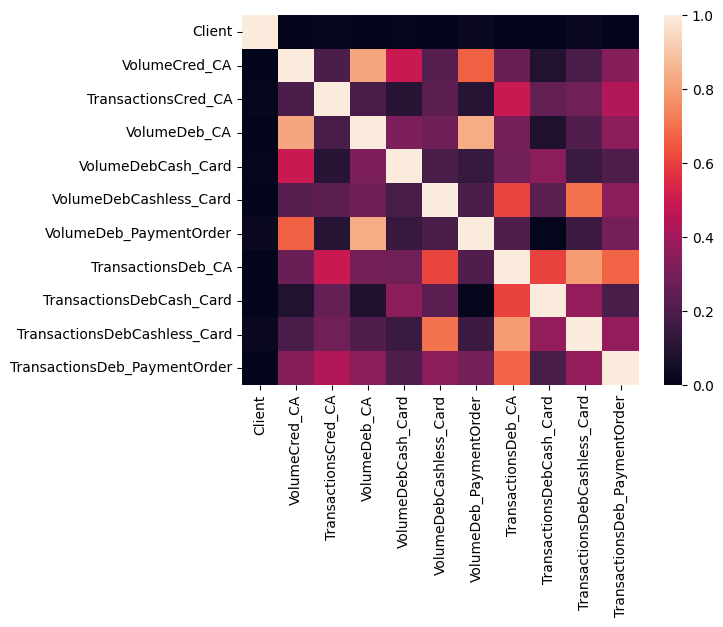

In [9]:
inflow_outflow.drop(columns=['VolumeCred', 'VolumeDeb', 'TransactionsCred', 'TransactionsDeb'], inplace=True)
sns.heatmap(inflow_outflow.corr(), vmin=0, vmax=1)
inflow_outflow.corr()

VolumeCred_CA and VolumeDeb_CA are strongly correlated (0.83). This suggests a linear relationship which can be explained by the fact that the higher the volume of credits received by a customer in his/her current account, the higher the volume of debits he/she is likely to make. 
- TransactionsDebCashless_Card and TransactionsDeb_CA have a correlation of 0.79. This is likely because the majority of debit transactions on current account are cashless debits via card.<br><br>
**There is a correlation but also a causal relation between these variables.**

We choose to : <br>
- Create **a new feature "NetCA_flow" - the net cass flow on the current account** : NetCA_flow = VolumeCred_CA - VolumeDeb_CA and **discard both features : VolumeCred_CA, VolumeDeb_CA**<br>
- **Discard the feature TransactionsDebCashless_Card** and keep only TransactionsDeb_CA.

In [10]:
inflow_outflow['netCA_flow'] = inflow_outflow['VolumeCred_CA'] - inflow_outflow['VolumeDeb_CA']
inflow_outflow.drop(columns=['VolumeCred_CA', 'VolumeDeb_CA', 'TransactionsDebCashless_Card'], inplace=True)

,Client,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,netCA_flow
Client,1.000000,0.014090,0.007841,-0.023025,0.028785,-0.004383,-0.018591,-0.012505,-0.035053
TransactionsCred_CA,0.014090,1.000000,0.107650,0.242128,0.099206,0.492969,0.261572,0.439503,0.032776
VolumeDebCash_Card,0.007841,0.107650,1.000000,0.194121,0.148398,0.286450,0.348973,0.204864,0.349246
VolumeDebCashless_Card,-0.023025,0.242128,0.194121,1.000000,0.198213,0.612453,0.237026,0.355057,-0.060900
VolumeDeb_PaymentOrder,0.028785,0.099206,0.148398,0.198213,1.000000,0.209834,0.010668,0.297573,-0.181933
TransactionsDeb_CA,-0.004383,0.492969,0.286450,0.612453,0.209834,1.000000,0.608119,0.673807,-0.003998
TransactionsDebCash_Card,-0.018591,0.261572,0.348973,0.237026,0.010668,0.608119,1.000000,0.194726,0.017575
TransactionsDeb_PaymentOrder,-0.012505,0.439503,0.204864,0.355057,0.297573,0.673807,0.194726,1.000000,0.022941
netCA_flow,-0.035053,0.032776,0.349246,-0.060900,-0.181933,-0.003998,0.017575,0.022941,1.000000


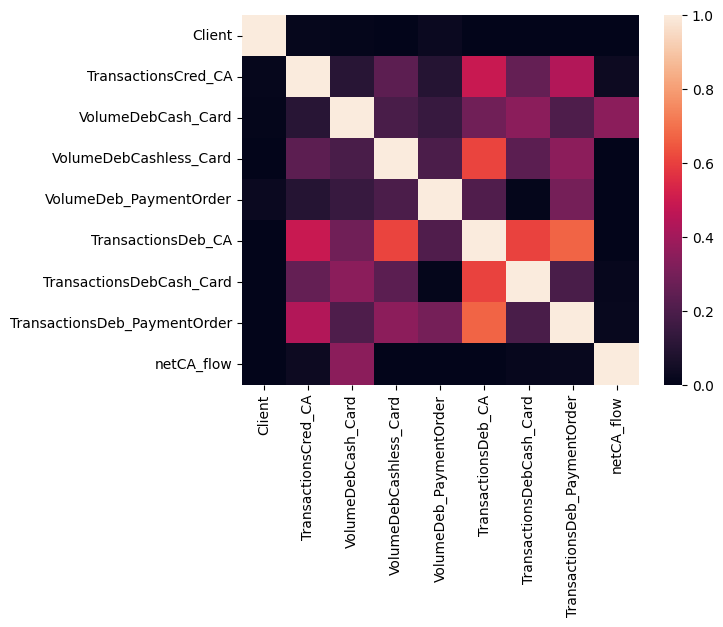

In [11]:
sns.heatmap(inflow_outflow.corr(), vmin=0, vmax=1)
inflow_outflow.corr()

  *Now all the features in the Inflow_Outflow have the essential and transformed features*

## Merged train set

In [12]:
# Merging the clients data to get total data 
total_train = inflow_outflow.merge(soc_dem, how='left', on='Client').merge(prod_accbal, how='left', on='Client').merge(sales_rev, how='left', on='Client')
total_train

,Client,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,netCA_flow,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1017,1,25.000000,91.796429,0.000000,12,2,0,-118.041429,1,57,145,1,NaN,NaN,NaN,NaN,NaN,903.638214,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000
1,1456,3,14.285714,497.444286,258.607143,28,1,5,-410.227143,0,61,149,1,1.0,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,3.607143,0.000000
2,545,14,303.571429,179.082143,1229.428571,23,3,12,281.462143,1,20,151,1,1.0,NaN,NaN,NaN,NaN,3852.053929,37045.965714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,667,4,642.857143,194.285714,249.321429,21,3,8,-216.810714,1,48,143,1,NaN,NaN,NaN,NaN,NaN,60.044286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1381,3,10.714286,46.357143,0.000000,6,1,0,514.546786,1,38,135,1,NaN,NaN,NaN,NaN,NaN,144.871429,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,108,6,0.000000,31.607143,430.500000,10,0,7,705.826071,0,39,82,1,2.0,NaN,1.0,NaN,NaN,816.838929,0.000000,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000
1583,1079,2,0.000000,0.000000,0.000000,0,0,0,281.812857,1,37,68,1,NaN,NaN,NaN,NaN,NaN,4314.886429,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.000000,4.089286
1584,1126,2,0.000000,0.000000,39.285714,2,0,1,242.818929,1,46,117,1,NaN,NaN,NaN,NaN,NaN,1969.399286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1585,134,2,285.714286,0.000000,0.000000,5,2,0,32.429286,1,32,128,1,NaN,NaN,NaN,NaN,1.0,2809.197857,NaN,NaN,NaN,NaN,7237.215357,0.0,0.0,1.0,0.0,0.000000,20.140000


# Splitting Data for Train and Target sets
- Splitting based on the presence of any Product bought that is considered as training record.
- Records with out any Product bought and therefore no Revenue created into Targets for marketing campaign.
- There are also users who didnt buy any product Therefore balnk products and Revenue in the training set


In [268]:
# Splitting based on the presence of any Product bought that is considered as training record 
train_sales = ['Sale_MF','Sale_CC','Sale_CL', 'No_sale', 'Revenue_MF','Revenue_CC','Revenue_CL']
train = total_train[~total_train['Sale_CC'].isna()]
# Records with out any Product bought and therefore no Revenue created into Targets for marketing campaign.
target = total_train[total_train['Sale_CC'].isna()]


In [14]:
train['No_sale'] = train.apply(lambda row: 1 if row['Sale_MF'] == row['Sale_CC'] == row['Sale_CL'] == 0 else 0 ,axis=1)

c:\users\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
train

,Client,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,netCA_flow,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,No_sale
0,1017,1,25.000000,91.796429,0.000000,12,2,0,-118.041429,1,57,145,1,NaN,NaN,NaN,NaN,NaN,903.638214,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000,1
1,1456,3,14.285714,497.444286,258.607143,28,1,5,-410.227143,0,61,149,1,1.0,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,3.607143,0.000000,0
4,1381,3,10.714286,46.357143,0.000000,6,1,0,514.546786,1,38,135,1,NaN,NaN,NaN,NaN,NaN,144.871429,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000,1
7,284,2,175.000000,547.982500,597.571429,20,1,7,-11.125714,1,66,23,1,NaN,NaN,NaN,NaN,NaN,2505.563571,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.893214,14.988214,0
10,486,1,0.000000,0.000000,0.000000,1,0,0,-5.470357,1,43,195,2,NaN,NaN,NaN,NaN,NaN,1815.522857,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,73,3,0.000000,0.000000,304.516429,3,0,2,-520.219286,1,87,163,1,1.0,1.0,1.0,NaN,NaN,179.357143,21.016071,53571.428571,0.0,NaN,NaN,0.0,1.0,1.0,0.0,1.785714,18.353929,0
1582,108,6,0.000000,31.607143,430.500000,10,0,7,705.826071,0,39,82,1,2.0,NaN,1.0,NaN,NaN,816.838929,0.000000,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000,1
1583,1079,2,0.000000,0.000000,0.000000,0,0,0,281.812857,1,37,68,1,NaN,NaN,NaN,NaN,NaN,4314.886429,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.000000,4.089286,0
1585,134,2,285.714286,0.000000,0.000000,5,2,0,32.429286,1,32,128,1,NaN,NaN,NaN,NaN,1.0,2809.197857,NaN,NaN,NaN,NaN,7237.215357,0.0,0.0,1.0,0.0,0.000000,20.140000,0


# Feature Engineering and Data Preparation


In [16]:
train_client = train['Client']
train_X = train.drop(columns=train_sales+['Client'])
train_Y = train[train_sales]
train_X.to_csv('data/train_X.csv', index=False)
train_Y.to_csv('data/train_Y.csv', index=False)

### Data splitting for train and test

In [17]:
Y_cc = train_Y['Sale_CC']
Y_mf = train_Y['Sale_MF']
Y_cl = train_Y['Sale_CL']
Y_no = train_Y['No_sale']


X_traincc, X_testcc, Y_traincc, Y_testcc = train_test_split(train_X.fillna(0),
                                                        Y_cc, test_size=0.2, random_state=20, stratify=Y_cc)
X_trainmf, X_testmf, Y_trainmf, Y_testmf = train_test_split(train_X.fillna(0),
                                                            Y_mf, test_size=0.2, random_state=20, stratify=Y_mf)
X_traincl, X_testcl, Y_traincl, Y_testcl = train_test_split(train_X.fillna(0),
                                                            Y_cl, test_size=0.2, random_state=20, stratify=Y_cl)
X_trainno, X_testno, Y_trainno, Y_testno = train_test_split(train_X.fillna(0),
                                                            Y_no, test_size=0.2, random_state=20, stratify=Y_no)
pd.value_counts(Y_trainno)


0    450
1    310
Name: No_sale, dtype: int64

## Feature Selection
- Feature selection is very usefull here as there are many correlated features, it helps to reduce the complexity and fit the models faster with faster convergence. It also removes ambiguity from the data to the model.
- Feature selection is made based on Embeded method combined with Wrapper meathod.
- Recursive Elemination is used with RandomForest classifier with best fit parameters 
Note: Feature Selection is to be done on the training set only in order to prevent the data leakage.

Index(['TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder',
       'netCA_flow', 'Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA'],
      dtype='object')
[0.04735932 0.05624987 0.05575872 0.06981093 0.06484769 0.04467904
 0.04580524 0.09283514 0.01554764 0.0772184  0.08816509 0.00862133
 0.01713539 0.017603   0.01640656 0.00571823 0.00514205 0.13598124
 0.08314519 0.01309356 0.01577656 0.01384335 0.00925646]


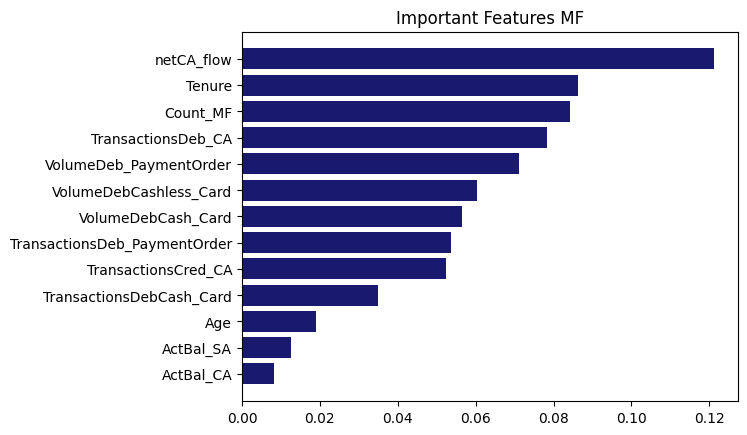

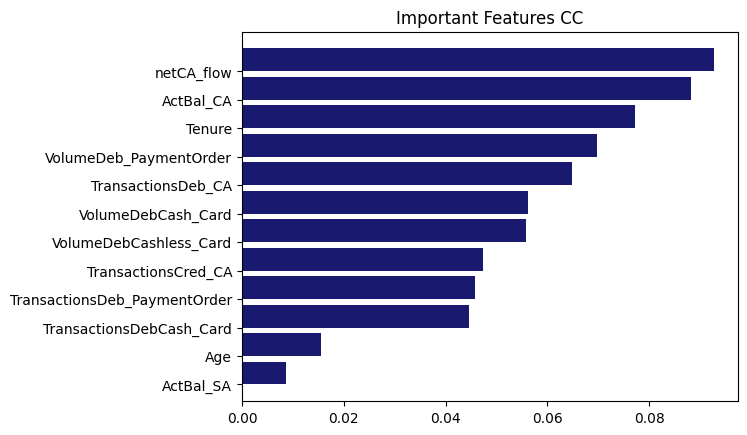

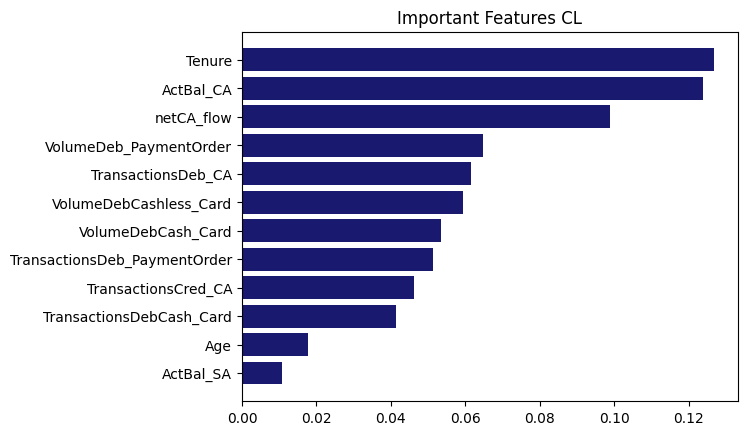

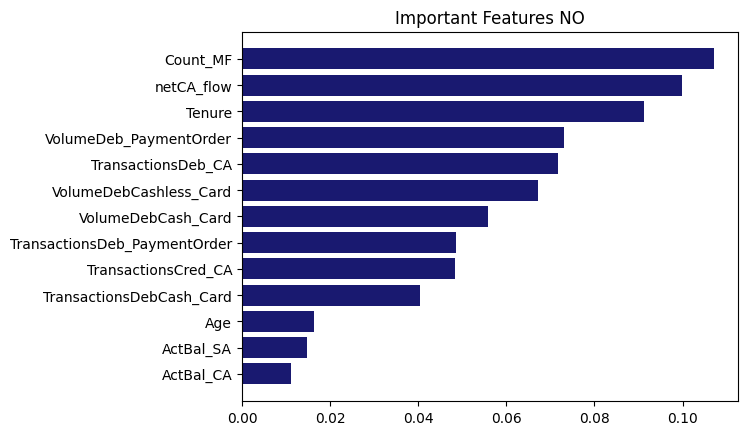

In [18]:
selCC = SelectFromModel(RandomForestClassifier(n_estimators=500),threshold=0.02)
selCC.fit(X_traincc, Y_traincc)
selMF = SelectFromModel(RandomForestClassifier(n_estimators=500), threshold=0.02)
selMF.fit(X_trainmf, Y_trainmf)
selCL = SelectFromModel(RandomForestClassifier(n_estimators=500), threshold=0.02)
selCL.fit(X_traincl, Y_traincl)
selNO = SelectFromModel(RandomForestClassifier(n_estimators=500), threshold=0.02)
selNO.fit(X_trainno, Y_trainno)

selected_featCC = X_traincc.columns[(selCC.get_support())]
selected_featMF = X_trainmf.columns[(selMF.get_support())]
selected_featCL = X_traincl.columns[(selCL.get_support())]
selected_featNO = X_trainno.columns[(selNO.get_support())]

print(selected_featNO)
print(selCC.estimator_.feature_importances_.ravel())


plt.title('Important Features MF')
f_i = list(zip(selected_featMF, selMF.estimator_.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='midnightblue', align='center')
plt.show()

plt.title('Important Features CC')
f_i = list(zip(selected_featCC, selCC.estimator_.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='midnightblue', align='edge')
plt.show()

plt.title('Important Features CL')
f_i = list(zip(selected_featCL, selCL.estimator_.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='midnightblue', align='center')
plt.show()

plt.title('Important Features NO')
f_i = list(zip(selected_featNO, selNO.estimator_.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='midnightblue', align='center')
plt.show()

featuresMF = list(selected_featMF)
featuresCC = list(selected_featCC)
featuresCL = list(selected_featCL)
featuresNO = list(selected_featNO)


In [19]:
print(featuresMF)
print(featuresCC)
print(featuresCL)
print(featuresNO)

['TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder', 'netCA_flow', 'Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA']
['TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder', 'netCA_flow', 'Age', 'Tenure', 'ActBal_CA', 'ActBal_SA']
['TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder', 'netCA_flow', 'Age', 'Tenure', 'ActBal_CA', 'ActBal_SA']
['TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder', 'netCA_flow', 'Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA']


### Standardizing Numerical features
- The features are with different scales that makes the modelling difficult and create bias in the creating weights in the model. Therefore the numerical variables are standardised that helps for the faster convergence and weights adjustments during back propogation.

In [20]:
features_to_normalize = ['netCA_flow', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'TransactionsDebCash_Card',
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA', 'TransactionsCred_CA', 'TransactionsDeb_PaymentOrder',
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'Age', 'Tenure', 'TransactionsDeb_CA']
X_traincc[features_to_normalize] = StandardScaler().fit_transform(X_traincc[features_to_normalize])
X_testcc[features_to_normalize] = StandardScaler().fit_transform(X_testcc[features_to_normalize])

X_trainmf[features_to_normalize] = StandardScaler().fit_transform(X_trainmf[features_to_normalize])
X_testmf[features_to_normalize] = StandardScaler().fit_transform(X_testmf[features_to_normalize])

X_traincl[features_to_normalize] = StandardScaler().fit_transform(X_traincl[features_to_normalize])
X_testcl[features_to_normalize] = StandardScaler().fit_transform(X_testcl[features_to_normalize])

X_trainno[features_to_normalize] = StandardScaler().fit_transform(X_trainno[features_to_normalize])
X_testno[features_to_normalize] = StandardScaler().fit_transform(X_testno[features_to_normalize])


In [21]:
X_testcc

,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,netCA_flow,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
199,-0.313317,-0.200165,-0.518123,-0.249037,-0.771303,-0.714870,-0.950569,-0.070017,1,-0.893637,-1.481091,1,0.0,0.0,0.0,0.0,0.0,-0.392940,-0.246367,-0.099502,-0.270278,-0.210970,-0.208718
260,-0.499746,0.259892,-0.518123,-0.192256,-0.572581,-0.050441,-0.371126,-0.037211,1,-0.945032,-0.407951,1,0.0,0.0,1.0,0.0,0.0,0.239142,-0.246367,-0.099502,-0.270278,-0.210970,-0.208718
287,-0.499746,-0.087242,-0.518123,-0.222817,-0.506341,0.281774,-0.371126,0.003835,0,0.391252,0.679691,1,1.0,0.0,0.0,0.0,0.0,-0.320654,-0.046831,-0.099502,-0.270278,-0.210970,-0.208718
661,-0.499746,-0.200165,-0.518123,-0.245143,-0.771303,-0.714870,-0.564274,0.003877,0,0.596834,1.216260,1,3.0,0.0,0.0,1.0,0.0,-0.436744,0.071326,-0.099502,-0.270278,-0.018188,-0.208718
1275,-0.499746,-0.137430,0.349710,-0.129600,0.089823,-0.050441,-0.177979,0.006655,1,-0.842241,-1.118544,1,1.0,0.0,0.0,1.0,0.0,-0.410571,-0.246367,-0.099502,-0.270278,-0.195285,-0.208718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.126889,-0.164615,0.306765,-0.219134,-0.307619,-0.050441,-0.177979,0.004547,0,-0.893637,0.215630,1,0.0,0.0,0.0,0.0,0.0,-0.435719,-0.246367,-0.099502,-0.270278,-0.210970,-0.208718
419,-0.499746,0.040319,-0.061029,-0.245924,0.354785,1.278417,-0.757422,-0.043549,0,1.624745,-0.741494,1,1.0,0.0,0.0,1.0,0.0,3.582881,3.002195,-0.099502,-0.270278,2.133801,-0.208718
784,2.296682,-0.053783,0.475439,-0.142578,0.818469,1.610632,0.208316,-0.014001,1,1.059394,-0.016400,2,0.0,0.0,1.0,1.0,0.0,-0.421301,-0.246367,-0.099502,-0.270278,6.801256,-0.208718
1544,-0.313317,-0.200165,-0.518123,-0.233173,-0.771303,-0.714870,-0.564274,0.012300,0,1.213581,-1.350574,1,0.0,0.0,0.0,0.0,0.0,-0.412299,-0.246367,-0.099502,-0.270278,-0.210970,-0.208718


In [22]:
pca = PCA(n_components = 'mle')
# pca.fit(train_X.fillna(0))
Xt = pca.fit(X_trainno).transform(X_trainno)

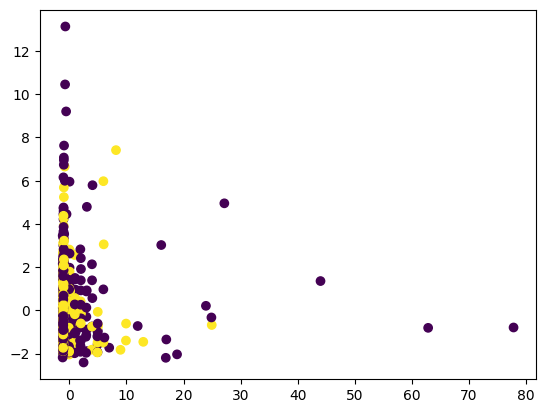

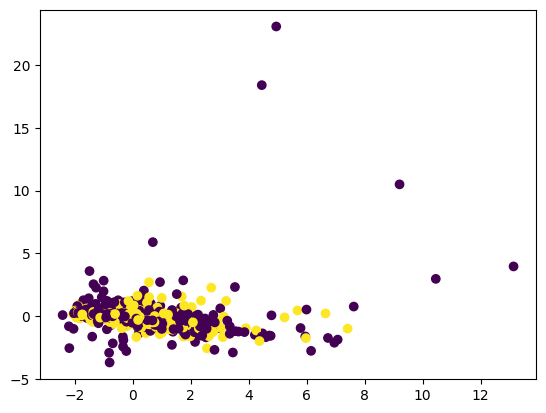

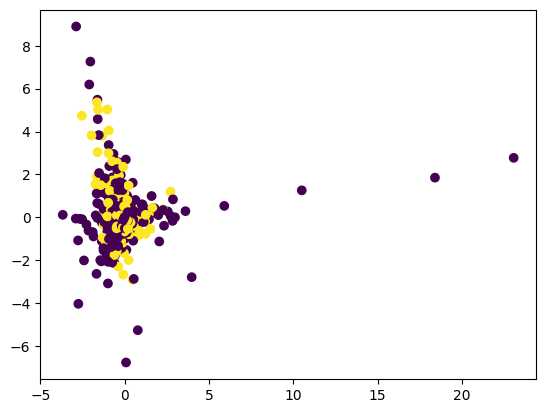

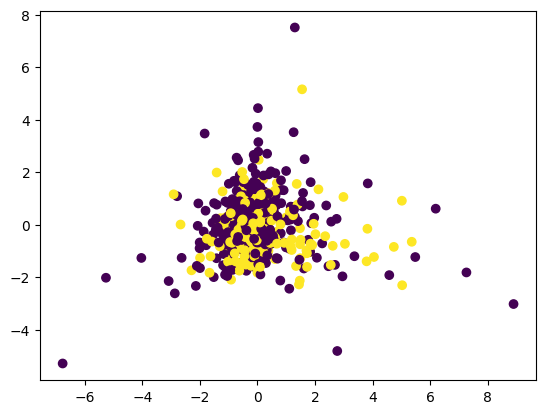

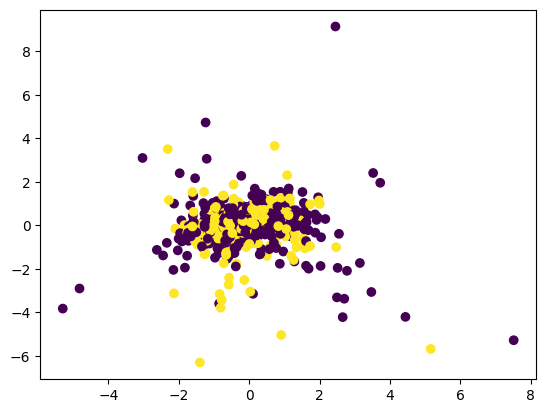

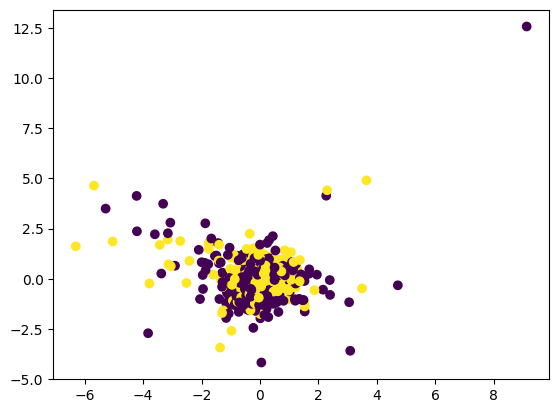

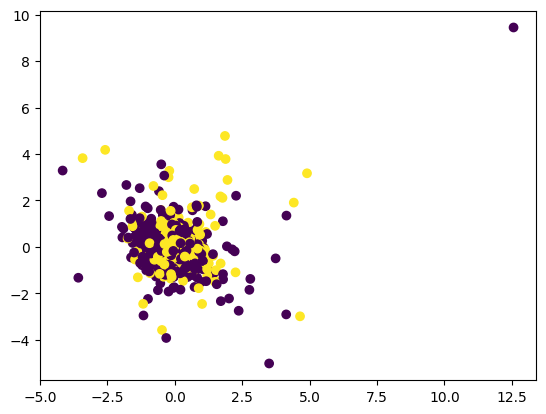

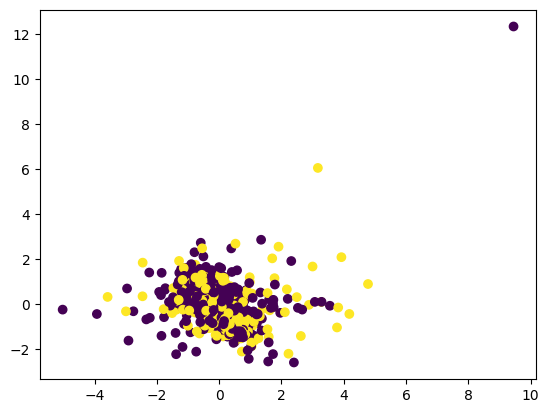

In [23]:
for i in range(1,9):
    plot = plt.scatter(Xt[:,i-1], Xt[:,i], c=Y_trainno)
    plt.show()

explained variance ratio (first two components): [0.58002814 0.07961156 0.04713701 0.0315598  0.02756817 0.02578367
 0.02554115 0.02406646 0.02346411 0.02289761 0.02069458 0.01882542
 0.01630708 0.01353779 0.01318652 0.00702809 0.00610557 0.00552369
 0.00315135 0.00278221 0.0025687  0.00154275]


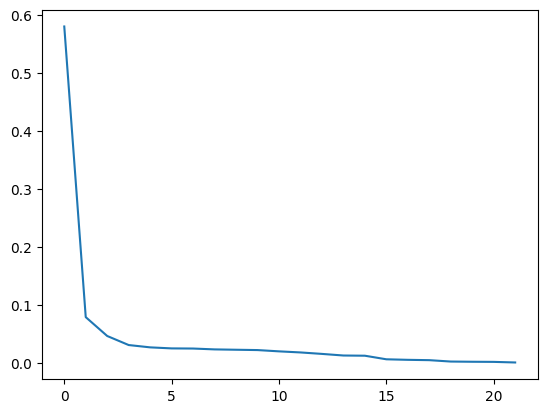

In [24]:
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)
plt.plot(pca.explained_variance_ratio_)



# Propensity Modelling

## Model for Credit Card Propensities
 ### Cost Sensitive Learning
Correct classifications have a cost of zero, that is, $c_{00}=c_{11}=0$. Misclassification costs are however in practice difficult to estimate.Prediction of potential customers as non potential (false negative) involves a loss directly related to the amount of the Revenues, but also on further strategies and loss of resources, and on the company reputation. At the same time, identifying non potential customer as potential (false positive) causes inconvenience to customers, generates useless investigation costs, and also impacts the company reputation.  

In cost-sensitive imbalanced problems, the most popular heuristic approach to estimate the costs lies in utilizing the imbalance ratio (IR). Let us denote by $\mathcal{X}$ the imbalanced dataset, with $\mathcal{X}_0$ and $\mathcal{X}_1$ being the subsets of samples belonging to the majority and minority class, respectively. The IR of the dataset $\mathcal{X}$ is defined as {cite}`JMLR:v18:16-365`:

$$
IR=\frac{|\mathcal{X}_1|}{|\mathcal{X}_0|}
$$

where $|·|$ denotes the cardinality of a set. In this setting, $C(i,j) = IR$ and $C(j,i) = 1$, where the minority class is the i-th class, and the majority class is the j-th class. It is worth noting that using the IR as the cost for the majority class balances the overall cost of the two classes, that is, $|\mathcal{X}_1|=IR*|\mathcal{X}_0|$. The resulting cost matrix for a 2-class problem is given below.

Using the IR to set the misclassification costs is usually a good heuristic. It however has some limitations, in particular related to small sample size, class overlapping, and noisy or borderline instances {cite}`fernandez2018learning`. A common complementary practice consists in considering the misclassification costs as a hyperparameter to be identified through model selection. 

Python sklearn provides support for cost-sensitive learning for most baseline classifiers thanks to the `class_weight` parameter. The parameter allows to specify costs in three different ways:

* `None`: The misclassification costs are set to 1 (default)
* `balanced`: The costs are set according to the imbalance ratio (as in Fig. below)
* `{0:c10, 1:c01}`: The misclassification costs are explicitly set for the two classes by means of a dictionary.

The use of class weights usually implies a modification in the loss function of the learning algorithm. The modification depends on the type of algorithm. By strongly penalizing mistakes on the minority class, cost-sensitive learning improves their importance during the classifier training step. This pushes the decision boundary away from these instances, allowing to improve generalization on the minority class {cite}`fernandez2018learning,gupta2020class`.

In [25]:

X_traincc = X_traincc[featuresCC].to_numpy()
X_testcc = X_testcc[featuresCC].to_numpy()
# X_traincc = X_train
# X_testcc = X_test
X_traincc.shape

(760, 12)

### Outliers removal

In [455]:
# from sklearn.ensemble import IsolationForest
# # identify outliers in the training dataset
# iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(X_traincc_f)
# pd.value_counts(yhat)
# # select all rows that are not outliers
# mask = yhat != -1
# # train_X[mask]
# X_traincc_f, Y_traincc_f = X_traincc_f[mask], Y_traincc_f[mask]

print(pd.value_counts(Y_trainmf))
neg, pos = pd.value_counts(train.Sale_CL).to_numpy()
total = neg + pos
print('Clients:\n    Total: {}\n    Negatives: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, neg, pos, 100 * pos / total))

0.0    605
1.0    363
Name: Sale_MF, dtype: int64
Clients:
    Total: 951
    Negatives: 662
    Positive: 289 (30.39% of total)



### Over-Sampling

In [27]:
# # Over-Sampling
# over = SMOTE(sampling_strategy=0.6)
# under = RandomUnderSampler(sampling_strategy=0.6)
# # X_traincc, Y_traincc = over.fit_resample(X_traincc, Y_traincc)
# X_traincc, Y_traincc = over.fit_resample(X_traincc, Y_traincc)

# X = X_train
# y = Y_cc_train
print(pd.value_counts(Y_traincc))

0.0    571
1.0    189
Name: Sale_CC, dtype: int64


In [28]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weightcc = {0: weight_for_0, 1: weight_for_1/1.35}
class_weightcc

{0: 0.6654991243432574, 1: 1.489320007838526}

In [42]:
Metrics = [
    f1_loss,
    f1_weighted,
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
    tfa.losses.WeightedKappaLoss(num_classes=1, name='cohen_kappa'),
    tfa.losses.SigmoidFocalCrossEntropy(name='sfc')
]
def make_modelcc(input_shape, metrics=Metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential(
        [keras.layers.Dense(12, activation='relu', input_shape=(input_shape,), kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001)),
         keras.layers.Dropout(0.2),
#          keras.layers.Dense(15, activation='relu'),
#          keras.layers.Dropout(0.2),
#          keras.layers.Dense(8, activation='relu'),
         keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
         ])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=5e-4,
        decay_steps=10000,
        decay_rate=0.9)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [51]:
tf.random.set_seed(1234)
# Split the data
x_traincc, x_validcc, y_traincc, y_validcc = train_test_split(X_traincc, Y_traincc,
                                                              random_state=20, test_size=0.2,
                                                              shuffle= True, stratify=Y_traincc)
# Load model from py file
modelcc = make_modelcc(x_traincc.shape[1])
checkpoint = keras.callbacks.ModelCheckpoint('model4.h5', verbose=1, save_best_only=True)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [keras.callbacks.EarlyStopping(patience=120, verbose=1, monitor='val_f1_loss'), checkpoint]

# Compile model
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
print(modelcc.summary())



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 dropout_2 (Dropout)         (None, 12)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 13        
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
resultscc = modelcc.fit(x_traincc, y_traincc,
                    validation_data=(x_validcc, y_validcc), batch_size=30,
                    epochs=1000, callbacks=callbacks, class_weight=class_weightcc)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/21 [>.............................] - ETA: 24s - loss: 1.1409 - f1_loss: 0.8397 - f1_weighted: 0.8397 - tp: 14.0000 - fp: 32.0000 - tn: 108.0000 - fn: 28.0000 - accuracy: 0.6703 - precision: 0.3043 - recall: 0.3333 - auc: 0.5647 - prc: 0.3153 - cohen_kappa: -13.8155 - sfc: 0.6835WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_functio

Epoch 8/1000
 1/21 [>.............................] - ETA: 0s - loss: 1.0508 - f1_loss: 0.5956 - f1_weighted: 0.5956 - tp: 6.0000 - fp: 14.0000 - tn: 7.0000 - fn: 3.0000 - accuracy: 0.4333 - precision: 0.3000 - recall: 0.6667 - auc: 0.4868 - prc: 0.2759 - cohen_kappa: -13.8155 - sfc: 0.5394
Epoch 8: val_loss improved from 1.26150 to 1.25482, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 1.2635 - f1_loss: 0.6894 - f1_weighted: 0.6894 - tp: 102.0000 - fp: 341.0000 - tn: 116.0000 - fn: 49.0000 - accuracy: 0.3586 - precision: 0.2302 - recall: 0.6755 - auc: 0.4461 - prc: 0.2297 - cohen_kappa: -13.8155 - sfc: 0.5868 - val_loss: 1.2548 - val_f1_loss: 0.7270 - val_f1_weighted: 0.7270 - val_tp: 26.0000 - val_fp: 83.0000 - val_tn: 31.0000 - val_fn: 12.0000 - val_accuracy: 0.3750 - val_precision: 0.2385 - val_recall: 0.6842 - val_auc: 0.4520 - val_prc: 0.2250 - val_cohen_kappa: -13.8155 - val_sfc: 0.4959
Epoch 9/1000
 1/21 [>.............................] 

Epoch 17/1000
 1/21 [>.............................] - ETA: 0s - loss: 1.0524 - f1_loss: 0.7693 - f1_weighted: 0.7693 - tp: 3.0000 - fp: 18.0000 - tn: 7.0000 - fn: 2.0000 - accuracy: 0.3333 - precision: 0.1429 - recall: 0.6000 - auc: 0.4000 - prc: 0.1316 - cohen_kappa: -13.8155 - sfc: 0.6459
Epoch 17: val_loss improved from 1.20252 to 1.19628, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 1.1614 - f1_loss: 0.6726 - f1_weighted: 0.6726 - tp: 97.0000 - fp: 336.0000 - tn: 121.0000 - fn: 54.0000 - accuracy: 0.3586 - precision: 0.2240 - recall: 0.6424 - auc: 0.4546 - prc: 0.2457 - cohen_kappa: -13.8155 - sfc: 0.5365 - val_loss: 1.1963 - val_f1_loss: 0.7277 - val_f1_weighted: 0.7277 - val_tp: 26.0000 - val_fp: 83.0000 - val_tn: 31.0000 - val_fn: 12.0000 - val_accuracy: 0.3750 - val_precision: 0.2385 - val_recall: 0.6842 - val_auc: 0.4533 - val_prc: 0.2255 - val_cohen_kappa: -13.8155 - val_sfc: 0.4537
Epoch 18/1000
 1/21 [>.............................

Epoch 26/1000
 1/21 [>.............................] - ETA: 0s - loss: 1.1148 - f1_loss: 0.5409 - f1_weighted: 0.5409 - tp: 9.0000 - fp: 16.0000 - tn: 2.0000 - fn: 3.0000 - accuracy: 0.3667 - precision: 0.3600 - recall: 0.7500 - auc: 0.4028 - prc: 0.3696 - cohen_kappa: -13.8155 - sfc: 0.4979
Epoch 26: val_loss improved from 1.14879 to 1.14311, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 1.1345 - f1_loss: 0.6964 - f1_weighted: 0.6964 - tp: 96.0000 - fp: 333.0000 - tn: 124.0000 - fn: 55.0000 - accuracy: 0.3618 - precision: 0.2238 - recall: 0.6358 - auc: 0.4503 - prc: 0.2482 - cohen_kappa: -13.8155 - sfc: 0.4883 - val_loss: 1.1431 - val_f1_loss: 0.7284 - val_f1_weighted: 0.7284 - val_tp: 25.0000 - val_fp: 83.0000 - val_tn: 31.0000 - val_fn: 13.0000 - val_accuracy: 0.3684 - val_precision: 0.2315 - val_recall: 0.6579 - val_auc: 0.4544 - val_prc: 0.2260 - val_cohen_kappa: -13.8155 - val_sfc: 0.4151
Epoch 27/1000
 1/21 [>.............................

Epoch 35/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7876 - f1_loss: 0.5664 - f1_weighted: 0.5664 - tp: 7.0000 - fp: 14.0000 - tn: 6.0000 - fn: 3.0000 - accuracy: 0.4333 - precision: 0.3333 - recall: 0.7000 - auc: 0.5650 - prc: 0.4276 - cohen_kappa: -13.8155 - sfc: 0.2910
Epoch 35: val_loss improved from 1.10327 to 1.09910, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 1.0577 - f1_loss: 0.6815 - f1_weighted: 0.6815 - tp: 93.0000 - fp: 327.0000 - tn: 130.0000 - fn: 58.0000 - accuracy: 0.3668 - precision: 0.2214 - recall: 0.6159 - auc: 0.4397 - prc: 0.2573 - cohen_kappa: -13.8155 - sfc: 0.4627 - val_loss: 1.0991 - val_f1_loss: 0.7290 - val_f1_weighted: 0.7290 - val_tp: 25.0000 - val_fp: 82.0000 - val_tn: 32.0000 - val_fn: 13.0000 - val_accuracy: 0.3750 - val_precision: 0.2336 - val_recall: 0.6579 - val_auc: 0.4529 - val_prc: 0.2252 - val_cohen_kappa: -13.8155 - val_sfc: 0.3834
Epoch 36/1000
 1/21 [>.............................

Epoch 44/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.8601 - f1_loss: 0.6251 - f1_weighted: 0.6251 - tp: 8.0000 - fp: 17.0000 - tn: 4.0000 - fn: 1.0000 - accuracy: 0.4000 - precision: 0.3200 - recall: 0.8889 - auc: 0.3228 - prc: 0.2168 - cohen_kappa: -13.8155 - sfc: 0.4281
Epoch 44: val_loss improved from 1.06255 to 1.05812, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 1.0632 - f1_loss: 0.6971 - f1_weighted: 0.6971 - tp: 91.0000 - fp: 322.0000 - tn: 135.0000 - fn: 60.0000 - accuracy: 0.3717 - precision: 0.2203 - recall: 0.6026 - auc: 0.4500 - prc: 0.2426 - cohen_kappa: -13.8155 - sfc: 0.4372 - val_loss: 1.0581 - val_f1_loss: 0.7292 - val_f1_weighted: 0.7292 - val_tp: 25.0000 - val_fp: 80.0000 - val_tn: 34.0000 - val_fn: 13.0000 - val_accuracy: 0.3882 - val_precision: 0.2381 - val_recall: 0.6579 - val_auc: 0.4529 - val_prc: 0.2248 - val_cohen_kappa: -13.8155 - val_sfc: 0.3551
Epoch 45/1000
 1/21 [>.............................

Epoch 53/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7503 - f1_loss: 0.5683 - f1_weighted: 0.5683 - tp: 6.0000 - fp: 13.0000 - tn: 8.0000 - fn: 3.0000 - accuracy: 0.4667 - precision: 0.3158 - recall: 0.6667 - auc: 0.5926 - prc: 0.4048 - cohen_kappa: -13.8155 - sfc: 0.3296
Epoch 53: val_loss improved from 1.02521 to 1.02101, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.9777 - f1_loss: 0.6737 - f1_weighted: 0.6737 - tp: 96.0000 - fp: 323.0000 - tn: 134.0000 - fn: 55.0000 - accuracy: 0.3783 - precision: 0.2291 - recall: 0.6358 - auc: 0.4690 - prc: 0.2457 - cohen_kappa: -13.8155 - sfc: 0.4130 - val_loss: 1.0210 - val_f1_loss: 0.7296 - val_f1_weighted: 0.7296 - val_tp: 24.0000 - val_fp: 79.0000 - val_tn: 35.0000 - val_fn: 14.0000 - val_accuracy: 0.3882 - val_precision: 0.2330 - val_recall: 0.6316 - val_auc: 0.4534 - val_prc: 0.2260 - val_cohen_kappa: -13.8155 - val_sfc: 0.3294
Epoch 54/1000
 1/21 [>.............................

Epoch 62/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7083 - f1_loss: 0.7985 - f1_weighted: 0.7985 - tp: 3.0000 - fp: 16.0000 - tn: 11.0000 - fn: 0.0000e+00 - accuracy: 0.4667 - precision: 0.1579 - recall: 1.0000 - auc: 0.5802 - prc: 0.1091 - cohen_kappa: -13.8155 - sfc: 0.4384
Epoch 62: val_loss improved from 0.98900 to 0.98522, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 1.0304 - f1_loss: 0.6863 - f1_weighted: 0.6863 - tp: 92.0000 - fp: 307.0000 - tn: 150.0000 - fn: 59.0000 - accuracy: 0.3980 - precision: 0.2306 - recall: 0.6093 - auc: 0.4385 - prc: 0.2155 - cohen_kappa: -13.8155 - sfc: 0.4111 - val_loss: 0.9852 - val_f1_loss: 0.7298 - val_f1_weighted: 0.7298 - val_tp: 24.0000 - val_fp: 78.0000 - val_tn: 36.0000 - val_fn: 14.0000 - val_accuracy: 0.3947 - val_precision: 0.2353 - val_recall: 0.6316 - val_auc: 0.4528 - val_prc: 0.2264 - val_cohen_kappa: -13.8155 - val_sfc: 0.3052
Epoch 63/1000
 1/21 [>........................

Epoch 71/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.9414 - f1_loss: 0.5567 - f1_weighted: 0.5567 - tp: 7.0000 - fp: 14.0000 - tn: 6.0000 - fn: 3.0000 - accuracy: 0.4333 - precision: 0.3333 - recall: 0.7000 - auc: 0.5900 - prc: 0.6061 - cohen_kappa: -13.8155 - sfc: 0.3116
Epoch 71: val_loss improved from 0.95954 to 0.95644, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.8785 - f1_loss: 0.6719 - f1_weighted: 0.6719 - tp: 97.0000 - fp: 302.0000 - tn: 155.0000 - fn: 54.0000 - accuracy: 0.4145 - precision: 0.2431 - recall: 0.6424 - auc: 0.4847 - prc: 0.2626 - cohen_kappa: -13.8155 - sfc: 0.3530 - val_loss: 0.9564 - val_f1_loss: 0.7296 - val_f1_weighted: 0.7296 - val_tp: 24.0000 - val_fp: 78.0000 - val_tn: 36.0000 - val_fn: 14.0000 - val_accuracy: 0.3947 - val_precision: 0.2353 - val_recall: 0.6316 - val_auc: 0.4508 - val_prc: 0.2272 - val_cohen_kappa: -13.8155 - val_sfc: 0.2862
Epoch 72/1000
 1/21 [>.............................

Epoch 80/1000
 1/21 [>.............................] - ETA: 0s - loss: 1.2064 - f1_loss: 0.6780 - f1_weighted: 0.6780 - tp: 4.0000 - fp: 13.0000 - tn: 9.0000 - fn: 4.0000 - accuracy: 0.4333 - precision: 0.2353 - recall: 0.5000 - auc: 0.4631 - prc: 0.3432 - cohen_kappa: -13.8155 - sfc: 0.4005
Epoch 80: val_loss improved from 0.93252 to 0.92951, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.8534 - f1_loss: 0.6746 - f1_weighted: 0.6746 - tp: 91.0000 - fp: 286.0000 - tn: 171.0000 - fn: 60.0000 - accuracy: 0.4309 - precision: 0.2414 - recall: 0.6026 - auc: 0.4786 - prc: 0.2535 - cohen_kappa: -13.8155 - sfc: 0.3237 - val_loss: 0.9295 - val_f1_loss: 0.7293 - val_f1_weighted: 0.7293 - val_tp: 24.0000 - val_fp: 76.0000 - val_tn: 38.0000 - val_fn: 14.0000 - val_accuracy: 0.4079 - val_precision: 0.2400 - val_recall: 0.6316 - val_auc: 0.4527 - val_prc: 0.2291 - val_cohen_kappa: -13.8155 - val_sfc: 0.2686
Epoch 81/1000
 1/21 [>.............................

Epoch 89/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.9149 - f1_loss: 0.8480 - f1_weighted: 0.8480 - tp: 1.0000 - fp: 17.0000 - tn: 8.0000 - fn: 4.0000 - accuracy: 0.3000 - precision: 0.0556 - recall: 0.2000 - auc: 0.1760 - prc: 0.1000 - cohen_kappa: -13.8155 - sfc: 0.3511
Epoch 89: val_loss improved from 0.90811 to 0.90520, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.8741 - f1_loss: 0.6755 - f1_weighted: 0.6755 - tp: 91.0000 - fp: 315.0000 - tn: 142.0000 - fn: 60.0000 - accuracy: 0.3832 - precision: 0.2241 - recall: 0.6026 - auc: 0.4648 - prc: 0.2420 - cohen_kappa: -13.8155 - sfc: 0.3289 - val_loss: 0.9052 - val_f1_loss: 0.7288 - val_f1_weighted: 0.7288 - val_tp: 23.0000 - val_fp: 76.0000 - val_tn: 38.0000 - val_fn: 15.0000 - val_accuracy: 0.4013 - val_precision: 0.2323 - val_recall: 0.6053 - val_auc: 0.4523 - val_prc: 0.2313 - val_cohen_kappa: -13.8155 - val_sfc: 0.2532
Epoch 90/1000
 1/21 [>.............................

Epoch 98/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6406 - f1_loss: 0.6343 - f1_weighted: 0.6343 - tp: 5.0000 - fp: 13.0000 - tn: 10.0000 - fn: 2.0000 - accuracy: 0.5000 - precision: 0.2778 - recall: 0.7143 - auc: 0.5870 - prc: 0.2692 - cohen_kappa: -13.8155 - sfc: 0.2471
Epoch 98: val_loss improved from 0.88508 to 0.88291, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.8270 - f1_loss: 0.6624 - f1_weighted: 0.6624 - tp: 97.0000 - fp: 278.0000 - tn: 179.0000 - fn: 54.0000 - accuracy: 0.4539 - precision: 0.2587 - recall: 0.6424 - auc: 0.5027 - prc: 0.2677 - cohen_kappa: -13.8155 - sfc: 0.2846 - val_loss: 0.8829 - val_f1_loss: 0.7277 - val_f1_weighted: 0.7277 - val_tp: 23.0000 - val_fp: 75.0000 - val_tn: 39.0000 - val_fn: 15.0000 - val_accuracy: 0.4079 - val_precision: 0.2347 - val_recall: 0.6053 - val_auc: 0.4567 - val_prc: 0.2391 - val_cohen_kappa: -13.8155 - val_sfc: 0.2399
Epoch 99/1000
 1/21 [>............................

Epoch 107/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.8335 - f1_loss: 0.6704 - f1_weighted: 0.6704 - tp: 5.0000 - fp: 18.0000 - tn: 6.0000 - fn: 1.0000 - accuracy: 0.3667 - precision: 0.2174 - recall: 0.8333 - auc: 0.6562 - prc: 0.4016 - cohen_kappa: -13.8155 - sfc: 0.3579
Epoch 107: val_loss improved from 0.86513 to 0.86264, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.8650 - f1_loss: 0.6821 - f1_weighted: 0.6821 - tp: 91.0000 - fp: 295.0000 - tn: 162.0000 - fn: 60.0000 - accuracy: 0.4161 - precision: 0.2358 - recall: 0.6026 - auc: 0.4751 - prc: 0.2642 - cohen_kappa: -13.8155 - sfc: 0.2989 - val_loss: 0.8626 - val_f1_loss: 0.7265 - val_f1_weighted: 0.7265 - val_tp: 23.0000 - val_fp: 73.0000 - val_tn: 41.0000 - val_fn: 15.0000 - val_accuracy: 0.4211 - val_precision: 0.2396 - val_recall: 0.6053 - val_auc: 0.4647 - val_prc: 0.2368 - val_cohen_kappa: -13.8155 - val_sfc: 0.2278
Epoch 108/1000
 1/21 [>..........................

Epoch 116/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6042 - f1_loss: 0.5468 - f1_weighted: 0.5468 - tp: 6.0000 - fp: 11.0000 - tn: 10.0000 - fn: 3.0000 - accuracy: 0.5333 - precision: 0.3529 - recall: 0.6667 - auc: 0.6825 - prc: 0.6131 - cohen_kappa: -13.8155 - sfc: 0.1924
Epoch 116: val_loss improved from 0.84650 to 0.84469, saving model to model4.h5
21/21 [==============================] - 0s 5ms/step - loss: 0.7876 - f1_loss: 0.6706 - f1_weighted: 0.6706 - tp: 93.0000 - fp: 289.0000 - tn: 168.0000 - fn: 58.0000 - accuracy: 0.4293 - precision: 0.2435 - recall: 0.6159 - auc: 0.5149 - prc: 0.2843 - cohen_kappa: -13.8155 - sfc: 0.2812 - val_loss: 0.8447 - val_f1_loss: 0.7249 - val_f1_weighted: 0.7249 - val_tp: 24.0000 - val_fp: 74.0000 - val_tn: 40.0000 - val_fn: 14.0000 - val_accuracy: 0.4211 - val_precision: 0.2449 - val_recall: 0.6316 - val_auc: 0.4733 - val_prc: 0.2462 - val_cohen_kappa: -13.8155 - val_sfc: 0.2177
Epoch 117/1000
 1/21 [>.........................

Epoch 125/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5812 - f1_loss: 0.7153 - f1_weighted: 0.7153 - tp: 4.0000 - fp: 17.0000 - tn: 9.0000 - fn: 0.0000e+00 - accuracy: 0.4333 - precision: 0.1905 - recall: 1.0000 - auc: 0.7212 - prc: 0.4148 - cohen_kappa: -13.8155 - sfc: 0.2694
Epoch 125: val_loss improved from 0.82878 to 0.82673, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.8197 - f1_loss: 0.6825 - f1_weighted: 0.6825 - tp: 92.0000 - fp: 287.0000 - tn: 170.0000 - fn: 59.0000 - accuracy: 0.4309 - precision: 0.2427 - recall: 0.6093 - auc: 0.4878 - prc: 0.2660 - cohen_kappa: -13.8155 - sfc: 0.2745 - val_loss: 0.8267 - val_f1_loss: 0.7236 - val_f1_weighted: 0.7236 - val_tp: 25.0000 - val_fp: 69.0000 - val_tn: 45.0000 - val_fn: 13.0000 - val_accuracy: 0.4605 - val_precision: 0.2660 - val_recall: 0.6579 - val_auc: 0.4800 - val_prc: 0.2484 - val_cohen_kappa: -13.8155 - val_sfc: 0.2073
Epoch 126/1000
 1/21 [>......................

Epoch 134/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7698 - f1_loss: 0.6424 - f1_weighted: 0.6424 - tp: 5.0000 - fp: 15.0000 - tn: 7.0000 - fn: 3.0000 - accuracy: 0.4000 - precision: 0.2500 - recall: 0.6250 - auc: 0.4915 - prc: 0.2695 - cohen_kappa: -13.8155 - sfc: 0.3090
Epoch 134: val_loss improved from 0.81177 to 0.80980, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7905 - f1_loss: 0.6786 - f1_weighted: 0.6786 - tp: 94.0000 - fp: 292.0000 - tn: 165.0000 - fn: 57.0000 - accuracy: 0.4260 - precision: 0.2435 - recall: 0.6225 - auc: 0.5084 - prc: 0.2637 - cohen_kappa: -13.8155 - sfc: 0.2619 - val_loss: 0.8098 - val_f1_loss: 0.7226 - val_f1_weighted: 0.7226 - val_tp: 24.0000 - val_fp: 66.0000 - val_tn: 48.0000 - val_fn: 14.0000 - val_accuracy: 0.4737 - val_precision: 0.2667 - val_recall: 0.6316 - val_auc: 0.4861 - val_prc: 0.2504 - val_cohen_kappa: -13.8155 - val_sfc: 0.1973
Epoch 135/1000
 1/21 [>..........................

Epoch 143/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7334 - f1_loss: 0.6447 - f1_weighted: 0.6447 - tp: 3.0000 - fp: 9.0000 - tn: 13.0000 - fn: 5.0000 - accuracy: 0.5333 - precision: 0.2500 - recall: 0.3750 - auc: 0.5227 - prc: 0.3032 - cohen_kappa: -13.8155 - sfc: 0.1971
Epoch 143: val_loss improved from 0.79610 to 0.79426, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7515 - f1_loss: 0.6682 - f1_weighted: 0.6682 - tp: 91.0000 - fp: 261.0000 - tn: 196.0000 - fn: 60.0000 - accuracy: 0.4720 - precision: 0.2585 - recall: 0.6026 - auc: 0.5158 - prc: 0.2821 - cohen_kappa: -13.8155 - sfc: 0.2387 - val_loss: 0.7943 - val_f1_loss: 0.7209 - val_f1_weighted: 0.7209 - val_tp: 22.0000 - val_fp: 64.0000 - val_tn: 50.0000 - val_fn: 16.0000 - val_accuracy: 0.4737 - val_precision: 0.2558 - val_recall: 0.5789 - val_auc: 0.5008 - val_prc: 0.2677 - val_cohen_kappa: -13.8155 - val_sfc: 0.1889
Epoch 144/1000
 1/21 [>..........................

Epoch 152/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.8357 - f1_loss: 0.6172 - f1_weighted: 0.6172 - tp: 6.0000 - fp: 14.0000 - tn: 6.0000 - fn: 4.0000 - accuracy: 0.4000 - precision: 0.3000 - recall: 0.6000 - auc: 0.3825 - prc: 0.2646 - cohen_kappa: -13.8155 - sfc: 0.2702
Epoch 152: val_loss improved from 0.78211 to 0.78064, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7722 - f1_loss: 0.6855 - f1_weighted: 0.6855 - tp: 87.0000 - fp: 272.0000 - tn: 185.0000 - fn: 64.0000 - accuracy: 0.4474 - precision: 0.2423 - recall: 0.5762 - auc: 0.4936 - prc: 0.2499 - cohen_kappa: -13.8155 - sfc: 0.2428 - val_loss: 0.7806 - val_f1_loss: 0.7190 - val_f1_weighted: 0.7190 - val_tp: 22.0000 - val_fp: 62.0000 - val_tn: 52.0000 - val_fn: 16.0000 - val_accuracy: 0.4868 - val_precision: 0.2619 - val_recall: 0.5789 - val_auc: 0.5100 - val_prc: 0.2722 - val_cohen_kappa: -13.8155 - val_sfc: 0.1815
Epoch 153/1000
 1/21 [>..........................

Epoch 161/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5963 - f1_loss: 0.5979 - f1_weighted: 0.5979 - tp: 6.0000 - fp: 11.0000 - tn: 11.0000 - fn: 2.0000 - accuracy: 0.5667 - precision: 0.3529 - recall: 0.7500 - auc: 0.6875 - prc: 0.4220 - cohen_kappa: -13.8155 - sfc: 0.1571
Epoch 161: val_loss improved from 0.76999 to 0.76855, saving model to model4.h5
21/21 [==============================] - 0s 7ms/step - loss: 0.7347 - f1_loss: 0.6648 - f1_weighted: 0.6648 - tp: 83.0000 - fp: 257.0000 - tn: 200.0000 - fn: 68.0000 - accuracy: 0.4655 - precision: 0.2441 - recall: 0.5497 - auc: 0.5194 - prc: 0.2785 - cohen_kappa: -13.8155 - sfc: 0.2265 - val_loss: 0.7685 - val_f1_loss: 0.7170 - val_f1_weighted: 0.7170 - val_tp: 22.0000 - val_fp: 63.0000 - val_tn: 51.0000 - val_fn: 16.0000 - val_accuracy: 0.4803 - val_precision: 0.2588 - val_recall: 0.5789 - val_auc: 0.5155 - val_prc: 0.2593 - val_cohen_kappa: -13.8155 - val_sfc: 0.1750
Epoch 162/1000
 1/21 [>.........................

Epoch 170/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7418 - f1_loss: 0.6713 - f1_weighted: 0.6713 - tp: 4.0000 - fp: 17.0000 - tn: 6.0000 - fn: 3.0000 - accuracy: 0.3333 - precision: 0.1905 - recall: 0.5714 - auc: 0.5528 - prc: 0.3112 - cohen_kappa: -13.8155 - sfc: 0.2632
Epoch 170: val_loss improved from 0.75731 to 0.75570, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7449 - f1_loss: 0.6604 - f1_weighted: 0.6604 - tp: 98.0000 - fp: 268.0000 - tn: 189.0000 - fn: 53.0000 - accuracy: 0.4720 - precision: 0.2678 - recall: 0.6490 - auc: 0.5320 - prc: 0.2750 - cohen_kappa: -13.8155 - sfc: 0.2262 - val_loss: 0.7557 - val_f1_loss: 0.7156 - val_f1_weighted: 0.7156 - val_tp: 22.0000 - val_fp: 61.0000 - val_tn: 53.0000 - val_fn: 16.0000 - val_accuracy: 0.4934 - val_precision: 0.2651 - val_recall: 0.5789 - val_auc: 0.5245 - val_prc: 0.2642 - val_cohen_kappa: -13.8155 - val_sfc: 0.1675
Epoch 171/1000
 1/21 [>..........................

Epoch 179/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7283 - f1_loss: 0.7342 - f1_weighted: 0.7342 - tp: 2.0000 - fp: 16.0000 - tn: 8.0000 - fn: 4.0000 - accuracy: 0.3333 - precision: 0.1111 - recall: 0.3333 - auc: 0.4236 - prc: 0.3124 - cohen_kappa: -13.8155 - sfc: 0.2475
Epoch 179: val_loss improved from 0.74665 to 0.74532, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7275 - f1_loss: 0.6713 - f1_weighted: 0.6713 - tp: 84.0000 - fp: 262.0000 - tn: 195.0000 - fn: 67.0000 - accuracy: 0.4589 - precision: 0.2428 - recall: 0.5563 - auc: 0.4984 - prc: 0.2566 - cohen_kappa: -13.8155 - sfc: 0.2225 - val_loss: 0.7453 - val_f1_loss: 0.7137 - val_f1_weighted: 0.7137 - val_tp: 20.0000 - val_fp: 60.0000 - val_tn: 54.0000 - val_fn: 18.0000 - val_accuracy: 0.4868 - val_precision: 0.2500 - val_recall: 0.5263 - val_auc: 0.5349 - val_prc: 0.2603 - val_cohen_kappa: -13.8155 - val_sfc: 0.1618
Epoch 180/1000
 1/21 [>..........................

Epoch 188/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6482 - f1_loss: 0.5885 - f1_weighted: 0.5885 - tp: 6.0000 - fp: 16.0000 - tn: 6.0000 - fn: 2.0000 - accuracy: 0.4000 - precision: 0.2727 - recall: 0.7500 - auc: 0.6875 - prc: 0.5998 - cohen_kappa: -13.8155 - sfc: 0.2262
Epoch 188: val_loss improved from 0.73613 to 0.73549, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7017 - f1_loss: 0.6629 - f1_weighted: 0.6629 - tp: 90.0000 - fp: 251.0000 - tn: 206.0000 - fn: 61.0000 - accuracy: 0.4868 - precision: 0.2639 - recall: 0.5960 - auc: 0.5496 - prc: 0.3180 - cohen_kappa: -13.8155 - sfc: 0.1920 - val_loss: 0.7355 - val_f1_loss: 0.7116 - val_f1_weighted: 0.7116 - val_tp: 22.0000 - val_fp: 56.0000 - val_tn: 58.0000 - val_fn: 16.0000 - val_accuracy: 0.5263 - val_precision: 0.2821 - val_recall: 0.5789 - val_auc: 0.5465 - val_prc: 0.2671 - val_cohen_kappa: -13.8155 - val_sfc: 0.1565
Epoch 189/1000
 1/21 [>..........................

Epoch 197/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6882 - f1_loss: 0.5942 - f1_weighted: 0.5942 - tp: 6.0000 - fp: 12.0000 - tn: 9.0000 - fn: 3.0000 - accuracy: 0.5000 - precision: 0.3333 - recall: 0.6667 - auc: 0.5794 - prc: 0.3225 - cohen_kappa: -13.8155 - sfc: 0.2356
Epoch 197: val_loss improved from 0.72763 to 0.72658, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7043 - f1_loss: 0.6662 - f1_weighted: 0.6662 - tp: 79.0000 - fp: 242.0000 - tn: 215.0000 - fn: 72.0000 - accuracy: 0.4836 - precision: 0.2461 - recall: 0.5232 - auc: 0.5162 - prc: 0.2731 - cohen_kappa: -13.8155 - sfc: 0.2039 - val_loss: 0.7266 - val_f1_loss: 0.7091 - val_f1_weighted: 0.7091 - val_tp: 21.0000 - val_fp: 55.0000 - val_tn: 59.0000 - val_fn: 17.0000 - val_accuracy: 0.5263 - val_precision: 0.2763 - val_recall: 0.5526 - val_auc: 0.5597 - val_prc: 0.2755 - val_cohen_kappa: -13.8155 - val_sfc: 0.1519
Epoch 198/1000
 1/21 [>..........................

Epoch 206/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5471 - f1_loss: 0.6830 - f1_weighted: 0.6830 - tp: 3.0000 - fp: 14.0000 - tn: 11.0000 - fn: 2.0000 - accuracy: 0.4667 - precision: 0.1765 - recall: 0.6000 - auc: 0.6640 - prc: 0.3763 - cohen_kappa: -13.8155 - sfc: 0.2008
Epoch 206: val_loss improved from 0.71969 to 0.71890, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6754 - f1_loss: 0.6523 - f1_weighted: 0.6523 - tp: 94.0000 - fp: 233.0000 - tn: 224.0000 - fn: 57.0000 - accuracy: 0.5230 - precision: 0.2875 - recall: 0.6225 - auc: 0.5806 - prc: 0.3333 - cohen_kappa: -13.8155 - sfc: 0.1776 - val_loss: 0.7189 - val_f1_loss: 0.7066 - val_f1_weighted: 0.7066 - val_tp: 21.0000 - val_fp: 52.0000 - val_tn: 62.0000 - val_fn: 17.0000 - val_accuracy: 0.5461 - val_precision: 0.2877 - val_recall: 0.5526 - val_auc: 0.5770 - val_prc: 0.2892 - val_cohen_kappa: -13.8155 - val_sfc: 0.1481
Epoch 207/1000
 1/21 [>.........................

Epoch 215/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6032 - f1_loss: 0.5249 - f1_weighted: 0.5249 - tp: 7.0000 - fp: 8.0000 - tn: 12.0000 - fn: 3.0000 - accuracy: 0.6333 - precision: 0.4667 - recall: 0.7000 - auc: 0.6775 - prc: 0.4454 - cohen_kappa: -13.8155 - sfc: 0.1550
Epoch 215: val_loss improved from 0.71168 to 0.71116, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.7002 - f1_loss: 0.6734 - f1_weighted: 0.6734 - tp: 82.0000 - fp: 239.0000 - tn: 218.0000 - fn: 69.0000 - accuracy: 0.4934 - precision: 0.2555 - recall: 0.5430 - auc: 0.5265 - prc: 0.2933 - cohen_kappa: -13.8155 - sfc: 0.1821 - val_loss: 0.7112 - val_f1_loss: 0.7037 - val_f1_weighted: 0.7037 - val_tp: 22.0000 - val_fp: 53.0000 - val_tn: 61.0000 - val_fn: 16.0000 - val_accuracy: 0.5461 - val_precision: 0.2933 - val_recall: 0.5789 - val_auc: 0.5949 - val_prc: 0.3042 - val_cohen_kappa: -13.8155 - val_sfc: 0.1447
Epoch 216/1000
 1/21 [>..........................

Epoch 224/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5299 - f1_loss: 0.8561 - f1_weighted: 0.8561 - tp: 2.0000 - fp: 15.0000 - tn: 13.0000 - fn: 0.0000e+00 - accuracy: 0.5000 - precision: 0.1176 - recall: 1.0000 - auc: 0.7411 - prc: 0.1179 - cohen_kappa: -13.8155 - sfc: 0.2001
Epoch 224: val_loss improved from 0.70530 to 0.70439, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6612 - f1_loss: 0.6559 - f1_weighted: 0.6559 - tp: 87.0000 - fp: 237.0000 - tn: 220.0000 - fn: 64.0000 - accuracy: 0.5049 - precision: 0.2685 - recall: 0.5762 - auc: 0.5568 - prc: 0.3286 - cohen_kappa: -13.8155 - sfc: 0.1872 - val_loss: 0.7044 - val_f1_loss: 0.7017 - val_f1_weighted: 0.7017 - val_tp: 22.0000 - val_fp: 51.0000 - val_tn: 63.0000 - val_fn: 16.0000 - val_accuracy: 0.5592 - val_precision: 0.3014 - val_recall: 0.5789 - val_auc: 0.6064 - val_prc: 0.3247 - val_cohen_kappa: -13.8155 - val_sfc: 0.1415
Epoch 225/1000
 1/21 [>.....................

Epoch 233/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5651 - f1_loss: 0.7001 - f1_weighted: 0.7001 - tp: 4.0000 - fp: 15.0000 - tn: 10.0000 - fn: 1.0000 - accuracy: 0.4667 - precision: 0.2105 - recall: 0.8000 - auc: 0.6760 - prc: 0.2399 - cohen_kappa: -13.8155 - sfc: 0.2024
Epoch 233: val_loss improved from 0.69870 to 0.69798, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6295 - f1_loss: 0.6464 - f1_weighted: 0.6464 - tp: 91.0000 - fp: 229.0000 - tn: 228.0000 - fn: 60.0000 - accuracy: 0.5247 - precision: 0.2844 - recall: 0.6026 - auc: 0.5823 - prc: 0.3563 - cohen_kappa: -13.8155 - sfc: 0.1742 - val_loss: 0.6980 - val_f1_loss: 0.7006 - val_f1_weighted: 0.7006 - val_tp: 23.0000 - val_fp: 51.0000 - val_tn: 63.0000 - val_fn: 15.0000 - val_accuracy: 0.5658 - val_precision: 0.3108 - val_recall: 0.6053 - val_auc: 0.6118 - val_prc: 0.3571 - val_cohen_kappa: -13.8155 - val_sfc: 0.1380
Epoch 234/1000
 1/21 [>.........................

Epoch 242/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4998 - f1_loss: 0.5823 - f1_weighted: 0.5823 - tp: 5.0000 - fp: 13.0000 - tn: 10.0000 - fn: 2.0000 - accuracy: 0.5000 - precision: 0.2778 - recall: 0.7143 - auc: 0.7609 - prc: 0.6646 - cohen_kappa: -13.8155 - sfc: 0.1353
Epoch 242: val_loss improved from 0.69378 to 0.69325, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6461 - f1_loss: 0.6573 - f1_weighted: 0.6573 - tp: 93.0000 - fp: 229.0000 - tn: 228.0000 - fn: 58.0000 - accuracy: 0.5280 - precision: 0.2888 - recall: 0.6159 - auc: 0.5884 - prc: 0.3653 - cohen_kappa: -13.8155 - sfc: 0.1714 - val_loss: 0.6932 - val_f1_loss: 0.6990 - val_f1_weighted: 0.6990 - val_tp: 23.0000 - val_fp: 50.0000 - val_tn: 64.0000 - val_fn: 15.0000 - val_accuracy: 0.5724 - val_precision: 0.3151 - val_recall: 0.6053 - val_auc: 0.6167 - val_prc: 0.3671 - val_cohen_kappa: -13.8155 - val_sfc: 0.1359
Epoch 243/1000
 1/21 [>.........................

Epoch 251/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7574 - f1_loss: 0.5880 - f1_weighted: 0.5880 - tp: 5.0000 - fp: 8.0000 - tn: 12.0000 - fn: 5.0000 - accuracy: 0.5667 - precision: 0.3846 - recall: 0.5000 - auc: 0.5900 - prc: 0.3801 - cohen_kappa: -13.8155 - sfc: 0.1764
Epoch 251: val_loss improved from 0.68783 to 0.68747, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6853 - f1_loss: 0.6714 - f1_weighted: 0.6714 - tp: 82.0000 - fp: 252.0000 - tn: 205.0000 - fn: 69.0000 - accuracy: 0.4720 - precision: 0.2455 - recall: 0.5430 - auc: 0.5274 - prc: 0.2916 - cohen_kappa: -13.8155 - sfc: 0.1830 - val_loss: 0.6875 - val_f1_loss: 0.6980 - val_f1_weighted: 0.6980 - val_tp: 23.0000 - val_fp: 50.0000 - val_tn: 64.0000 - val_fn: 15.0000 - val_accuracy: 0.5724 - val_precision: 0.3151 - val_recall: 0.6053 - val_auc: 0.6187 - val_prc: 0.3814 - val_cohen_kappa: -13.8155 - val_sfc: 0.1330
Epoch 252/1000
 1/21 [>..........................

Epoch 260/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5884 - f1_loss: 0.5574 - f1_weighted: 0.5574 - tp: 7.0000 - fp: 9.0000 - tn: 12.0000 - fn: 2.0000 - accuracy: 0.6333 - precision: 0.4375 - recall: 0.7778 - auc: 0.7011 - prc: 0.4732 - cohen_kappa: -13.8155 - sfc: 0.1617
Epoch 260: val_loss improved from 0.68304 to 0.68271, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6513 - f1_loss: 0.6582 - f1_weighted: 0.6582 - tp: 81.0000 - fp: 225.0000 - tn: 232.0000 - fn: 70.0000 - accuracy: 0.5148 - precision: 0.2647 - recall: 0.5364 - auc: 0.5621 - prc: 0.3125 - cohen_kappa: -13.8155 - sfc: 0.1699 - val_loss: 0.6827 - val_f1_loss: 0.6968 - val_f1_weighted: 0.6968 - val_tp: 22.0000 - val_fp: 50.0000 - val_tn: 64.0000 - val_fn: 16.0000 - val_accuracy: 0.5658 - val_precision: 0.3056 - val_recall: 0.5789 - val_auc: 0.6214 - val_prc: 0.3949 - val_cohen_kappa: -13.8155 - val_sfc: 0.1309
Epoch 261/1000
 1/21 [>..........................

Epoch 269/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6048 - f1_loss: 0.6276 - f1_weighted: 0.6276 - tp: 5.0000 - fp: 13.0000 - tn: 10.0000 - fn: 2.0000 - accuracy: 0.5000 - precision: 0.2778 - recall: 0.7143 - auc: 0.6708 - prc: 0.4774 - cohen_kappa: -13.8155 - sfc: 0.1818
Epoch 269: val_loss improved from 0.67959 to 0.67959, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6105 - f1_loss: 0.6339 - f1_weighted: 0.6339 - tp: 95.0000 - fp: 200.0000 - tn: 257.0000 - fn: 56.0000 - accuracy: 0.5789 - precision: 0.3220 - recall: 0.6291 - auc: 0.6241 - prc: 0.4075 - cohen_kappa: -13.8155 - sfc: 0.1451 - val_loss: 0.6796 - val_f1_loss: 0.6958 - val_f1_weighted: 0.6958 - val_tp: 21.0000 - val_fp: 50.0000 - val_tn: 64.0000 - val_fn: 17.0000 - val_accuracy: 0.5592 - val_precision: 0.2958 - val_recall: 0.5526 - val_auc: 0.6243 - val_prc: 0.4053 - val_cohen_kappa: -13.8155 - val_sfc: 0.1298
Epoch 270/1000
 1/21 [>.........................

Epoch 278/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5820 - f1_loss: 0.5251 - f1_weighted: 0.5251 - tp: 7.0000 - fp: 7.0000 - tn: 13.0000 - fn: 3.0000 - accuracy: 0.6667 - precision: 0.5000 - recall: 0.7000 - auc: 0.7100 - prc: 0.6459 - cohen_kappa: -13.8155 - sfc: 0.1087
Epoch 278: val_loss improved from 0.67650 to 0.67611, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6175 - f1_loss: 0.6469 - f1_weighted: 0.6469 - tp: 86.0000 - fp: 208.0000 - tn: 249.0000 - fn: 65.0000 - accuracy: 0.5510 - precision: 0.2925 - recall: 0.5695 - auc: 0.5905 - prc: 0.3578 - cohen_kappa: -13.8155 - sfc: 0.1514 - val_loss: 0.6761 - val_f1_loss: 0.6949 - val_f1_weighted: 0.6949 - val_tp: 21.0000 - val_fp: 50.0000 - val_tn: 64.0000 - val_fn: 17.0000 - val_accuracy: 0.5592 - val_precision: 0.2958 - val_recall: 0.5526 - val_auc: 0.6277 - val_prc: 0.4137 - val_cohen_kappa: -13.8155 - val_sfc: 0.1283
Epoch 279/1000
 1/21 [>..........................

Epoch 287/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5735 - f1_loss: 0.6971 - f1_weighted: 0.6971 - tp: 4.0000 - fp: 13.0000 - tn: 11.0000 - fn: 2.0000 - accuracy: 0.5000 - precision: 0.2353 - recall: 0.6667 - auc: 0.5729 - prc: 0.3645 - cohen_kappa: -13.8155 - sfc: 0.1256
Epoch 287: val_loss improved from 0.67189 to 0.67156, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6236 - f1_loss: 0.6607 - f1_weighted: 0.6607 - tp: 78.0000 - fp: 197.0000 - tn: 260.0000 - fn: 73.0000 - accuracy: 0.5559 - precision: 0.2836 - recall: 0.5166 - auc: 0.5837 - prc: 0.3737 - cohen_kappa: -13.8155 - sfc: 0.1480 - val_loss: 0.6716 - val_f1_loss: 0.6943 - val_f1_weighted: 0.6943 - val_tp: 21.0000 - val_fp: 47.0000 - val_tn: 67.0000 - val_fn: 17.0000 - val_accuracy: 0.5789 - val_precision: 0.3088 - val_recall: 0.5526 - val_auc: 0.6315 - val_prc: 0.4217 - val_cohen_kappa: -13.8155 - val_sfc: 0.1263
Epoch 288/1000
 1/21 [>.........................

Epoch 296/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6914 - f1_loss: 0.6826 - f1_weighted: 0.6826 - tp: 5.0000 - fp: 17.0000 - tn: 6.0000 - fn: 2.0000 - accuracy: 0.3667 - precision: 0.2273 - recall: 0.7143 - auc: 0.4317 - prc: 0.2496 - cohen_kappa: -13.8155 - sfc: 0.2112
Epoch 296: val_loss improved from 0.66868 to 0.66803, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6176 - f1_loss: 0.6353 - f1_weighted: 0.6353 - tp: 89.0000 - fp: 207.0000 - tn: 250.0000 - fn: 62.0000 - accuracy: 0.5576 - precision: 0.3007 - recall: 0.5894 - auc: 0.6080 - prc: 0.3740 - cohen_kappa: -13.8155 - sfc: 0.1564 - val_loss: 0.6680 - val_f1_loss: 0.6935 - val_f1_weighted: 0.6935 - val_tp: 21.0000 - val_fp: 47.0000 - val_tn: 67.0000 - val_fn: 17.0000 - val_accuracy: 0.5789 - val_precision: 0.3088 - val_recall: 0.5526 - val_auc: 0.6335 - val_prc: 0.4324 - val_cohen_kappa: -13.8155 - val_sfc: 0.1250
Epoch 297/1000
 1/21 [>..........................

Epoch 305/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6178 - f1_loss: 0.6058 - f1_weighted: 0.6058 - tp: 7.0000 - fp: 12.0000 - tn: 10.0000 - fn: 1.0000 - accuracy: 0.5667 - precision: 0.3684 - recall: 0.8750 - auc: 0.6648 - prc: 0.4981 - cohen_kappa: -13.8155 - sfc: 0.1465
Epoch 305: val_loss improved from 0.66500 to 0.66471, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6007 - f1_loss: 0.6434 - f1_weighted: 0.6434 - tp: 89.0000 - fp: 195.0000 - tn: 262.0000 - fn: 62.0000 - accuracy: 0.5773 - precision: 0.3134 - recall: 0.5894 - auc: 0.6062 - prc: 0.4067 - cohen_kappa: -13.8155 - sfc: 0.1399 - val_loss: 0.6647 - val_f1_loss: 0.6930 - val_f1_weighted: 0.6930 - val_tp: 21.0000 - val_fp: 46.0000 - val_tn: 68.0000 - val_fn: 17.0000 - val_accuracy: 0.5855 - val_precision: 0.3134 - val_recall: 0.5526 - val_auc: 0.6340 - val_prc: 0.4352 - val_cohen_kappa: -13.8155 - val_sfc: 0.1236
Epoch 306/1000
 1/21 [>.........................

Epoch 314/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4706 - f1_loss: 0.6566 - f1_weighted: 0.6566 - tp: 4.0000 - fp: 7.0000 - tn: 18.0000 - fn: 1.0000 - accuracy: 0.7333 - precision: 0.3636 - recall: 0.8000 - auc: 0.7760 - prc: 0.5934 - cohen_kappa: -13.8155 - sfc: 0.1217
Epoch 314: val_loss improved from 0.66145 to 0.66117, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6103 - f1_loss: 0.6456 - f1_weighted: 0.6456 - tp: 81.0000 - fp: 182.0000 - tn: 275.0000 - fn: 70.0000 - accuracy: 0.5855 - precision: 0.3080 - recall: 0.5364 - auc: 0.6085 - prc: 0.4124 - cohen_kappa: -13.8155 - sfc: 0.1367 - val_loss: 0.6612 - val_f1_loss: 0.6925 - val_f1_weighted: 0.6925 - val_tp: 21.0000 - val_fp: 46.0000 - val_tn: 68.0000 - val_fn: 17.0000 - val_accuracy: 0.5855 - val_precision: 0.3134 - val_recall: 0.5526 - val_auc: 0.6348 - val_prc: 0.4367 - val_cohen_kappa: -13.8155 - val_sfc: 0.1221
Epoch 315/1000
 1/21 [>..........................

Epoch 323/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6673 - f1_loss: 0.7411 - f1_weighted: 0.7411 - tp: 3.0000 - fp: 12.0000 - tn: 12.0000 - fn: 3.0000 - accuracy: 0.5000 - precision: 0.2000 - recall: 0.5000 - auc: 0.4514 - prc: 0.2087 - cohen_kappa: -13.8155 - sfc: 0.1592
Epoch 323: val_loss improved from 0.65897 to 0.65858, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6333 - f1_loss: 0.6536 - f1_weighted: 0.6536 - tp: 82.0000 - fp: 188.0000 - tn: 269.0000 - fn: 69.0000 - accuracy: 0.5773 - precision: 0.3037 - recall: 0.5430 - auc: 0.5827 - prc: 0.3552 - cohen_kappa: -13.8155 - sfc: 0.1529 - val_loss: 0.6586 - val_f1_loss: 0.6921 - val_f1_weighted: 0.6921 - val_tp: 21.0000 - val_fp: 46.0000 - val_tn: 68.0000 - val_fn: 17.0000 - val_accuracy: 0.5855 - val_precision: 0.3134 - val_recall: 0.5526 - val_auc: 0.6350 - val_prc: 0.4409 - val_cohen_kappa: -13.8155 - val_sfc: 0.1209
Epoch 324/1000
 1/21 [>.........................

Epoch 332/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6567 - f1_loss: 0.6958 - f1_weighted: 0.6958 - tp: 3.0000 - fp: 9.0000 - tn: 14.0000 - fn: 4.0000 - accuracy: 0.5667 - precision: 0.2500 - recall: 0.4286 - auc: 0.5155 - prc: 0.2419 - cohen_kappa: -13.8155 - sfc: 0.1476
Epoch 332: val_loss improved from 0.65633 to 0.65612, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6320 - f1_loss: 0.6390 - f1_weighted: 0.6390 - tp: 82.0000 - fp: 191.0000 - tn: 266.0000 - fn: 69.0000 - accuracy: 0.5724 - precision: 0.3004 - recall: 0.5430 - auc: 0.5992 - prc: 0.3942 - cohen_kappa: -13.8155 - sfc: 0.1497 - val_loss: 0.6561 - val_f1_loss: 0.6913 - val_f1_weighted: 0.6913 - val_tp: 21.0000 - val_fp: 44.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.5987 - val_precision: 0.3231 - val_recall: 0.5526 - val_auc: 0.6369 - val_prc: 0.4461 - val_cohen_kappa: -13.8155 - val_sfc: 0.1203
Epoch 333/1000
 1/21 [>..........................

Epoch 341/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6311 - f1_loss: 0.6024 - f1_weighted: 0.6024 - tp: 5.0000 - fp: 11.0000 - tn: 11.0000 - fn: 3.0000 - accuracy: 0.5333 - precision: 0.3125 - recall: 0.6250 - auc: 0.6222 - prc: 0.4524 - cohen_kappa: -13.8155 - sfc: 0.1756
Epoch 341: val_loss did not improve from 0.65398
21/21 [==============================] - 0s 4ms/step - loss: 0.5973 - f1_loss: 0.6405 - f1_weighted: 0.6405 - tp: 87.0000 - fp: 180.0000 - tn: 277.0000 - fn: 64.0000 - accuracy: 0.5987 - precision: 0.3258 - recall: 0.5762 - auc: 0.6277 - prc: 0.4100 - cohen_kappa: -13.8155 - sfc: 0.1302 - val_loss: 0.6540 - val_f1_loss: 0.6906 - val_f1_weighted: 0.6906 - val_tp: 21.0000 - val_fp: 41.0000 - val_tn: 73.0000 - val_fn: 17.0000 - val_accuracy: 0.6184 - val_precision: 0.3387 - val_recall: 0.5526 - val_auc: 0.6378 - val_prc: 0.4488 - val_cohen_kappa: -13.8155 - val_sfc: 0.1198
Epoch 342/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7554 

Epoch 350/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5480 - f1_loss: 0.7551 - f1_weighted: 0.7551 - tp: 2.0000 - fp: 8.0000 - tn: 17.0000 - fn: 3.0000 - accuracy: 0.6333 - precision: 0.2000 - recall: 0.4000 - auc: 0.5120 - prc: 0.1633 - cohen_kappa: -13.8155 - sfc: 0.1134
Epoch 350: val_loss improved from 0.65235 to 0.65200, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5982 - f1_loss: 0.6291 - f1_weighted: 0.6291 - tp: 84.0000 - fp: 160.0000 - tn: 297.0000 - fn: 67.0000 - accuracy: 0.6266 - precision: 0.3443 - recall: 0.5563 - auc: 0.6306 - prc: 0.4129 - cohen_kappa: -13.8155 - sfc: 0.1372 - val_loss: 0.6520 - val_f1_loss: 0.6902 - val_f1_weighted: 0.6902 - val_tp: 21.0000 - val_fp: 40.0000 - val_tn: 74.0000 - val_fn: 17.0000 - val_accuracy: 0.6250 - val_precision: 0.3443 - val_recall: 0.5526 - val_auc: 0.6394 - val_prc: 0.4514 - val_cohen_kappa: -13.8155 - val_sfc: 0.1190
Epoch 351/1000
 1/21 [>..........................

Epoch 359/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.8889 - f1_loss: 0.6594 - f1_weighted: 0.6594 - tp: 4.0000 - fp: 10.0000 - tn: 12.0000 - fn: 4.0000 - accuracy: 0.5333 - precision: 0.2857 - recall: 0.5000 - auc: 0.5199 - prc: 0.3959 - cohen_kappa: -13.8155 - sfc: 0.1820
Epoch 359: val_loss did not improve from 0.65050
21/21 [==============================] - 0s 3ms/step - loss: 0.6069 - f1_loss: 0.6435 - f1_weighted: 0.6435 - tp: 83.0000 - fp: 168.0000 - tn: 289.0000 - fn: 68.0000 - accuracy: 0.6118 - precision: 0.3307 - recall: 0.5497 - auc: 0.6040 - prc: 0.4244 - cohen_kappa: -13.8155 - sfc: 0.1344 - val_loss: 0.6506 - val_f1_loss: 0.6898 - val_f1_weighted: 0.6898 - val_tp: 21.0000 - val_fp: 39.0000 - val_tn: 75.0000 - val_fn: 17.0000 - val_accuracy: 0.6316 - val_precision: 0.3500 - val_recall: 0.5526 - val_auc: 0.6389 - val_prc: 0.4517 - val_cohen_kappa: -13.8155 - val_sfc: 0.1186
Epoch 360/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6003 

Epoch 368/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7519 - f1_loss: 0.6273 - f1_weighted: 0.6273 - tp: 5.0000 - fp: 10.0000 - tn: 11.0000 - fn: 4.0000 - accuracy: 0.5333 - precision: 0.3333 - recall: 0.5556 - auc: 0.5079 - prc: 0.3342 - cohen_kappa: -13.8155 - sfc: 0.2202
Epoch 368: val_loss did not improve from 0.64897
21/21 [==============================] - 0s 4ms/step - loss: 0.6292 - f1_loss: 0.6413 - f1_weighted: 0.6413 - tp: 75.0000 - fp: 163.0000 - tn: 294.0000 - fn: 76.0000 - accuracy: 0.6069 - precision: 0.3151 - recall: 0.4967 - auc: 0.5966 - prc: 0.4018 - cohen_kappa: -13.8155 - sfc: 0.1345 - val_loss: 0.6492 - val_f1_loss: 0.6893 - val_f1_weighted: 0.6893 - val_tp: 21.0000 - val_fp: 38.0000 - val_tn: 76.0000 - val_fn: 17.0000 - val_accuracy: 0.6382 - val_precision: 0.3559 - val_recall: 0.5526 - val_auc: 0.6402 - val_prc: 0.4554 - val_cohen_kappa: -13.8155 - val_sfc: 0.1182
Epoch 369/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7478 

Epoch 377/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4967 - f1_loss: 0.7170 - f1_weighted: 0.7170 - tp: 4.0000 - fp: 9.0000 - tn: 16.0000 - fn: 1.0000 - accuracy: 0.6667 - precision: 0.3077 - recall: 0.8000 - auc: 0.6680 - prc: 0.2104 - cohen_kappa: -13.8155 - sfc: 0.1063
Epoch 377: val_loss improved from 0.64697 to 0.64666, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6138 - f1_loss: 0.6437 - f1_weighted: 0.6437 - tp: 75.0000 - fp: 177.0000 - tn: 280.0000 - fn: 76.0000 - accuracy: 0.5839 - precision: 0.2976 - recall: 0.4967 - auc: 0.5886 - prc: 0.3938 - cohen_kappa: -13.8155 - sfc: 0.1340 - val_loss: 0.6467 - val_f1_loss: 0.6893 - val_f1_weighted: 0.6893 - val_tp: 20.0000 - val_fp: 36.0000 - val_tn: 78.0000 - val_fn: 18.0000 - val_accuracy: 0.6447 - val_precision: 0.3571 - val_recall: 0.5263 - val_auc: 0.6428 - val_prc: 0.4564 - val_cohen_kappa: -13.8155 - val_sfc: 0.1169
Epoch 378/1000
 1/21 [>..........................

Epoch 386/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7418 - f1_loss: 0.5808 - f1_weighted: 0.5808 - tp: 6.0000 - fp: 6.0000 - tn: 13.0000 - fn: 5.0000 - accuracy: 0.6333 - precision: 0.5000 - recall: 0.5455 - auc: 0.5622 - prc: 0.3782 - cohen_kappa: -13.8155 - sfc: 0.1571
Epoch 386: val_loss improved from 0.64598 to 0.64585, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.6018 - f1_loss: 0.6447 - f1_weighted: 0.6447 - tp: 75.0000 - fp: 159.0000 - tn: 298.0000 - fn: 76.0000 - accuracy: 0.6135 - precision: 0.3205 - recall: 0.4967 - auc: 0.5947 - prc: 0.4178 - cohen_kappa: -13.8155 - sfc: 0.1268 - val_loss: 0.6458 - val_f1_loss: 0.6885 - val_f1_weighted: 0.6885 - val_tp: 20.0000 - val_fp: 35.0000 - val_tn: 79.0000 - val_fn: 18.0000 - val_accuracy: 0.6513 - val_precision: 0.3636 - val_recall: 0.5263 - val_auc: 0.6443 - val_prc: 0.4592 - val_cohen_kappa: -13.8155 - val_sfc: 0.1171
Epoch 387/1000
 1/21 [>..........................

Epoch 395/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6322 - f1_loss: 0.6371 - f1_weighted: 0.6371 - tp: 3.0000 - fp: 9.0000 - tn: 13.0000 - fn: 5.0000 - accuracy: 0.5333 - precision: 0.2500 - recall: 0.3750 - auc: 0.5625 - prc: 0.4664 - cohen_kappa: -13.8155 - sfc: 0.1180
Epoch 395: val_loss improved from 0.64387 to 0.64357, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5983 - f1_loss: 0.6413 - f1_weighted: 0.6413 - tp: 71.0000 - fp: 179.0000 - tn: 278.0000 - fn: 80.0000 - accuracy: 0.5740 - precision: 0.2840 - recall: 0.4702 - auc: 0.5921 - prc: 0.3993 - cohen_kappa: -13.8155 - sfc: 0.1274 - val_loss: 0.6436 - val_f1_loss: 0.6883 - val_f1_weighted: 0.6883 - val_tp: 20.0000 - val_fp: 32.0000 - val_tn: 82.0000 - val_fn: 18.0000 - val_accuracy: 0.6711 - val_precision: 0.3846 - val_recall: 0.5263 - val_auc: 0.6442 - val_prc: 0.4595 - val_cohen_kappa: -13.8155 - val_sfc: 0.1163
Epoch 396/1000
 1/21 [>..........................

Epoch 404/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6296 - f1_loss: 0.5932 - f1_weighted: 0.5932 - tp: 4.0000 - fp: 11.0000 - tn: 10.0000 - fn: 5.0000 - accuracy: 0.4667 - precision: 0.2667 - recall: 0.4444 - auc: 0.5741 - prc: 0.4387 - cohen_kappa: -13.8155 - sfc: 0.1250
Epoch 404: val_loss did not improve from 0.64265
21/21 [==============================] - 0s 3ms/step - loss: 0.6048 - f1_loss: 0.6324 - f1_weighted: 0.6324 - tp: 71.0000 - fp: 171.0000 - tn: 286.0000 - fn: 80.0000 - accuracy: 0.5872 - precision: 0.2934 - recall: 0.4702 - auc: 0.6055 - prc: 0.4414 - cohen_kappa: -13.8155 - sfc: 0.1292 - val_loss: 0.6432 - val_f1_loss: 0.6878 - val_f1_weighted: 0.6878 - val_tp: 20.0000 - val_fp: 32.0000 - val_tn: 82.0000 - val_fn: 18.0000 - val_accuracy: 0.6711 - val_precision: 0.3846 - val_recall: 0.5263 - val_auc: 0.6443 - val_prc: 0.4589 - val_cohen_kappa: -13.8155 - val_sfc: 0.1165
Epoch 405/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6170 

Epoch 413/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5713 - f1_loss: 0.5903 - f1_weighted: 0.5903 - tp: 5.0000 - fp: 9.0000 - tn: 13.0000 - fn: 3.0000 - accuracy: 0.6000 - precision: 0.3571 - recall: 0.6250 - auc: 0.6562 - prc: 0.5062 - cohen_kappa: -13.8155 - sfc: 0.1362
Epoch 413: val_loss improved from 0.64187 to 0.64166, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5804 - f1_loss: 0.6366 - f1_weighted: 0.6366 - tp: 80.0000 - fp: 160.0000 - tn: 297.0000 - fn: 71.0000 - accuracy: 0.6201 - precision: 0.3333 - recall: 0.5298 - auc: 0.6341 - prc: 0.4639 - cohen_kappa: -13.8155 - sfc: 0.1177 - val_loss: 0.6417 - val_f1_loss: 0.6874 - val_f1_weighted: 0.6874 - val_tp: 20.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 18.0000 - val_accuracy: 0.6842 - val_precision: 0.4000 - val_recall: 0.5263 - val_auc: 0.6452 - val_prc: 0.4613 - val_cohen_kappa: -13.8155 - val_sfc: 0.1161
Epoch 414/1000
 1/21 [>..........................

Epoch 422/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6095 - f1_loss: 0.5100 - f1_weighted: 0.5100 - tp: 5.0000 - fp: 3.0000 - tn: 16.0000 - fn: 6.0000 - accuracy: 0.7000 - precision: 0.6250 - recall: 0.4545 - auc: 0.7081 - prc: 0.6505 - cohen_kappa: -13.8155 - sfc: 0.0778
Epoch 422: val_loss improved from 0.64042 to 0.64022, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5699 - f1_loss: 0.6234 - f1_weighted: 0.6234 - tp: 79.0000 - fp: 139.0000 - tn: 318.0000 - fn: 72.0000 - accuracy: 0.6530 - precision: 0.3624 - recall: 0.5232 - auc: 0.6465 - prc: 0.4695 - cohen_kappa: -13.8155 - sfc: 0.1123 - val_loss: 0.6402 - val_f1_loss: 0.6871 - val_f1_weighted: 0.6871 - val_tp: 20.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 18.0000 - val_accuracy: 0.6842 - val_precision: 0.4000 - val_recall: 0.5263 - val_auc: 0.6453 - val_prc: 0.4612 - val_cohen_kappa: -13.8155 - val_sfc: 0.1156
Epoch 423/1000
 1/21 [>..........................

Epoch 431/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6567 - f1_loss: 0.5689 - f1_weighted: 0.5689 - tp: 5.0000 - fp: 7.0000 - tn: 13.0000 - fn: 5.0000 - accuracy: 0.6000 - precision: 0.4167 - recall: 0.5000 - auc: 0.5900 - prc: 0.5196 - cohen_kappa: -13.8155 - sfc: 0.1169
Epoch 431: val_loss did not improve from 0.63880
21/21 [==============================] - 0s 3ms/step - loss: 0.5845 - f1_loss: 0.6375 - f1_weighted: 0.6375 - tp: 80.0000 - fp: 155.0000 - tn: 302.0000 - fn: 71.0000 - accuracy: 0.6283 - precision: 0.3404 - recall: 0.5298 - auc: 0.6282 - prc: 0.4358 - cohen_kappa: -13.8155 - sfc: 0.1267 - val_loss: 0.6390 - val_f1_loss: 0.6867 - val_f1_weighted: 0.6867 - val_tp: 20.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 18.0000 - val_accuracy: 0.6842 - val_precision: 0.4000 - val_recall: 0.5263 - val_auc: 0.6484 - val_prc: 0.4645 - val_cohen_kappa: -13.8155 - val_sfc: 0.1154
Epoch 432/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5465 -

Epoch 440/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5386 - f1_loss: 0.5946 - f1_weighted: 0.5946 - tp: 4.0000 - fp: 6.0000 - tn: 16.0000 - fn: 4.0000 - accuracy: 0.6667 - precision: 0.4000 - recall: 0.5000 - auc: 0.7045 - prc: 0.4971 - cohen_kappa: -13.8155 - sfc: 0.0795
Epoch 440: val_loss improved from 0.63796 to 0.63792, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5723 - f1_loss: 0.6377 - f1_weighted: 0.6377 - tp: 80.0000 - fp: 152.0000 - tn: 305.0000 - fn: 71.0000 - accuracy: 0.6332 - precision: 0.3448 - recall: 0.5298 - auc: 0.6389 - prc: 0.4392 - cohen_kappa: -13.8155 - sfc: 0.1197 - val_loss: 0.6379 - val_f1_loss: 0.6864 - val_f1_weighted: 0.6864 - val_tp: 18.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 20.0000 - val_accuracy: 0.6711 - val_precision: 0.3750 - val_recall: 0.4737 - val_auc: 0.6488 - val_prc: 0.4628 - val_cohen_kappa: -13.8155 - val_sfc: 0.1153
Epoch 441/1000
 1/21 [>..........................

Epoch 449/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4913 - f1_loss: 0.6574 - f1_weighted: 0.6574 - tp: 3.0000 - fp: 7.0000 - tn: 17.0000 - fn: 3.0000 - accuracy: 0.6667 - precision: 0.3000 - recall: 0.5000 - auc: 0.7292 - prc: 0.4743 - cohen_kappa: -13.8155 - sfc: 0.0888
Epoch 449: val_loss did not improve from 0.63647
21/21 [==============================] - 0s 3ms/step - loss: 0.5789 - f1_loss: 0.6264 - f1_weighted: 0.6264 - tp: 74.0000 - fp: 141.0000 - tn: 316.0000 - fn: 77.0000 - accuracy: 0.6414 - precision: 0.3442 - recall: 0.4901 - auc: 0.6254 - prc: 0.4426 - cohen_kappa: -13.8155 - sfc: 0.1152 - val_loss: 0.6365 - val_f1_loss: 0.6863 - val_f1_weighted: 0.6863 - val_tp: 18.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 20.0000 - val_accuracy: 0.6711 - val_precision: 0.3750 - val_recall: 0.4737 - val_auc: 0.6487 - val_prc: 0.4612 - val_cohen_kappa: -13.8155 - val_sfc: 0.1148
Epoch 450/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4162 -

Epoch 458/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6171 - f1_loss: 0.7472 - f1_weighted: 0.7472 - tp: 0.0000e+00 - fp: 7.0000 - tn: 17.0000 - fn: 6.0000 - accuracy: 0.5667 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4028 - prc: 0.1564 - cohen_kappa: -13.8155 - sfc: 0.1339
Epoch 458: val_loss improved from 0.63597 to 0.63586, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5796 - f1_loss: 0.6273 - f1_weighted: 0.6273 - tp: 75.0000 - fp: 146.0000 - tn: 311.0000 - fn: 76.0000 - accuracy: 0.6349 - precision: 0.3394 - recall: 0.4967 - auc: 0.6166 - prc: 0.4382 - cohen_kappa: -13.8155 - sfc: 0.1197 - val_loss: 0.6359 - val_f1_loss: 0.6861 - val_f1_weighted: 0.6861 - val_tp: 18.0000 - val_fp: 31.0000 - val_tn: 83.0000 - val_fn: 20.0000 - val_accuracy: 0.6645 - val_precision: 0.3673 - val_recall: 0.4737 - val_auc: 0.6504 - val_prc: 0.4606 - val_cohen_kappa: -13.8155 - val_sfc: 0.1146
Epoch 459/1000
 1/21 [>..............

Epoch 467/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6263 - f1_loss: 0.6929 - f1_weighted: 0.6929 - tp: 1.0000 - fp: 6.0000 - tn: 17.0000 - fn: 6.0000 - accuracy: 0.6000 - precision: 0.1429 - recall: 0.1429 - auc: 0.4845 - prc: 0.2241 - cohen_kappa: -13.8155 - sfc: 0.1302
Epoch 467: val_loss improved from 0.63455 to 0.63453, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5795 - f1_loss: 0.6273 - f1_weighted: 0.6273 - tp: 69.0000 - fp: 148.0000 - tn: 309.0000 - fn: 82.0000 - accuracy: 0.6217 - precision: 0.3180 - recall: 0.4570 - auc: 0.6086 - prc: 0.4408 - cohen_kappa: -13.8155 - sfc: 0.1151 - val_loss: 0.6345 - val_f1_loss: 0.6859 - val_f1_weighted: 0.6859 - val_tp: 18.0000 - val_fp: 31.0000 - val_tn: 83.0000 - val_fn: 20.0000 - val_accuracy: 0.6645 - val_precision: 0.3673 - val_recall: 0.4737 - val_auc: 0.6520 - val_prc: 0.4616 - val_cohen_kappa: -13.8155 - val_sfc: 0.1142
Epoch 468/1000
 1/21 [>..........................

Epoch 476/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6213 - f1_loss: 0.7415 - f1_weighted: 0.7415 - tp: 1.0000 - fp: 5.0000 - tn: 19.0000 - fn: 5.0000 - accuracy: 0.6667 - precision: 0.1667 - recall: 0.1667 - auc: 0.3646 - prc: 0.2946 - cohen_kappa: -13.8155 - sfc: 0.1009
Epoch 476: val_loss did not improve from 0.63293
21/21 [==============================] - 0s 3ms/step - loss: 0.5752 - f1_loss: 0.6444 - f1_weighted: 0.6444 - tp: 69.0000 - fp: 128.0000 - tn: 329.0000 - fn: 82.0000 - accuracy: 0.6546 - precision: 0.3503 - recall: 0.4570 - auc: 0.6219 - prc: 0.4384 - cohen_kappa: -13.8155 - sfc: 0.1128 - val_loss: 0.6335 - val_f1_loss: 0.6858 - val_f1_weighted: 0.6858 - val_tp: 18.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 20.0000 - val_accuracy: 0.6711 - val_precision: 0.3750 - val_recall: 0.4737 - val_auc: 0.6524 - val_prc: 0.4594 - val_cohen_kappa: -13.8155 - val_sfc: 0.1139
Epoch 477/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5688 -

Epoch 485/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5986 - f1_loss: 0.6233 - f1_weighted: 0.6233 - tp: 2.0000 - fp: 6.0000 - tn: 16.0000 - fn: 6.0000 - accuracy: 0.6000 - precision: 0.2500 - recall: 0.2500 - auc: 0.6136 - prc: 0.4831 - cohen_kappa: -13.8155 - sfc: 0.0881
Epoch 485: val_loss did not improve from 0.63293
21/21 [==============================] - 0s 3ms/step - loss: 0.5926 - f1_loss: 0.6275 - f1_weighted: 0.6275 - tp: 71.0000 - fp: 150.0000 - tn: 307.0000 - fn: 80.0000 - accuracy: 0.6217 - precision: 0.3213 - recall: 0.4702 - auc: 0.6255 - prc: 0.4375 - cohen_kappa: -13.8155 - sfc: 0.1258 - val_loss: 0.6337 - val_f1_loss: 0.6853 - val_f1_weighted: 0.6853 - val_tp: 18.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 20.0000 - val_accuracy: 0.6711 - val_precision: 0.3750 - val_recall: 0.4737 - val_auc: 0.6548 - val_prc: 0.4621 - val_cohen_kappa: -13.8155 - val_sfc: 0.1145
Epoch 486/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4862 -

Epoch 494/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4957 - f1_loss: 0.5926 - f1_weighted: 0.5926 - tp: 5.0000 - fp: 6.0000 - tn: 17.0000 - fn: 2.0000 - accuracy: 0.7333 - precision: 0.4545 - recall: 0.7143 - auc: 0.7733 - prc: 0.6590 - cohen_kappa: -13.8155 - sfc: 0.1075
Epoch 494: val_loss did not improve from 0.63293
21/21 [==============================] - 0s 3ms/step - loss: 0.5916 - f1_loss: 0.6505 - f1_weighted: 0.6505 - tp: 62.0000 - fp: 132.0000 - tn: 325.0000 - fn: 89.0000 - accuracy: 0.6365 - precision: 0.3196 - recall: 0.4106 - auc: 0.5881 - prc: 0.4293 - cohen_kappa: -13.8155 - sfc: 0.1155 - val_loss: 0.6333 - val_f1_loss: 0.6851 - val_f1_weighted: 0.6851 - val_tp: 17.0000 - val_fp: 29.0000 - val_tn: 85.0000 - val_fn: 21.0000 - val_accuracy: 0.6711 - val_precision: 0.3696 - val_recall: 0.4474 - val_auc: 0.6557 - val_prc: 0.4608 - val_cohen_kappa: -13.8155 - val_sfc: 0.1144
Epoch 495/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5524 -

Epoch 503/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6490 - f1_loss: 0.6335 - f1_weighted: 0.6335 - tp: 4.0000 - fp: 7.0000 - tn: 15.0000 - fn: 4.0000 - accuracy: 0.6333 - precision: 0.3636 - recall: 0.5000 - auc: 0.5000 - prc: 0.4502 - cohen_kappa: -13.8155 - sfc: 0.1375
Epoch 503: val_loss improved from 0.63136 to 0.63134, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5792 - f1_loss: 0.6440 - f1_weighted: 0.6440 - tp: 69.0000 - fp: 127.0000 - tn: 330.0000 - fn: 82.0000 - accuracy: 0.6562 - precision: 0.3520 - recall: 0.4570 - auc: 0.6182 - prc: 0.4456 - cohen_kappa: -13.8155 - sfc: 0.1060 - val_loss: 0.6313 - val_f1_loss: 0.6851 - val_f1_weighted: 0.6851 - val_tp: 17.0000 - val_fp: 27.0000 - val_tn: 87.0000 - val_fn: 21.0000 - val_accuracy: 0.6842 - val_precision: 0.3864 - val_recall: 0.4474 - val_auc: 0.6554 - val_prc: 0.4616 - val_cohen_kappa: -13.8155 - val_sfc: 0.1136
Epoch 504/1000
 1/21 [>..........................

Epoch 512/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5001 - f1_loss: 0.6483 - f1_weighted: 0.6483 - tp: 4.0000 - fp: 7.0000 - tn: 17.0000 - fn: 2.0000 - accuracy: 0.7000 - precision: 0.3636 - recall: 0.6667 - auc: 0.7431 - prc: 0.4773 - cohen_kappa: -13.8155 - sfc: 0.1098
Epoch 512: val_loss did not improve from 0.63067
21/21 [==============================] - 0s 3ms/step - loss: 0.5654 - f1_loss: 0.6347 - f1_weighted: 0.6347 - tp: 76.0000 - fp: 124.0000 - tn: 333.0000 - fn: 75.0000 - accuracy: 0.6727 - precision: 0.3800 - recall: 0.5033 - auc: 0.6420 - prc: 0.4723 - cohen_kappa: -13.8155 - sfc: 0.1077 - val_loss: 0.6308 - val_f1_loss: 0.6848 - val_f1_weighted: 0.6848 - val_tp: 17.0000 - val_fp: 26.0000 - val_tn: 88.0000 - val_fn: 21.0000 - val_accuracy: 0.6908 - val_precision: 0.3953 - val_recall: 0.4474 - val_auc: 0.6551 - val_prc: 0.4574 - val_cohen_kappa: -13.8155 - val_sfc: 0.1136
Epoch 513/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6588 -

Epoch 521/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6543 - f1_loss: 0.7506 - f1_weighted: 0.7506 - tp: 2.0000 - fp: 4.0000 - tn: 21.0000 - fn: 3.0000 - accuracy: 0.7667 - precision: 0.3333 - recall: 0.4000 - auc: 0.5480 - prc: 0.3565 - cohen_kappa: -13.8155 - sfc: 0.1229
Epoch 521: val_loss did not improve from 0.62856
21/21 [==============================] - 0s 3ms/step - loss: 0.5865 - f1_loss: 0.6384 - f1_weighted: 0.6384 - tp: 68.0000 - fp: 125.0000 - tn: 332.0000 - fn: 83.0000 - accuracy: 0.6579 - precision: 0.3523 - recall: 0.4503 - auc: 0.6392 - prc: 0.4446 - cohen_kappa: -13.8155 - sfc: 0.1141 - val_loss: 0.6294 - val_f1_loss: 0.6847 - val_f1_weighted: 0.6847 - val_tp: 17.0000 - val_fp: 26.0000 - val_tn: 88.0000 - val_fn: 21.0000 - val_accuracy: 0.6908 - val_precision: 0.3953 - val_recall: 0.4474 - val_auc: 0.6548 - val_prc: 0.4554 - val_cohen_kappa: -13.8155 - val_sfc: 0.1132
Epoch 522/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5559 -

Epoch 530/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4884 - f1_loss: 0.5970 - f1_weighted: 0.5970 - tp: 4.0000 - fp: 6.0000 - tn: 17.0000 - fn: 3.0000 - accuracy: 0.7000 - precision: 0.4000 - recall: 0.5714 - auc: 0.7453 - prc: 0.6557 - cohen_kappa: -13.8155 - sfc: 0.0769
Epoch 530: val_loss did not improve from 0.62856
21/21 [==============================] - 0s 3ms/step - loss: 0.5727 - f1_loss: 0.6323 - f1_weighted: 0.6323 - tp: 77.0000 - fp: 138.0000 - tn: 319.0000 - fn: 74.0000 - accuracy: 0.6513 - precision: 0.3581 - recall: 0.5099 - auc: 0.6428 - prc: 0.4553 - cohen_kappa: -13.8155 - sfc: 0.1151 - val_loss: 0.6291 - val_f1_loss: 0.6843 - val_f1_weighted: 0.6843 - val_tp: 17.0000 - val_fp: 26.0000 - val_tn: 88.0000 - val_fn: 21.0000 - val_accuracy: 0.6908 - val_precision: 0.3953 - val_recall: 0.4474 - val_auc: 0.6560 - val_prc: 0.4568 - val_cohen_kappa: -13.8155 - val_sfc: 0.1134
Epoch 531/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7165 -

Epoch 539/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5149 - f1_loss: 0.5296 - f1_weighted: 0.5296 - tp: 6.0000 - fp: 7.0000 - tn: 14.0000 - fn: 3.0000 - accuracy: 0.6667 - precision: 0.4615 - recall: 0.6667 - auc: 0.7989 - prc: 0.6756 - cohen_kappa: -13.8155 - sfc: 0.0844
Epoch 539: val_loss did not improve from 0.62856
21/21 [==============================] - 0s 4ms/step - loss: 0.5559 - f1_loss: 0.6291 - f1_weighted: 0.6291 - tp: 73.0000 - fp: 118.0000 - tn: 339.0000 - fn: 78.0000 - accuracy: 0.6776 - precision: 0.3822 - recall: 0.4834 - auc: 0.6574 - prc: 0.4714 - cohen_kappa: -13.8155 - sfc: 0.1065 - val_loss: 0.6295 - val_f1_loss: 0.6842 - val_f1_weighted: 0.6842 - val_tp: 17.0000 - val_fp: 26.0000 - val_tn: 88.0000 - val_fn: 21.0000 - val_accuracy: 0.6908 - val_precision: 0.3953 - val_recall: 0.4474 - val_auc: 0.6560 - val_prc: 0.4555 - val_cohen_kappa: -13.8155 - val_sfc: 0.1136
Epoch 540/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4981 -

Epoch 548/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4819 - f1_loss: 0.7220 - f1_weighted: 0.7220 - tp: 2.0000 - fp: 3.0000 - tn: 22.0000 - fn: 3.0000 - accuracy: 0.8000 - precision: 0.4000 - recall: 0.4000 - auc: 0.6920 - prc: 0.3033 - cohen_kappa: -13.8155 - sfc: 0.0786
Epoch 548: val_loss improved from 0.62830 to 0.62823, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5754 - f1_loss: 0.6323 - f1_weighted: 0.6323 - tp: 68.0000 - fp: 128.0000 - tn: 329.0000 - fn: 83.0000 - accuracy: 0.6530 - precision: 0.3469 - recall: 0.4503 - auc: 0.6185 - prc: 0.4572 - cohen_kappa: -13.8155 - sfc: 0.1060 - val_loss: 0.6282 - val_f1_loss: 0.6842 - val_f1_weighted: 0.6842 - val_tp: 16.0000 - val_fp: 25.0000 - val_tn: 89.0000 - val_fn: 22.0000 - val_accuracy: 0.6908 - val_precision: 0.3902 - val_recall: 0.4211 - val_auc: 0.6582 - val_prc: 0.4564 - val_cohen_kappa: -13.8155 - val_sfc: 0.1131
Epoch 549/1000
 1/21 [>..........................

Epoch 557/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7387 - f1_loss: 0.6030 - f1_weighted: 0.6030 - tp: 3.0000 - fp: 3.0000 - tn: 16.0000 - fn: 8.0000 - accuracy: 0.6333 - precision: 0.5000 - recall: 0.2727 - auc: 0.5646 - prc: 0.4763 - cohen_kappa: -13.8155 - sfc: 0.0884
Epoch 557: val_loss did not improve from 0.62782
21/21 [==============================] - 0s 3ms/step - loss: 0.5745 - f1_loss: 0.6330 - f1_weighted: 0.6330 - tp: 68.0000 - fp: 129.0000 - tn: 328.0000 - fn: 83.0000 - accuracy: 0.6513 - precision: 0.3452 - recall: 0.4503 - auc: 0.6232 - prc: 0.4455 - cohen_kappa: -13.8155 - sfc: 0.1092 - val_loss: 0.6282 - val_f1_loss: 0.6841 - val_f1_weighted: 0.6841 - val_tp: 16.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 22.0000 - val_accuracy: 0.7039 - val_precision: 0.4103 - val_recall: 0.4211 - val_auc: 0.6572 - val_prc: 0.4544 - val_cohen_kappa: -13.8155 - val_sfc: 0.1131
Epoch 558/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4452 -

Epoch 566/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5311 - f1_loss: 0.5827 - f1_weighted: 0.5827 - tp: 3.0000 - fp: 5.0000 - tn: 17.0000 - fn: 5.0000 - accuracy: 0.6667 - precision: 0.3750 - recall: 0.3750 - auc: 0.6705 - prc: 0.5797 - cohen_kappa: -13.8155 - sfc: 0.0739
Epoch 566: val_loss did not improve from 0.62733
21/21 [==============================] - 0s 3ms/step - loss: 0.5508 - f1_loss: 0.6181 - f1_weighted: 0.6181 - tp: 73.0000 - fp: 120.0000 - tn: 337.0000 - fn: 78.0000 - accuracy: 0.6743 - precision: 0.3782 - recall: 0.4834 - auc: 0.6729 - prc: 0.4803 - cohen_kappa: -13.8155 - sfc: 0.1062 - val_loss: 0.6275 - val_f1_loss: 0.6840 - val_f1_weighted: 0.6840 - val_tp: 16.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 22.0000 - val_accuracy: 0.7039 - val_precision: 0.4103 - val_recall: 0.4211 - val_auc: 0.6577 - val_prc: 0.4541 - val_cohen_kappa: -13.8155 - val_sfc: 0.1130
Epoch 567/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4338 -

Epoch 575/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6178 - f1_loss: 0.7033 - f1_weighted: 0.7033 - tp: 2.0000 - fp: 6.0000 - tn: 17.0000 - fn: 5.0000 - accuracy: 0.6333 - precision: 0.2500 - recall: 0.2857 - auc: 0.5000 - prc: 0.2420 - cohen_kappa: -13.8155 - sfc: 0.0960
Epoch 575: val_loss improved from 0.62660 to 0.62636, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5547 - f1_loss: 0.6231 - f1_weighted: 0.6231 - tp: 70.0000 - fp: 123.0000 - tn: 334.0000 - fn: 81.0000 - accuracy: 0.6645 - precision: 0.3627 - recall: 0.4636 - auc: 0.6472 - prc: 0.4913 - cohen_kappa: -13.8155 - sfc: 0.1002 - val_loss: 0.6264 - val_f1_loss: 0.6839 - val_f1_weighted: 0.6839 - val_tp: 16.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 22.0000 - val_accuracy: 0.7039 - val_precision: 0.4103 - val_recall: 0.4211 - val_auc: 0.6600 - val_prc: 0.4545 - val_cohen_kappa: -13.8155 - val_sfc: 0.1125
Epoch 576/1000
 1/21 [>..........................

Epoch 584/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4995 - f1_loss: 0.7835 - f1_weighted: 0.7835 - tp: 1.0000 - fp: 9.0000 - tn: 17.0000 - fn: 3.0000 - accuracy: 0.6000 - precision: 0.1000 - recall: 0.2500 - auc: 0.5577 - prc: 0.1353 - cohen_kappa: -13.8155 - sfc: 0.1074
Epoch 584: val_loss did not improve from 0.62602
21/21 [==============================] - 0s 3ms/step - loss: 0.5575 - f1_loss: 0.6181 - f1_weighted: 0.6181 - tp: 70.0000 - fp: 139.0000 - tn: 318.0000 - fn: 81.0000 - accuracy: 0.6382 - precision: 0.3349 - recall: 0.4636 - auc: 0.6426 - prc: 0.4812 - cohen_kappa: -13.8155 - sfc: 0.1057 - val_loss: 0.6262 - val_f1_loss: 0.6835 - val_f1_weighted: 0.6835 - val_tp: 16.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 22.0000 - val_accuracy: 0.7039 - val_precision: 0.4103 - val_recall: 0.4211 - val_auc: 0.6604 - val_prc: 0.4571 - val_cohen_kappa: -13.8155 - val_sfc: 0.1127
Epoch 585/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6512 -

Epoch 593/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4992 - f1_loss: 0.7195 - f1_weighted: 0.7195 - tp: 2.0000 - fp: 6.0000 - tn: 19.0000 - fn: 3.0000 - accuracy: 0.7000 - precision: 0.2500 - recall: 0.4000 - auc: 0.6960 - prc: 0.2226 - cohen_kappa: -13.8155 - sfc: 0.1121
Epoch 593: val_loss improved from 0.62602 to 0.62555, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5641 - f1_loss: 0.6274 - f1_weighted: 0.6274 - tp: 65.0000 - fp: 119.0000 - tn: 338.0000 - fn: 86.0000 - accuracy: 0.6628 - precision: 0.3533 - recall: 0.4305 - auc: 0.6359 - prc: 0.4599 - cohen_kappa: -13.8155 - sfc: 0.1045 - val_loss: 0.6255 - val_f1_loss: 0.6835 - val_f1_weighted: 0.6835 - val_tp: 17.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 21.0000 - val_accuracy: 0.7105 - val_precision: 0.4250 - val_recall: 0.4474 - val_auc: 0.6597 - val_prc: 0.4529 - val_cohen_kappa: -13.8155 - val_sfc: 0.1124
Epoch 594/1000
 1/21 [>..........................

Epoch 602/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4191 - f1_loss: 0.8065 - f1_weighted: 0.8065 - tp: 1.0000 - fp: 7.0000 - tn: 20.0000 - fn: 2.0000 - accuracy: 0.7000 - precision: 0.1250 - recall: 0.3333 - auc: 0.6852 - prc: 0.1386 - cohen_kappa: -13.8155 - sfc: 0.0788
Epoch 602: val_loss did not improve from 0.62459
21/21 [==============================] - 0s 3ms/step - loss: 0.5485 - f1_loss: 0.6386 - f1_weighted: 0.6386 - tp: 69.0000 - fp: 123.0000 - tn: 334.0000 - fn: 82.0000 - accuracy: 0.6628 - precision: 0.3594 - recall: 0.4570 - auc: 0.6615 - prc: 0.4912 - cohen_kappa: -13.8155 - sfc: 0.1008 - val_loss: 0.6246 - val_f1_loss: 0.6834 - val_f1_weighted: 0.6834 - val_tp: 17.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 21.0000 - val_accuracy: 0.7105 - val_precision: 0.4250 - val_recall: 0.4474 - val_auc: 0.6610 - val_prc: 0.4519 - val_cohen_kappa: -13.8155 - val_sfc: 0.1121
Epoch 603/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5827 -

Epoch 611/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5806 - f1_loss: 0.5647 - f1_weighted: 0.5647 - tp: 5.0000 - fp: 7.0000 - tn: 14.0000 - fn: 4.0000 - accuracy: 0.6333 - precision: 0.4167 - recall: 0.5556 - auc: 0.6587 - prc: 0.5255 - cohen_kappa: -13.8155 - sfc: 0.1132
Epoch 611: val_loss did not improve from 0.62328
21/21 [==============================] - 0s 3ms/step - loss: 0.5880 - f1_loss: 0.6400 - f1_weighted: 0.6400 - tp: 70.0000 - fp: 130.0000 - tn: 327.0000 - fn: 81.0000 - accuracy: 0.6530 - precision: 0.3500 - recall: 0.4636 - auc: 0.6122 - prc: 0.4346 - cohen_kappa: -13.8155 - sfc: 0.1124 - val_loss: 0.6234 - val_f1_loss: 0.6837 - val_f1_weighted: 0.6837 - val_tp: 16.0000 - val_fp: 22.0000 - val_tn: 92.0000 - val_fn: 22.0000 - val_accuracy: 0.7105 - val_precision: 0.4211 - val_recall: 0.4211 - val_auc: 0.6611 - val_prc: 0.4500 - val_cohen_kappa: -13.8155 - val_sfc: 0.1114
Epoch 612/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5051 -

Epoch 620/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4865 - f1_loss: 0.6829 - f1_weighted: 0.6829 - tp: 3.0000 - fp: 8.0000 - tn: 17.0000 - fn: 2.0000 - accuracy: 0.6667 - precision: 0.2727 - recall: 0.6000 - auc: 0.6440 - prc: 0.5191 - cohen_kappa: -13.8155 - sfc: 0.1101
Epoch 620: val_loss did not improve from 0.62305
21/21 [==============================] - 0s 3ms/step - loss: 0.5592 - f1_loss: 0.6410 - f1_weighted: 0.6410 - tp: 68.0000 - fp: 113.0000 - tn: 344.0000 - fn: 83.0000 - accuracy: 0.6776 - precision: 0.3757 - recall: 0.4503 - auc: 0.6448 - prc: 0.4645 - cohen_kappa: -13.8155 - sfc: 0.1019 - val_loss: 0.6233 - val_f1_loss: 0.6834 - val_f1_weighted: 0.6834 - val_tp: 16.0000 - val_fp: 22.0000 - val_tn: 92.0000 - val_fn: 22.0000 - val_accuracy: 0.7105 - val_precision: 0.4211 - val_recall: 0.4211 - val_auc: 0.6622 - val_prc: 0.4528 - val_cohen_kappa: -13.8155 - val_sfc: 0.1115
Epoch 621/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4111 -

Epoch 629/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4885 - f1_loss: 0.5015 - f1_weighted: 0.5015 - tp: 6.0000 - fp: 3.0000 - tn: 18.0000 - fn: 3.0000 - accuracy: 0.8000 - precision: 0.6667 - recall: 0.6667 - auc: 0.8148 - prc: 0.7887 - cohen_kappa: -13.8155 - sfc: 0.0645
Epoch 629: val_loss did not improve from 0.62286
21/21 [==============================] - 0s 4ms/step - loss: 0.5555 - f1_loss: 0.6274 - f1_weighted: 0.6274 - tp: 76.0000 - fp: 112.0000 - tn: 345.0000 - fn: 75.0000 - accuracy: 0.6924 - precision: 0.4043 - recall: 0.5033 - auc: 0.6571 - prc: 0.4885 - cohen_kappa: -13.8155 - sfc: 0.1021 - val_loss: 0.6230 - val_f1_loss: 0.6832 - val_f1_weighted: 0.6832 - val_tp: 16.0000 - val_fp: 22.0000 - val_tn: 92.0000 - val_fn: 22.0000 - val_accuracy: 0.7105 - val_precision: 0.4211 - val_recall: 0.4211 - val_auc: 0.6607 - val_prc: 0.4378 - val_cohen_kappa: -13.8155 - val_sfc: 0.1116
Epoch 630/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4498 -

Epoch 638/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6777 - f1_loss: 0.5501 - f1_weighted: 0.5501 - tp: 4.0000 - fp: 3.0000 - tn: 16.0000 - fn: 7.0000 - accuracy: 0.6667 - precision: 0.5714 - recall: 0.3636 - auc: 0.6053 - prc: 0.5878 - cohen_kappa: -13.8155 - sfc: 0.0833
Epoch 638: val_loss did not improve from 0.62286
21/21 [==============================] - 0s 3ms/step - loss: 0.5599 - f1_loss: 0.6264 - f1_weighted: 0.6264 - tp: 74.0000 - fp: 135.0000 - tn: 322.0000 - fn: 77.0000 - accuracy: 0.6513 - precision: 0.3541 - recall: 0.4901 - auc: 0.6471 - prc: 0.4811 - cohen_kappa: -13.8155 - sfc: 0.1081 - val_loss: 0.6247 - val_f1_loss: 0.6828 - val_f1_weighted: 0.6828 - val_tp: 16.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 22.0000 - val_accuracy: 0.7039 - val_precision: 0.4103 - val_recall: 0.4211 - val_auc: 0.6626 - val_prc: 0.4395 - val_cohen_kappa: -13.8155 - val_sfc: 0.1126
Epoch 639/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4813 -

Epoch 647/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4692 - f1_loss: 0.5547 - f1_weighted: 0.5547 - tp: 5.0000 - fp: 8.0000 - tn: 15.0000 - fn: 2.0000 - accuracy: 0.6667 - precision: 0.3846 - recall: 0.7143 - auc: 0.7578 - prc: 0.7147 - cohen_kappa: -13.8155 - sfc: 0.0955
Epoch 647: val_loss did not improve from 0.62286
21/21 [==============================] - 0s 4ms/step - loss: 0.5609 - f1_loss: 0.6283 - f1_weighted: 0.6283 - tp: 70.0000 - fp: 113.0000 - tn: 344.0000 - fn: 81.0000 - accuracy: 0.6809 - precision: 0.3825 - recall: 0.4636 - auc: 0.6419 - prc: 0.4805 - cohen_kappa: -13.8155 - sfc: 0.1037 - val_loss: 0.6236 - val_f1_loss: 0.6829 - val_f1_weighted: 0.6829 - val_tp: 16.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 22.0000 - val_accuracy: 0.7039 - val_precision: 0.4103 - val_recall: 0.4211 - val_auc: 0.6640 - val_prc: 0.4402 - val_cohen_kappa: -13.8155 - val_sfc: 0.1120
Epoch 648/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5348 -

Epoch 656/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4143 - f1_loss: 0.5621 - f1_weighted: 0.5621 - tp: 5.0000 - fp: 4.0000 - tn: 20.0000 - fn: 1.0000 - accuracy: 0.8333 - precision: 0.5556 - recall: 0.8333 - auc: 0.8993 - prc: 0.6445 - cohen_kappa: -13.8155 - sfc: 0.1205
Epoch 656: val_loss did not improve from 0.62286
21/21 [==============================] - 0s 3ms/step - loss: 0.5566 - f1_loss: 0.6321 - f1_weighted: 0.6321 - tp: 72.0000 - fp: 109.0000 - tn: 348.0000 - fn: 79.0000 - accuracy: 0.6908 - precision: 0.3978 - recall: 0.4768 - auc: 0.6591 - prc: 0.4571 - cohen_kappa: -13.8155 - sfc: 0.1055 - val_loss: 0.6230 - val_f1_loss: 0.6826 - val_f1_weighted: 0.6826 - val_tp: 16.0000 - val_fp: 23.0000 - val_tn: 91.0000 - val_fn: 22.0000 - val_accuracy: 0.7039 - val_precision: 0.4103 - val_recall: 0.4211 - val_auc: 0.6631 - val_prc: 0.4393 - val_cohen_kappa: -13.8155 - val_sfc: 0.1120
Epoch 657/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5014 -

Epoch 665/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5107 - f1_loss: 0.7436 - f1_weighted: 0.7436 - tp: 2.0000 - fp: 6.0000 - tn: 19.0000 - fn: 3.0000 - accuracy: 0.7000 - precision: 0.2500 - recall: 0.4000 - auc: 0.5840 - prc: 0.1961 - cohen_kappa: -13.8155 - sfc: 0.0923
Epoch 665: val_loss improved from 0.62164 to 0.62131, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5625 - f1_loss: 0.6273 - f1_weighted: 0.6273 - tp: 69.0000 - fp: 113.0000 - tn: 344.0000 - fn: 82.0000 - accuracy: 0.6793 - precision: 0.3791 - recall: 0.4570 - auc: 0.6250 - prc: 0.4679 - cohen_kappa: -13.8155 - sfc: 0.0999 - val_loss: 0.6213 - val_f1_loss: 0.6827 - val_f1_weighted: 0.6827 - val_tp: 16.0000 - val_fp: 22.0000 - val_tn: 92.0000 - val_fn: 22.0000 - val_accuracy: 0.7105 - val_precision: 0.4211 - val_recall: 0.4211 - val_auc: 0.6642 - val_prc: 0.4406 - val_cohen_kappa: -13.8155 - val_sfc: 0.1112
Epoch 666/1000
 1/21 [>..........................

Epoch 674/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6035 - f1_loss: 0.5729 - f1_weighted: 0.5729 - tp: 4.0000 - fp: 8.0000 - tn: 13.0000 - fn: 5.0000 - accuracy: 0.5667 - precision: 0.3333 - recall: 0.4444 - auc: 0.5899 - prc: 0.4849 - cohen_kappa: -13.8155 - sfc: 0.1162
Epoch 674: val_loss did not improve from 0.61965
21/21 [==============================] - 0s 3ms/step - loss: 0.5518 - f1_loss: 0.6414 - f1_weighted: 0.6414 - tp: 66.0000 - fp: 101.0000 - tn: 356.0000 - fn: 85.0000 - accuracy: 0.6941 - precision: 0.3952 - recall: 0.4371 - auc: 0.6570 - prc: 0.4786 - cohen_kappa: -13.8155 - sfc: 0.0947 - val_loss: 0.6197 - val_f1_loss: 0.6829 - val_f1_weighted: 0.6829 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6639 - val_prc: 0.4405 - val_cohen_kappa: -13.8155 - val_sfc: 0.1104
Epoch 675/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5440 -

Epoch 683/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7537 - f1_loss: 0.5848 - f1_weighted: 0.5848 - tp: 5.0000 - fp: 3.0000 - tn: 18.0000 - fn: 4.0000 - accuracy: 0.7667 - precision: 0.6250 - recall: 0.5556 - auc: 0.6534 - prc: 0.6522 - cohen_kappa: -13.8155 - sfc: 0.1037
Epoch 683: val_loss did not improve from 0.61806
21/21 [==============================] - 0s 3ms/step - loss: 0.5625 - f1_loss: 0.6260 - f1_weighted: 0.6260 - tp: 72.0000 - fp: 106.0000 - tn: 351.0000 - fn: 79.0000 - accuracy: 0.6957 - precision: 0.4045 - recall: 0.4768 - auc: 0.6580 - prc: 0.4650 - cohen_kappa: -13.8155 - sfc: 0.0983 - val_loss: 0.6184 - val_f1_loss: 0.6827 - val_f1_weighted: 0.6827 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6648 - val_prc: 0.4410 - val_cohen_kappa: -13.8155 - val_sfc: 0.1099
Epoch 684/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6412 -

Epoch 692/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4085 - f1_loss: 0.7177 - f1_weighted: 0.7177 - tp: 2.0000 - fp: 3.0000 - tn: 23.0000 - fn: 2.0000 - accuracy: 0.8333 - precision: 0.4000 - recall: 0.5000 - auc: 0.7885 - prc: 0.4907 - cohen_kappa: -13.8155 - sfc: 0.0681
Epoch 692: val_loss did not improve from 0.61806
21/21 [==============================] - 0s 3ms/step - loss: 0.5607 - f1_loss: 0.6322 - f1_weighted: 0.6322 - tp: 70.0000 - fp: 106.0000 - tn: 351.0000 - fn: 81.0000 - accuracy: 0.6924 - precision: 0.3977 - recall: 0.4636 - auc: 0.6430 - prc: 0.4747 - cohen_kappa: -13.8155 - sfc: 0.1046 - val_loss: 0.6185 - val_f1_loss: 0.6824 - val_f1_weighted: 0.6824 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6644 - val_prc: 0.4412 - val_cohen_kappa: -13.8155 - val_sfc: 0.1102
Epoch 693/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5496 -

Epoch 701/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6921 - f1_loss: 0.5909 - f1_weighted: 0.5909 - tp: 4.0000 - fp: 6.0000 - tn: 14.0000 - fn: 6.0000 - accuracy: 0.6000 - precision: 0.4000 - recall: 0.4000 - auc: 0.4850 - prc: 0.4236 - cohen_kappa: -13.8155 - sfc: 0.1252
Epoch 701: val_loss did not improve from 0.61734
21/21 [==============================] - 0s 3ms/step - loss: 0.5713 - f1_loss: 0.6386 - f1_weighted: 0.6386 - tp: 65.0000 - fp: 108.0000 - tn: 349.0000 - fn: 86.0000 - accuracy: 0.6809 - precision: 0.3757 - recall: 0.4305 - auc: 0.6394 - prc: 0.4419 - cohen_kappa: -13.8155 - sfc: 0.1094 - val_loss: 0.6174 - val_f1_loss: 0.6825 - val_f1_weighted: 0.6825 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6639 - val_prc: 0.4406 - val_cohen_kappa: -13.8155 - val_sfc: 0.1097
Epoch 702/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5228 -

Epoch 710/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5743 - f1_loss: 0.5655 - f1_weighted: 0.5655 - tp: 5.0000 - fp: 7.0000 - tn: 14.0000 - fn: 4.0000 - accuracy: 0.6333 - precision: 0.4167 - recall: 0.5556 - auc: 0.6402 - prc: 0.5902 - cohen_kappa: -13.8155 - sfc: 0.0946
Epoch 710: val_loss did not improve from 0.61600
21/21 [==============================] - 0s 3ms/step - loss: 0.5481 - f1_loss: 0.6300 - f1_weighted: 0.6300 - tp: 67.0000 - fp: 103.0000 - tn: 354.0000 - fn: 84.0000 - accuracy: 0.6924 - precision: 0.3941 - recall: 0.4437 - auc: 0.6489 - prc: 0.4992 - cohen_kappa: -13.8155 - sfc: 0.0888 - val_loss: 0.6165 - val_f1_loss: 0.6824 - val_f1_weighted: 0.6824 - val_tp: 16.0000 - val_fp: 20.0000 - val_tn: 94.0000 - val_fn: 22.0000 - val_accuracy: 0.7237 - val_precision: 0.4444 - val_recall: 0.4211 - val_auc: 0.6642 - val_prc: 0.4427 - val_cohen_kappa: -13.8155 - val_sfc: 0.1094
Epoch 711/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6701 -

Epoch 719/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4750 - f1_loss: 0.6125 - f1_weighted: 0.6125 - tp: 4.0000 - fp: 5.0000 - tn: 19.0000 - fn: 2.0000 - accuracy: 0.7667 - precision: 0.4444 - recall: 0.6667 - auc: 0.7014 - prc: 0.5692 - cohen_kappa: -13.8155 - sfc: 0.1042
Epoch 719: val_loss did not improve from 0.61600
21/21 [==============================] - 0s 3ms/step - loss: 0.5623 - f1_loss: 0.6361 - f1_weighted: 0.6361 - tp: 67.0000 - fp: 114.0000 - tn: 343.0000 - fn: 84.0000 - accuracy: 0.6743 - precision: 0.3702 - recall: 0.4437 - auc: 0.6375 - prc: 0.4665 - cohen_kappa: -13.8155 - sfc: 0.1071 - val_loss: 0.6163 - val_f1_loss: 0.6822 - val_f1_weighted: 0.6822 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6655 - val_prc: 0.4426 - val_cohen_kappa: -13.8155 - val_sfc: 0.1095
Epoch 720/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5180 -

Epoch 728/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5141 - f1_loss: 0.7455 - f1_weighted: 0.7455 - tp: 2.0000 - fp: 4.0000 - tn: 21.0000 - fn: 3.0000 - accuracy: 0.7667 - precision: 0.3333 - recall: 0.4000 - auc: 0.6160 - prc: 0.2518 - cohen_kappa: -13.8155 - sfc: 0.0851
Epoch 728: val_loss did not improve from 0.61442
21/21 [==============================] - 0s 3ms/step - loss: 0.5390 - f1_loss: 0.6158 - f1_weighted: 0.6158 - tp: 70.0000 - fp: 93.0000 - tn: 364.0000 - fn: 81.0000 - accuracy: 0.7138 - precision: 0.4294 - recall: 0.4636 - auc: 0.6740 - prc: 0.4989 - cohen_kappa: -13.8155 - sfc: 0.0900 - val_loss: 0.6147 - val_f1_loss: 0.6823 - val_f1_weighted: 0.6823 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6670 - val_prc: 0.4457 - val_cohen_kappa: -13.8155 - val_sfc: 0.1087
Epoch 729/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4048 - 

Epoch 737/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4821 - f1_loss: 0.7577 - f1_weighted: 0.7577 - tp: 1.0000 - fp: 5.0000 - tn: 21.0000 - fn: 3.0000 - accuracy: 0.7333 - precision: 0.1667 - recall: 0.2500 - auc: 0.5529 - prc: 0.3519 - cohen_kappa: -13.8155 - sfc: 0.1026
Epoch 737: val_loss did not improve from 0.61420
21/21 [==============================] - 0s 3ms/step - loss: 0.5754 - f1_loss: 0.6310 - f1_weighted: 0.6310 - tp: 63.0000 - fp: 115.0000 - tn: 342.0000 - fn: 88.0000 - accuracy: 0.6661 - precision: 0.3539 - recall: 0.4172 - auc: 0.6270 - prc: 0.4569 - cohen_kappa: -13.8155 - sfc: 0.1039 - val_loss: 0.6143 - val_f1_loss: 0.6822 - val_f1_weighted: 0.6822 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6677 - val_prc: 0.4459 - val_cohen_kappa: -13.8155 - val_sfc: 0.1086
Epoch 738/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5310 -

Epoch 746/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4328 - f1_loss: 0.6239 - f1_weighted: 0.6239 - tp: 4.0000 - fp: 5.0000 - tn: 19.0000 - fn: 2.0000 - accuracy: 0.7667 - precision: 0.4444 - recall: 0.6667 - auc: 0.8264 - prc: 0.6965 - cohen_kappa: -13.8155 - sfc: 0.0623
Epoch 746: val_loss did not improve from 0.61418
21/21 [==============================] - 0s 3ms/step - loss: 0.5414 - f1_loss: 0.6170 - f1_weighted: 0.6170 - tp: 74.0000 - fp: 104.0000 - tn: 353.0000 - fn: 77.0000 - accuracy: 0.7023 - precision: 0.4157 - recall: 0.4901 - auc: 0.6699 - prc: 0.5082 - cohen_kappa: -13.8155 - sfc: 0.0895 - val_loss: 0.6144 - val_f1_loss: 0.6821 - val_f1_weighted: 0.6821 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6682 - val_prc: 0.4467 - val_cohen_kappa: -13.8155 - val_sfc: 0.1087
Epoch 747/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5284 -

Epoch 755/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.3821 - f1_loss: 0.8985 - f1_weighted: 0.8985 - tp: 1.0000 - fp: 9.0000 - tn: 20.0000 - fn: 0.0000e+00 - accuracy: 0.7000 - precision: 0.1000 - recall: 1.0000 - auc: 0.9655 - prc: 0.3069 - cohen_kappa: -13.8155 - sfc: 0.0996
Epoch 755: val_loss did not improve from 0.61396
21/21 [==============================] - 0s 3ms/step - loss: 0.5486 - f1_loss: 0.6271 - f1_weighted: 0.6271 - tp: 69.0000 - fp: 102.0000 - tn: 355.0000 - fn: 82.0000 - accuracy: 0.6974 - precision: 0.4035 - recall: 0.4570 - auc: 0.6564 - prc: 0.4879 - cohen_kappa: -13.8155 - sfc: 0.0950 - val_loss: 0.6141 - val_f1_loss: 0.6821 - val_f1_weighted: 0.6821 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6706 - val_prc: 0.4500 - val_cohen_kappa: -13.8155 - val_sfc: 0.1086
Epoch 756/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.61

Epoch 764/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4696 - f1_loss: 0.6430 - f1_weighted: 0.6430 - tp: 2.0000 - fp: 4.0000 - tn: 20.0000 - fn: 4.0000 - accuracy: 0.7333 - precision: 0.3333 - recall: 0.3333 - auc: 0.7118 - prc: 0.5191 - cohen_kappa: -13.8155 - sfc: 0.0721
Epoch 764: val_loss did not improve from 0.61307
21/21 [==============================] - 0s 3ms/step - loss: 0.5594 - f1_loss: 0.6162 - f1_weighted: 0.6162 - tp: 74.0000 - fp: 114.0000 - tn: 343.0000 - fn: 77.0000 - accuracy: 0.6859 - precision: 0.3936 - recall: 0.4901 - auc: 0.6567 - prc: 0.4893 - cohen_kappa: -13.8155 - sfc: 0.0995 - val_loss: 0.6135 - val_f1_loss: 0.6820 - val_f1_weighted: 0.6820 - val_tp: 16.0000 - val_fp: 21.0000 - val_tn: 93.0000 - val_fn: 22.0000 - val_accuracy: 0.7171 - val_precision: 0.4324 - val_recall: 0.4211 - val_auc: 0.6692 - val_prc: 0.4471 - val_cohen_kappa: -13.8155 - val_sfc: 0.1084
Epoch 765/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5756 -

Epoch 773/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7740 - f1_loss: 0.5860 - f1_weighted: 0.5860 - tp: 3.0000 - fp: 6.0000 - tn: 14.0000 - fn: 7.0000 - accuracy: 0.5667 - precision: 0.3333 - recall: 0.3000 - auc: 0.5200 - prc: 0.5300 - cohen_kappa: -13.8155 - sfc: 0.1537
Epoch 773: val_loss did not improve from 0.61307
21/21 [==============================] - 0s 4ms/step - loss: 0.5676 - f1_loss: 0.6368 - f1_weighted: 0.6368 - tp: 63.0000 - fp: 110.0000 - tn: 347.0000 - fn: 88.0000 - accuracy: 0.6743 - precision: 0.3642 - recall: 0.4172 - auc: 0.6185 - prc: 0.4608 - cohen_kappa: -13.8155 - sfc: 0.0954 - val_loss: 0.6144 - val_f1_loss: 0.6817 - val_f1_weighted: 0.6817 - val_tp: 16.0000 - val_fp: 19.0000 - val_tn: 95.0000 - val_fn: 22.0000 - val_accuracy: 0.7303 - val_precision: 0.4571 - val_recall: 0.4211 - val_auc: 0.6719 - val_prc: 0.4502 - val_cohen_kappa: -13.8155 - val_sfc: 0.1090
Epoch 774/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6214 -

Epoch 782/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6621 - f1_loss: 0.5790 - f1_weighted: 0.5790 - tp: 4.0000 - fp: 4.0000 - tn: 16.0000 - fn: 6.0000 - accuracy: 0.6667 - precision: 0.5000 - recall: 0.4000 - auc: 0.6250 - prc: 0.5058 - cohen_kappa: -13.8155 - sfc: 0.1067
Epoch 782: val_loss did not improve from 0.61307
21/21 [==============================] - 0s 3ms/step - loss: 0.5694 - f1_loss: 0.6357 - f1_weighted: 0.6357 - tp: 63.0000 - fp: 95.0000 - tn: 362.0000 - fn: 88.0000 - accuracy: 0.6990 - precision: 0.3987 - recall: 0.4172 - auc: 0.6205 - prc: 0.4648 - cohen_kappa: -13.8155 - sfc: 0.0976 - val_loss: 0.6143 - val_f1_loss: 0.6816 - val_f1_weighted: 0.6816 - val_tp: 16.0000 - val_fp: 19.0000 - val_tn: 95.0000 - val_fn: 22.0000 - val_accuracy: 0.7303 - val_precision: 0.4571 - val_recall: 0.4211 - val_auc: 0.6727 - val_prc: 0.4516 - val_cohen_kappa: -13.8155 - val_sfc: 0.1091
Epoch 783/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4715 - 

Epoch 791/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6102 - f1_loss: 0.4940 - f1_weighted: 0.4940 - tp: 5.0000 - fp: 6.0000 - tn: 13.0000 - fn: 6.0000 - accuracy: 0.6000 - precision: 0.4545 - recall: 0.4545 - auc: 0.6603 - prc: 0.6383 - cohen_kappa: -13.8155 - sfc: 0.0987
Epoch 791: val_loss did not improve from 0.61307
21/21 [==============================] - 0s 3ms/step - loss: 0.5562 - f1_loss: 0.6211 - f1_weighted: 0.6211 - tp: 73.0000 - fp: 118.0000 - tn: 339.0000 - fn: 78.0000 - accuracy: 0.6776 - precision: 0.3822 - recall: 0.4834 - auc: 0.6442 - prc: 0.4857 - cohen_kappa: -13.8155 - sfc: 0.1007 - val_loss: 0.6143 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 16.0000 - val_fp: 18.0000 - val_tn: 96.0000 - val_fn: 22.0000 - val_accuracy: 0.7368 - val_precision: 0.4706 - val_recall: 0.4211 - val_auc: 0.6730 - val_prc: 0.4512 - val_cohen_kappa: -13.8155 - val_sfc: 0.1091
Epoch 792/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5032 -

Epoch 800/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6777 - f1_loss: 0.5571 - f1_weighted: 0.5571 - tp: 4.0000 - fp: 2.0000 - tn: 17.0000 - fn: 7.0000 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.3636 - auc: 0.5813 - prc: 0.5586 - cohen_kappa: -13.8155 - sfc: 0.0754
Epoch 800: val_loss did not improve from 0.61307
21/21 [==============================] - 0s 4ms/step - loss: 0.5644 - f1_loss: 0.6447 - f1_weighted: 0.6447 - tp: 71.0000 - fp: 100.0000 - tn: 357.0000 - fn: 80.0000 - accuracy: 0.7039 - precision: 0.4152 - recall: 0.4702 - auc: 0.6503 - prc: 0.4812 - cohen_kappa: -13.8155 - sfc: 0.0991 - val_loss: 0.6134 - val_f1_loss: 0.6814 - val_f1_weighted: 0.6814 - val_tp: 16.0000 - val_fp: 18.0000 - val_tn: 96.0000 - val_fn: 22.0000 - val_accuracy: 0.7368 - val_precision: 0.4706 - val_recall: 0.4211 - val_auc: 0.6744 - val_prc: 0.4539 - val_cohen_kappa: -13.8155 - val_sfc: 0.1089
Epoch 801/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6524 -

Epoch 809/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4526 - f1_loss: 0.6094 - f1_weighted: 0.6094 - tp: 3.0000 - fp: 7.0000 - tn: 17.0000 - fn: 3.0000 - accuracy: 0.6667 - precision: 0.3000 - recall: 0.5000 - auc: 0.7188 - prc: 0.5280 - cohen_kappa: -13.8155 - sfc: 0.0875
Epoch 809: val_loss did not improve from 0.61288
21/21 [==============================] - 0s 3ms/step - loss: 0.5404 - f1_loss: 0.6168 - f1_weighted: 0.6168 - tp: 74.0000 - fp: 114.0000 - tn: 343.0000 - fn: 77.0000 - accuracy: 0.6859 - precision: 0.3936 - recall: 0.4901 - auc: 0.6651 - prc: 0.5111 - cohen_kappa: -13.8155 - sfc: 0.0935 - val_loss: 0.6133 - val_f1_loss: 0.6814 - val_f1_weighted: 0.6814 - val_tp: 16.0000 - val_fp: 18.0000 - val_tn: 96.0000 - val_fn: 22.0000 - val_accuracy: 0.7368 - val_precision: 0.4706 - val_recall: 0.4211 - val_auc: 0.6746 - val_prc: 0.4545 - val_cohen_kappa: -13.8155 - val_sfc: 0.1088
Epoch 810/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5540 -

Epoch 818/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6095 - f1_loss: 0.5002 - f1_weighted: 0.5002 - tp: 7.0000 - fp: 6.0000 - tn: 13.0000 - fn: 4.0000 - accuracy: 0.6667 - precision: 0.5385 - recall: 0.6364 - auc: 0.6866 - prc: 0.6380 - cohen_kappa: -13.8155 - sfc: 0.1067
Epoch 818: val_loss did not improve from 0.61222
21/21 [==============================] - 0s 3ms/step - loss: 0.5449 - f1_loss: 0.6273 - f1_weighted: 0.6273 - tp: 69.0000 - fp: 107.0000 - tn: 350.0000 - fn: 82.0000 - accuracy: 0.6891 - precision: 0.3920 - recall: 0.4570 - auc: 0.6545 - prc: 0.4927 - cohen_kappa: -13.8155 - sfc: 0.0908 - val_loss: 0.6128 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 16.0000 - val_fp: 17.0000 - val_tn: 97.0000 - val_fn: 22.0000 - val_accuracy: 0.7434 - val_precision: 0.4848 - val_recall: 0.4211 - val_auc: 0.6742 - val_prc: 0.4559 - val_cohen_kappa: -13.8155 - val_sfc: 0.1086
Epoch 819/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6312 -

Epoch 827/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5218 - f1_loss: 0.6920 - f1_weighted: 0.6920 - tp: 2.0000 - fp: 4.0000 - tn: 20.0000 - fn: 4.0000 - accuracy: 0.7333 - precision: 0.3333 - recall: 0.3333 - auc: 0.6458 - prc: 0.3259 - cohen_kappa: -13.8155 - sfc: 0.0774
Epoch 827: val_loss did not improve from 0.61191
21/21 [==============================] - 0s 3ms/step - loss: 0.5650 - f1_loss: 0.6329 - f1_weighted: 0.6329 - tp: 60.0000 - fp: 102.0000 - tn: 355.0000 - fn: 91.0000 - accuracy: 0.6826 - precision: 0.3704 - recall: 0.3974 - auc: 0.6268 - prc: 0.4553 - cohen_kappa: -13.8155 - sfc: 0.1001 - val_loss: 0.6127 - val_f1_loss: 0.6814 - val_f1_weighted: 0.6814 - val_tp: 16.0000 - val_fp: 17.0000 - val_tn: 97.0000 - val_fn: 22.0000 - val_accuracy: 0.7434 - val_precision: 0.4848 - val_recall: 0.4211 - val_auc: 0.6761 - val_prc: 0.4566 - val_cohen_kappa: -13.8155 - val_sfc: 0.1085
Epoch 828/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5324 -

Epoch 836/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6354 - f1_loss: 0.6793 - f1_weighted: 0.6793 - tp: 3.0000 - fp: 8.0000 - tn: 15.0000 - fn: 4.0000 - accuracy: 0.6000 - precision: 0.2727 - recall: 0.4286 - auc: 0.4596 - prc: 0.3322 - cohen_kappa: -13.8155 - sfc: 0.1447
Epoch 836: val_loss improved from 0.61142 to 0.61128, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5488 - f1_loss: 0.6251 - f1_weighted: 0.6251 - tp: 71.0000 - fp: 101.0000 - tn: 356.0000 - fn: 80.0000 - accuracy: 0.7023 - precision: 0.4128 - recall: 0.4702 - auc: 0.6466 - prc: 0.4857 - cohen_kappa: -13.8155 - sfc: 0.0956 - val_loss: 0.6113 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 16.0000 - val_fp: 16.0000 - val_tn: 98.0000 - val_fn: 22.0000 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.4211 - val_auc: 0.6773 - val_prc: 0.4587 - val_cohen_kappa: -13.8155 - val_sfc: 0.1079
Epoch 837/1000
 1/21 [>..........................

Epoch 845/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4688 - f1_loss: 0.6418 - f1_weighted: 0.6418 - tp: 5.0000 - fp: 7.0000 - tn: 18.0000 - fn: 0.0000e+00 - accuracy: 0.7667 - precision: 0.4167 - recall: 1.0000 - auc: 0.8400 - prc: 0.4892 - cohen_kappa: -13.8155 - sfc: 0.1601
Epoch 845: val_loss did not improve from 0.61017
21/21 [==============================] - 0s 3ms/step - loss: 0.5577 - f1_loss: 0.6313 - f1_weighted: 0.6313 - tp: 63.0000 - fp: 95.0000 - tn: 362.0000 - fn: 88.0000 - accuracy: 0.6990 - precision: 0.3987 - recall: 0.4172 - auc: 0.6344 - prc: 0.4633 - cohen_kappa: -13.8155 - sfc: 0.0968 - val_loss: 0.6102 - val_f1_loss: 0.6816 - val_f1_weighted: 0.6816 - val_tp: 16.0000 - val_fp: 15.0000 - val_tn: 99.0000 - val_fn: 22.0000 - val_accuracy: 0.7566 - val_precision: 0.5161 - val_recall: 0.4211 - val_auc: 0.6753 - val_prc: 0.4588 - val_cohen_kappa: -13.8155 - val_sfc: 0.1074
Epoch 846/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.614

Epoch 854/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6182 - f1_loss: 0.6222 - f1_weighted: 0.6222 - tp: 4.0000 - fp: 5.0000 - tn: 17.0000 - fn: 4.0000 - accuracy: 0.7000 - precision: 0.4444 - recall: 0.5000 - auc: 0.6307 - prc: 0.3538 - cohen_kappa: -13.8155 - sfc: 0.1439
Epoch 854: val_loss did not improve from 0.60950
21/21 [==============================] - 0s 3ms/step - loss: 0.5502 - f1_loss: 0.6332 - f1_weighted: 0.6332 - tp: 66.0000 - fp: 97.0000 - tn: 360.0000 - fn: 85.0000 - accuracy: 0.7007 - precision: 0.4049 - recall: 0.4371 - auc: 0.6488 - prc: 0.4870 - cohen_kappa: -13.8155 - sfc: 0.0911 - val_loss: 0.6097 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 16.0000 - val_fp: 14.0000 - val_tn: 100.0000 - val_fn: 22.0000 - val_accuracy: 0.7632 - val_precision: 0.5333 - val_recall: 0.4211 - val_auc: 0.6774 - val_prc: 0.4602 - val_cohen_kappa: -13.8155 - val_sfc: 0.1074
Epoch 855/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4603 -

Epoch 863/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6971 - f1_loss: 0.5992 - f1_weighted: 0.5992 - tp: 5.0000 - fp: 4.0000 - tn: 16.0000 - fn: 5.0000 - accuracy: 0.7000 - precision: 0.5556 - recall: 0.5000 - auc: 0.5450 - prc: 0.4009 - cohen_kappa: -13.8155 - sfc: 0.1348
Epoch 863: val_loss did not improve from 0.60899
21/21 [==============================] - 0s 3ms/step - loss: 0.5434 - f1_loss: 0.6126 - f1_weighted: 0.6126 - tp: 67.0000 - fp: 86.0000 - tn: 371.0000 - fn: 84.0000 - accuracy: 0.7204 - precision: 0.4379 - recall: 0.4437 - auc: 0.6599 - prc: 0.5099 - cohen_kappa: -13.8155 - sfc: 0.0886 - val_loss: 0.6098 - val_f1_loss: 0.6813 - val_f1_weighted: 0.6813 - val_tp: 15.0000 - val_fp: 15.0000 - val_tn: 99.0000 - val_fn: 23.0000 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.3947 - val_auc: 0.6779 - val_prc: 0.4617 - val_cohen_kappa: -13.8155 - val_sfc: 0.1076
Epoch 864/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4360 - 

Epoch 872/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.3612 - f1_loss: 0.7067 - f1_weighted: 0.7067 - tp: 2.0000 - fp: 2.0000 - tn: 25.0000 - fn: 1.0000 - accuracy: 0.9000 - precision: 0.5000 - recall: 0.6667 - auc: 0.7037 - prc: 0.6981 - cohen_kappa: -13.8155 - sfc: 0.0679
Epoch 872: val_loss improved from 0.60844 to 0.60823, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5367 - f1_loss: 0.6366 - f1_weighted: 0.6366 - tp: 68.0000 - fp: 88.0000 - tn: 369.0000 - fn: 83.0000 - accuracy: 0.7188 - precision: 0.4359 - recall: 0.4503 - auc: 0.6666 - prc: 0.5139 - cohen_kappa: -13.8155 - sfc: 0.0850 - val_loss: 0.6082 - val_f1_loss: 0.6814 - val_f1_weighted: 0.6814 - val_tp: 15.0000 - val_fp: 13.0000 - val_tn: 101.0000 - val_fn: 23.0000 - val_accuracy: 0.7632 - val_precision: 0.5357 - val_recall: 0.3947 - val_auc: 0.6780 - val_prc: 0.4624 - val_cohen_kappa: -13.8155 - val_sfc: 0.1068
Epoch 873/1000
 1/21 [>..........................

Epoch 881/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6348 - f1_loss: 0.6168 - f1_weighted: 0.6168 - tp: 5.0000 - fp: 5.0000 - tn: 16.0000 - fn: 4.0000 - accuracy: 0.7000 - precision: 0.5000 - recall: 0.5556 - auc: 0.6190 - prc: 0.6355 - cohen_kappa: -13.8155 - sfc: 0.0824
Epoch 881: val_loss did not improve from 0.60754
21/21 [==============================] - 0s 3ms/step - loss: 0.5634 - f1_loss: 0.6287 - f1_weighted: 0.6287 - tp: 64.0000 - fp: 101.0000 - tn: 356.0000 - fn: 87.0000 - accuracy: 0.6908 - precision: 0.3879 - recall: 0.4238 - auc: 0.6452 - prc: 0.4717 - cohen_kappa: -13.8155 - sfc: 0.0982 - val_loss: 0.6080 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 15.0000 - val_fp: 13.0000 - val_tn: 101.0000 - val_fn: 23.0000 - val_accuracy: 0.7632 - val_precision: 0.5357 - val_recall: 0.3947 - val_auc: 0.6776 - val_prc: 0.4621 - val_cohen_kappa: -13.8155 - val_sfc: 0.1067
Epoch 882/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5023 

Epoch 890/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5574 - f1_loss: 0.5609 - f1_weighted: 0.5609 - tp: 4.0000 - fp: 5.0000 - tn: 16.0000 - fn: 5.0000 - accuracy: 0.6667 - precision: 0.4444 - recall: 0.4444 - auc: 0.7407 - prc: 0.5988 - cohen_kappa: -13.8155 - sfc: 0.0851
Epoch 890: val_loss did not improve from 0.60754
21/21 [==============================] - 0s 3ms/step - loss: 0.5401 - f1_loss: 0.6212 - f1_weighted: 0.6212 - tp: 58.0000 - fp: 101.0000 - tn: 356.0000 - fn: 93.0000 - accuracy: 0.6809 - precision: 0.3648 - recall: 0.3841 - auc: 0.6729 - prc: 0.4818 - cohen_kappa: -13.8155 - sfc: 0.0925 - val_loss: 0.6076 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 15.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 23.0000 - val_accuracy: 0.7697 - val_precision: 0.5556 - val_recall: 0.3947 - val_auc: 0.6756 - val_prc: 0.4629 - val_cohen_kappa: -13.8155 - val_sfc: 0.1066
Epoch 891/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.7209 

Epoch 899/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5910 - f1_loss: 0.5904 - f1_weighted: 0.5904 - tp: 3.0000 - fp: 3.0000 - tn: 18.0000 - fn: 6.0000 - accuracy: 0.7000 - precision: 0.5000 - recall: 0.3333 - auc: 0.5899 - prc: 0.5107 - cohen_kappa: -13.8155 - sfc: 0.0753
Epoch 899: val_loss did not improve from 0.60682
21/21 [==============================] - 0s 3ms/step - loss: 0.5346 - f1_loss: 0.6156 - f1_weighted: 0.6156 - tp: 65.0000 - fp: 98.0000 - tn: 359.0000 - fn: 86.0000 - accuracy: 0.6974 - precision: 0.3988 - recall: 0.4305 - auc: 0.6721 - prc: 0.5040 - cohen_kappa: -13.8155 - sfc: 0.0858 - val_loss: 0.6071 - val_f1_loss: 0.6813 - val_f1_weighted: 0.6813 - val_tp: 15.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 23.0000 - val_accuracy: 0.7697 - val_precision: 0.5556 - val_recall: 0.3947 - val_auc: 0.6764 - val_prc: 0.4642 - val_cohen_kappa: -13.8155 - val_sfc: 0.1065
Epoch 900/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5119 -

Epoch 908/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4707 - f1_loss: 0.7939 - f1_weighted: 0.7939 - tp: 1.0000 - fp: 6.0000 - tn: 21.0000 - fn: 2.0000 - accuracy: 0.7333 - precision: 0.1429 - recall: 0.3333 - auc: 0.4691 - prc: 0.3895 - cohen_kappa: -13.8155 - sfc: 0.1223
Epoch 908: val_loss improved from 0.60618 to 0.60617, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5493 - f1_loss: 0.6276 - f1_weighted: 0.6276 - tp: 71.0000 - fp: 103.0000 - tn: 354.0000 - fn: 80.0000 - accuracy: 0.6990 - precision: 0.4080 - recall: 0.4702 - auc: 0.6676 - prc: 0.4825 - cohen_kappa: -13.8155 - sfc: 0.0918 - val_loss: 0.6062 - val_f1_loss: 0.6816 - val_f1_weighted: 0.6816 - val_tp: 15.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 23.0000 - val_accuracy: 0.7697 - val_precision: 0.5556 - val_recall: 0.3947 - val_auc: 0.6766 - val_prc: 0.4635 - val_cohen_kappa: -13.8155 - val_sfc: 0.1060
Epoch 909/1000
 1/21 [>.........................

Epoch 917/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5213 - f1_loss: 0.6457 - f1_weighted: 0.6457 - tp: 3.0000 - fp: 4.0000 - tn: 19.0000 - fn: 4.0000 - accuracy: 0.7333 - precision: 0.4286 - recall: 0.4286 - auc: 0.7050 - prc: 0.4769 - cohen_kappa: -13.8155 - sfc: 0.0690
Epoch 917: val_loss improved from 0.60595 to 0.60569, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5557 - f1_loss: 0.6379 - f1_weighted: 0.6379 - tp: 61.0000 - fp: 97.0000 - tn: 360.0000 - fn: 90.0000 - accuracy: 0.6924 - precision: 0.3861 - recall: 0.4040 - auc: 0.6265 - prc: 0.4737 - cohen_kappa: -13.8155 - sfc: 0.0926 - val_loss: 0.6057 - val_f1_loss: 0.6817 - val_f1_weighted: 0.6817 - val_tp: 15.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 23.0000 - val_accuracy: 0.7697 - val_precision: 0.5556 - val_recall: 0.3947 - val_auc: 0.6774 - val_prc: 0.4650 - val_cohen_kappa: -13.8155 - val_sfc: 0.1058
Epoch 918/1000
 1/21 [>..........................

Epoch 926/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6571 - f1_loss: 0.6456 - f1_weighted: 0.6456 - tp: 3.0000 - fp: 5.0000 - tn: 16.0000 - fn: 6.0000 - accuracy: 0.6333 - precision: 0.3750 - recall: 0.3333 - auc: 0.5000 - prc: 0.2800 - cohen_kappa: -13.8155 - sfc: 0.0932
Epoch 926: val_loss improved from 0.60543 to 0.60514, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5637 - f1_loss: 0.6390 - f1_weighted: 0.6390 - tp: 64.0000 - fp: 101.0000 - tn: 356.0000 - fn: 87.0000 - accuracy: 0.6908 - precision: 0.3879 - recall: 0.4238 - auc: 0.6399 - prc: 0.4728 - cohen_kappa: -13.8155 - sfc: 0.0941 - val_loss: 0.6051 - val_f1_loss: 0.6817 - val_f1_weighted: 0.6817 - val_tp: 15.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 23.0000 - val_accuracy: 0.7697 - val_precision: 0.5556 - val_recall: 0.3947 - val_auc: 0.6775 - val_prc: 0.4658 - val_cohen_kappa: -13.8155 - val_sfc: 0.1055
Epoch 927/1000
 1/21 [>.........................

Epoch 935/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4522 - f1_loss: 0.5804 - f1_weighted: 0.5804 - tp: 5.0000 - fp: 3.0000 - tn: 20.0000 - fn: 2.0000 - accuracy: 0.8333 - precision: 0.6250 - recall: 0.7143 - auc: 0.7888 - prc: 0.7067 - cohen_kappa: -13.8155 - sfc: 0.0554
Epoch 935: val_loss did not improve from 0.60481
21/21 [==============================] - 0s 3ms/step - loss: 0.5455 - f1_loss: 0.6345 - f1_weighted: 0.6345 - tp: 67.0000 - fp: 91.0000 - tn: 366.0000 - fn: 84.0000 - accuracy: 0.7122 - precision: 0.4241 - recall: 0.4437 - auc: 0.6585 - prc: 0.4903 - cohen_kappa: -13.8155 - sfc: 0.0893 - val_loss: 0.6061 - val_f1_loss: 0.6816 - val_f1_weighted: 0.6816 - val_tp: 14.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 24.0000 - val_accuracy: 0.7632 - val_precision: 0.5385 - val_recall: 0.3684 - val_auc: 0.6772 - val_prc: 0.4647 - val_cohen_kappa: -13.8155 - val_sfc: 0.1058
Epoch 936/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5982 -

Epoch 944/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5339 - f1_loss: 0.6066 - f1_weighted: 0.6066 - tp: 2.0000 - fp: 3.0000 - tn: 19.0000 - fn: 6.0000 - accuracy: 0.7000 - precision: 0.4000 - recall: 0.2500 - auc: 0.7244 - prc: 0.4949 - cohen_kappa: -13.8155 - sfc: 0.0734
Epoch 944: val_loss did not improve from 0.60481
21/21 [==============================] - 0s 3ms/step - loss: 0.5408 - f1_loss: 0.6361 - f1_weighted: 0.6361 - tp: 64.0000 - fp: 94.0000 - tn: 363.0000 - fn: 87.0000 - accuracy: 0.7023 - precision: 0.4051 - recall: 0.4238 - auc: 0.6650 - prc: 0.5020 - cohen_kappa: -13.8155 - sfc: 0.0881 - val_loss: 0.6057 - val_f1_loss: 0.6816 - val_f1_weighted: 0.6816 - val_tp: 14.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 24.0000 - val_accuracy: 0.7632 - val_precision: 0.5385 - val_recall: 0.3684 - val_auc: 0.6774 - val_prc: 0.4661 - val_cohen_kappa: -13.8155 - val_sfc: 0.1057
Epoch 945/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4587 -

Epoch 953/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5109 - f1_loss: 0.5608 - f1_weighted: 0.5608 - tp: 4.0000 - fp: 7.0000 - tn: 15.0000 - fn: 4.0000 - accuracy: 0.6333 - precision: 0.3636 - recall: 0.5000 - auc: 0.6818 - prc: 0.6488 - cohen_kappa: -13.8155 - sfc: 0.0833
Epoch 953: val_loss improved from 0.60481 to 0.60479, saving model to model4.h5
21/21 [==============================] - 0s 4ms/step - loss: 0.5304 - f1_loss: 0.6037 - f1_weighted: 0.6037 - tp: 67.0000 - fp: 91.0000 - tn: 366.0000 - fn: 84.0000 - accuracy: 0.7122 - precision: 0.4241 - recall: 0.4437 - auc: 0.6885 - prc: 0.5070 - cohen_kappa: -13.8155 - sfc: 0.0884 - val_loss: 0.6048 - val_f1_loss: 0.6817 - val_f1_weighted: 0.6817 - val_tp: 14.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 24.0000 - val_accuracy: 0.7632 - val_precision: 0.5385 - val_recall: 0.3684 - val_auc: 0.6752 - val_prc: 0.4627 - val_cohen_kappa: -13.8155 - val_sfc: 0.1053
Epoch 954/1000
 1/21 [>..........................

Epoch 962/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5616 - f1_loss: 0.6396 - f1_weighted: 0.6396 - tp: 2.0000 - fp: 7.0000 - tn: 16.0000 - fn: 5.0000 - accuracy: 0.6000 - precision: 0.2222 - recall: 0.2857 - auc: 0.6273 - prc: 0.4214 - cohen_kappa: -13.8155 - sfc: 0.1205
Epoch 962: val_loss did not improve from 0.60440
21/21 [==============================] - 0s 3ms/step - loss: 0.5448 - f1_loss: 0.6258 - f1_weighted: 0.6258 - tp: 68.0000 - fp: 98.0000 - tn: 359.0000 - fn: 83.0000 - accuracy: 0.7023 - precision: 0.4096 - recall: 0.4503 - auc: 0.6717 - prc: 0.5029 - cohen_kappa: -13.8155 - sfc: 0.0917 - val_loss: 0.6051 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 14.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 24.0000 - val_accuracy: 0.7632 - val_precision: 0.5385 - val_recall: 0.3684 - val_auc: 0.6753 - val_prc: 0.4641 - val_cohen_kappa: -13.8155 - val_sfc: 0.1056
Epoch 963/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.3857 -

Epoch 971/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.5053 - f1_loss: 0.7030 - f1_weighted: 0.7030 - tp: 3.0000 - fp: 7.0000 - tn: 18.0000 - fn: 2.0000 - accuracy: 0.7000 - precision: 0.3000 - recall: 0.6000 - auc: 0.6280 - prc: 0.5208 - cohen_kappa: -13.8155 - sfc: 0.1035
Epoch 971: val_loss did not improve from 0.60346
21/21 [==============================] - 0s 3ms/step - loss: 0.5400 - f1_loss: 0.6246 - f1_weighted: 0.6246 - tp: 70.0000 - fp: 98.0000 - tn: 359.0000 - fn: 81.0000 - accuracy: 0.7056 - precision: 0.4167 - recall: 0.4636 - auc: 0.6685 - prc: 0.4979 - cohen_kappa: -13.8155 - sfc: 0.0915 - val_loss: 0.6036 - val_f1_loss: 0.6816 - val_f1_weighted: 0.6816 - val_tp: 14.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 24.0000 - val_accuracy: 0.7632 - val_precision: 0.5385 - val_recall: 0.3684 - val_auc: 0.6761 - val_prc: 0.4650 - val_cohen_kappa: -13.8155 - val_sfc: 0.1051
Epoch 972/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6000 -

Epoch 980/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.4415 - f1_loss: 0.7575 - f1_weighted: 0.7575 - tp: 2.0000 - fp: 7.0000 - tn: 19.0000 - fn: 2.0000 - accuracy: 0.7000 - precision: 0.2222 - recall: 0.5000 - auc: 0.7596 - prc: 0.2249 - cohen_kappa: -13.8155 - sfc: 0.0800
Epoch 980: val_loss did not improve from 0.60296
21/21 [==============================] - 0s 3ms/step - loss: 0.5294 - f1_loss: 0.6216 - f1_weighted: 0.6216 - tp: 74.0000 - fp: 98.0000 - tn: 359.0000 - fn: 77.0000 - accuracy: 0.7122 - precision: 0.4302 - recall: 0.4901 - auc: 0.6800 - prc: 0.5258 - cohen_kappa: -13.8155 - sfc: 0.0840 - val_loss: 0.6030 - val_f1_loss: 0.6815 - val_f1_weighted: 0.6815 - val_tp: 14.0000 - val_fp: 12.0000 - val_tn: 102.0000 - val_fn: 24.0000 - val_accuracy: 0.7632 - val_precision: 0.5385 - val_recall: 0.3684 - val_auc: 0.6737 - val_prc: 0.4642 - val_cohen_kappa: -13.8155 - val_sfc: 0.1048
Epoch 981/1000
 1/21 [>.............................] - ETA: 0s - loss: 0.6810 -

In [465]:
# results.history

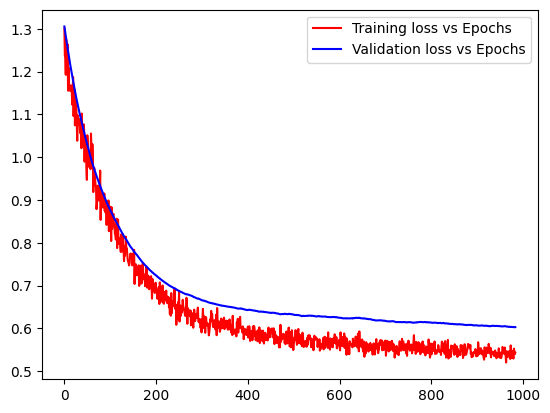

Final validation loss : 0.603, Final validation accuracy : 0.763


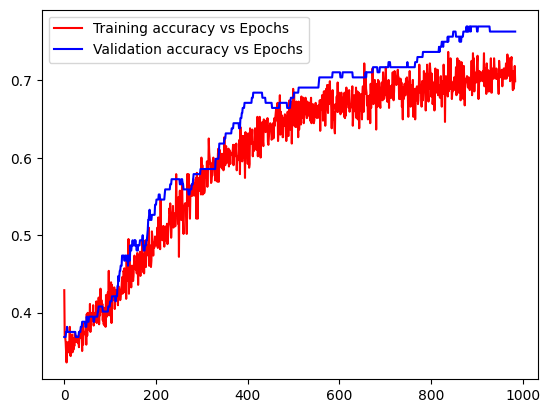

Final validation loss : 0.603, Final validation accuracy : 0.763


In [53]:

sale_cc_history = resultscc.history
fig, ax = plt.subplots()
ax.plot(sale_cc_history['loss'], 'r', label='Training loss vs Epochs')
ax.plot(sale_cc_history['val_loss'], 'b', label='Validation loss vs Epochs')
# plt.ylim([0.2, 1.3])
ax.legend()
plt.show()
print("Final validation loss : {}, Final validation accuracy : {}"\
      .format(round(sale_cc_history['val_loss'][-1],3), round(sale_cc_history['val_accuracy'][-1],3)))
fig, ax = plt.subplots()
ax.plot(sale_cc_history['accuracy'], 'r', label='Training accuracy vs Epochs')
ax.plot(sale_cc_history['val_accuracy'], 'b', label='Validation accuracy vs Epochs')
ax.legend()
plt.show()
print("Final validation loss : {}, Final validation accuracy : {}"\
      .format(round(sale_cc_history['val_loss'][-1],3), round(sale_cc_history['val_accuracy'][-1],3)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 1ms/step
0.5525932400932401
None


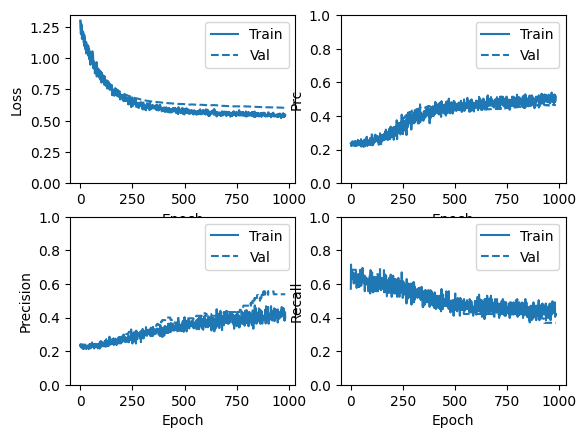

In [54]:
prob = modelcc.predict(X_testcc)
print(roc_auc_score(Y_testcc, prob))
print(plot_metrics(resultscc))
plt.show()


[[94 49]
 [34 14]]
6/6 [==============================] - 0s 1ms/step
Legitimate Transactions Detected (True Negatives):  77
Legitimate Transactions Incorrectly Detected (False Positives):  66
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  23
Total Fraudulent Transactions:  48


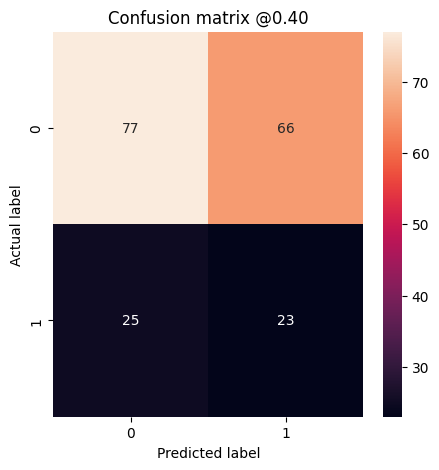

In [55]:
# confusion_matrix(Y_valcc_f, pred)
pd.value_counts(Y_testcc)
pred = [1 if x[0] > 0.45 else 0 for x in prob]
print(confusion_matrix(Y_testcc, pred))
plot_cm(Y_testcc, modelcc.predict(X_testcc), p=0.40)
plt.savefig('cm_CC.png')
plt.show()

In [108]:
weighted_resultscc = modelcc.evaluate(X_testcc, Y_testcc, verbose=0)
for name, value in zip(modelcc.metrics_names, weighted_resultscc):
    print(name, ': ', value)
print()

loss :  0.6715311408042908
f1_loss :  0.6585093140602112
f1_weighted :  0.6585093140602112
tp :  10.0
fp :  18.0
tn :  125.0
fn :  38.0
accuracy :  0.7068063020706177
precision :  0.3571428656578064
recall :  0.2083333283662796
auc :  0.5526660680770874
prc :  0.3144233524799347
cohen_kappa :  -13.815510749816895
sfc :  0.13132576644420624



# Propensity Models for MF

In [59]:

X_trainmf = X_trainmf[featuresMF].to_numpy()
X_testmf = X_testmf[featuresMF].to_numpy()
# X_traincc = X_train
# X_testcc = X_test
pd.value_counts(Y_trainmf)

0.0    606
1.0    154
Name: Sale_MF, dtype: int64

In [60]:
neg, pos = pd.value_counts(Y_trainmf).to_numpy()
total = neg + pos
print('Clients in MF:\n    Total: {}\n    Negatives: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, neg, pos, 100 * pos / total))

Clients in MF:
    Total: 760
    Negatives: 606
    Positive: 154 (20.26% of total)



In [61]:
# Over-Sampling
over = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.6)
# X_traincc, Y_traincc = over.fit_resample(X_traincc, Y_traincc)
X_trainmf, Y_trainmf = over.fit_resample(X_trainmf, Y_trainmf)
X_trainmf, Y_trainmf = under.fit_resample(X_trainmf, Y_trainmf)

# X = X_train
# y = Y_cc_train
print(pd.value_counts(Y_trainmf))

0.0    605
1.0    363
Name: Sale_MF, dtype: int64


In [62]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weightmf = {0: weight_for_0, 1: weight_for_1/0.8}
class_weightmf

{0: 0.6270627062706271, 1: 3.0844155844155843}

In [395]:
# MF ANN architecture
def make_modelmf(input_shape, metrics=Metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential(
        [keras.layers.Dense(15, activation='relu', input_shape=(input_shape,), kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001)),
         keras.layers.Dropout(0.2),
#          keras.layers.Dense(15, activation='relu'),
#          keras.layers.Dropout(0.2),
#          keras.layers.Dense(8, activation='relu'),
         keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
         ])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=5e-4,
        decay_steps=10000,
        decay_rate=0.9)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [396]:
tf.random.set_seed(1234)
# Split the data
x_trainmf, x_validmf, y_trainmf, y_validmf = train_test_split(X_trainmf, Y_trainmf,
                                                      random_state=20, test_size=0.3,
                                                      shuffle= True, stratify=Y_trainmf)

# Load model from py file
modelmf = make_modelmf(x_trainmf.shape[1])
checkpoint = keras.callbacks.ModelCheckpoint('modelmf1.h5', verbose=1, save_best_only=True)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [keras.callbacks.EarlyStopping(patience=150, verbose=1, monitor='val_loss'), checkpoint]

# Compile model
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
print(modelmf.summary())


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 15)                210       
                                                                 
 dropout_10 (Dropout)        (None, 15)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 16        
                                                                 
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________
None


In [397]:
resultsmf = modelmf.fit(x_trainmf, y_trainmf,
                    validation_data=(x_validmf, y_validmf), batch_size=30,
                    epochs=1000, callbacks=callbacks, class_weight=class_weightmf)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/23 [>.............................] - ETA: 29s - loss: 1.0806 - f1_loss: 0.5574 - f1_weighted: 0.5574 - tp: 24.0000 - fp: 32.0000 - tn: 122.0000 - fn: 43.0000 - accuracy: 0.6606 - precision: 0.4286 - recall: 0.3582 - auc: 0.6223 - prc: 0.4513 - cohen_kappa: -13.8155 - sfc: 0.3390WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_functio

Epoch 8/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.7420 - f1_loss: 0.6551 - f1_weighted: 0.6551 - tp: 4.0000 - fp: 9.0000 - tn: 13.0000 - fn: 4.0000 - accuracy: 0.5667 - precision: 0.3077 - recall: 0.5000 - auc: 0.5227 - prc: 0.2626 - cohen_kappa: -13.8155 - sfc: 0.6445
Epoch 8: val_loss did not improve from 0.99974
23/23 [==============================] - 0s 4ms/step - loss: 1.2039 - f1_loss: 0.5489 - f1_weighted: 0.5489 - tp: 130.0000 - fp: 192.0000 - tn: 231.0000 - fn: 124.0000 - accuracy: 0.5332 - precision: 0.4037 - recall: 0.5118 - auc: 0.5501 - prc: 0.4272 - cohen_kappa: -13.8155 - sfc: 0.3162 - val_loss: 1.0549 - val_f1_loss: 0.5535 - val_f1_weighted: 0.5535 - val_tp: 55.0000 - val_fp: 91.0000 - val_tn: 91.0000 - val_fn: 54.0000 - val_accuracy: 0.5017 - val_precision: 0.3767 - val_recall: 0.5046 - val_auc: 0.5255 - val_prc: 0.3881 - val_cohen_kappa: -13.8155 - val_sfc: 0.4209
Epoch 9/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.0764 - f1_

Epoch 17/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.4321 - f1_loss: 0.5561 - f1_weighted: 0.5561 - tp: 9.0000 - fp: 12.0000 - tn: 5.0000 - fn: 4.0000 - accuracy: 0.4667 - precision: 0.4286 - recall: 0.6923 - auc: 0.3688 - prc: 0.3394 - cohen_kappa: -13.8155 - sfc: 0.3801
Epoch 17: val_loss did not improve from 0.99974
23/23 [==============================] - 0s 3ms/step - loss: 1.0609 - f1_loss: 0.5208 - f1_weighted: 0.5208 - tp: 187.0000 - fp: 270.0000 - tn: 153.0000 - fn: 67.0000 - accuracy: 0.5022 - precision: 0.4092 - recall: 0.7362 - auc: 0.5642 - prc: 0.4278 - cohen_kappa: -13.8155 - sfc: 0.3583 - val_loss: 1.0967 - val_f1_loss: 0.5302 - val_f1_weighted: 0.5302 - val_tp: 80.0000 - val_fp: 131.0000 - val_tn: 51.0000 - val_fn: 29.0000 - val_accuracy: 0.4502 - val_precision: 0.3791 - val_recall: 0.7339 - val_auc: 0.5138 - val_prc: 0.3846 - val_cohen_kappa: -13.8155 - val_sfc: 0.4676
Epoch 18/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.9661 - 

Epoch 26/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.0492 - f1_loss: 0.4556 - f1_weighted: 0.4556 - tp: 12.0000 - fp: 11.0000 - tn: 7.0000 - fn: 0.0000e+00 - accuracy: 0.6333 - precision: 0.5217 - recall: 1.0000 - auc: 0.6713 - prc: 0.4637 - cohen_kappa: -13.8155 - sfc: 0.5528
Epoch 26: val_loss did not improve from 0.99974
23/23 [==============================] - 0s 3ms/step - loss: 1.0037 - f1_loss: 0.5054 - f1_weighted: 0.5054 - tp: 205.0000 - fp: 304.0000 - tn: 119.0000 - fn: 49.0000 - accuracy: 0.4786 - precision: 0.4028 - recall: 0.8071 - auc: 0.5688 - prc: 0.4396 - cohen_kappa: -13.8155 - sfc: 0.4038 - val_loss: 1.0894 - val_f1_loss: 0.5207 - val_f1_weighted: 0.5207 - val_tp: 90.0000 - val_fp: 144.0000 - val_tn: 38.0000 - val_fn: 19.0000 - val_accuracy: 0.4399 - val_precision: 0.3846 - val_recall: 0.8257 - val_auc: 0.5061 - val_prc: 0.3856 - val_cohen_kappa: -13.8155 - val_sfc: 0.4678
Epoch 27/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.04

Epoch 35/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.0875 - f1_loss: 0.4630 - f1_weighted: 0.4630 - tp: 11.0000 - fp: 12.0000 - tn: 5.0000 - fn: 2.0000 - accuracy: 0.5333 - precision: 0.4783 - recall: 0.8462 - auc: 0.5566 - prc: 0.4919 - cohen_kappa: -13.8155 - sfc: 0.4428
Epoch 35: val_loss did not improve from 0.99974
23/23 [==============================] - 0s 3ms/step - loss: 0.9707 - f1_loss: 0.4952 - f1_weighted: 0.4952 - tp: 220.0000 - fp: 318.0000 - tn: 105.0000 - fn: 34.0000 - accuracy: 0.4801 - precision: 0.4089 - recall: 0.8661 - auc: 0.5875 - prc: 0.4532 - cohen_kappa: -13.8155 - sfc: 0.3988 - val_loss: 1.0665 - val_f1_loss: 0.5148 - val_f1_weighted: 0.5148 - val_tp: 96.0000 - val_fp: 154.0000 - val_tn: 28.0000 - val_fn: 13.0000 - val_accuracy: 0.4261 - val_precision: 0.3840 - val_recall: 0.8807 - val_auc: 0.5081 - val_prc: 0.3854 - val_cohen_kappa: -13.8155 - val_sfc: 0.4520
Epoch 36/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.3266 -

Epoch 44/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.5549 - f1_loss: 0.4944 - f1_weighted: 0.4944 - tp: 9.0000 - fp: 14.0000 - tn: 4.0000 - fn: 3.0000 - accuracy: 0.4333 - precision: 0.3913 - recall: 0.7500 - auc: 0.5208 - prc: 0.4042 - cohen_kappa: -13.8155 - sfc: 0.7004
Epoch 44: val_loss did not improve from 0.99974
23/23 [==============================] - 0s 3ms/step - loss: 0.9501 - f1_loss: 0.4979 - f1_weighted: 0.4979 - tp: 219.0000 - fp: 337.0000 - tn: 86.0000 - fn: 35.0000 - accuracy: 0.4505 - precision: 0.3939 - recall: 0.8622 - auc: 0.5842 - prc: 0.4781 - cohen_kappa: -13.8155 - sfc: 0.3574 - val_loss: 1.0362 - val_f1_loss: 0.5118 - val_f1_weighted: 0.5118 - val_tp: 100.0000 - val_fp: 158.0000 - val_tn: 24.0000 - val_fn: 9.0000 - val_accuracy: 0.4261 - val_precision: 0.3876 - val_recall: 0.9174 - val_auc: 0.5117 - val_prc: 0.3904 - val_cohen_kappa: -13.8155 - val_sfc: 0.4278
Epoch 45/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.0012 - f

Epoch 53/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7844 - f1_loss: 0.4137 - f1_weighted: 0.4137 - tp: 13.0000 - fp: 16.0000 - tn: 1.0000 - fn: 0.0000e+00 - accuracy: 0.4667 - precision: 0.4483 - recall: 1.0000 - auc: 0.6652 - prc: 0.6025 - cohen_kappa: -13.8155 - sfc: 0.3090
Epoch 53: val_loss did not improve from 0.99974
23/23 [==============================] - 0s 3ms/step - loss: 0.9371 - f1_loss: 0.4966 - f1_weighted: 0.4966 - tp: 225.0000 - fp: 349.0000 - tn: 74.0000 - fn: 29.0000 - accuracy: 0.4417 - precision: 0.3920 - recall: 0.8858 - auc: 0.6032 - prc: 0.4726 - cohen_kappa: -13.8155 - sfc: 0.3756 - val_loss: 1.0155 - val_f1_loss: 0.5089 - val_f1_weighted: 0.5089 - val_tp: 101.0000 - val_fp: 158.0000 - val_tn: 24.0000 - val_fn: 8.0000 - val_accuracy: 0.4296 - val_precision: 0.3900 - val_recall: 0.9266 - val_auc: 0.5185 - val_prc: 0.3992 - val_cohen_kappa: -13.8155 - val_sfc: 0.4116
Epoch 54/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.783

Epoch 62/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7267 - f1_loss: 0.6251 - f1_weighted: 0.6251 - tp: 5.0000 - fp: 16.0000 - tn: 8.0000 - fn: 1.0000 - accuracy: 0.4333 - precision: 0.2381 - recall: 0.8333 - auc: 0.7569 - prc: 0.3914 - cohen_kappa: -13.8155 - sfc: 0.3620
Epoch 62: val_loss improved from 0.99449 to 0.99247, saving model to modelmf1.h5
23/23 [==============================] - 0s 4ms/step - loss: 0.8849 - f1_loss: 0.4892 - f1_weighted: 0.4892 - tp: 234.0000 - fp: 359.0000 - tn: 64.0000 - fn: 20.0000 - accuracy: 0.4402 - precision: 0.3946 - recall: 0.9213 - auc: 0.6163 - prc: 0.5020 - cohen_kappa: -13.8155 - sfc: 0.3598 - val_loss: 0.9925 - val_f1_loss: 0.5071 - val_f1_weighted: 0.5071 - val_tp: 102.0000 - val_fp: 161.0000 - val_tn: 21.0000 - val_fn: 7.0000 - val_accuracy: 0.4227 - val_precision: 0.3878 - val_recall: 0.9358 - val_auc: 0.5255 - val_prc: 0.4096 - val_cohen_kappa: -13.8155 - val_sfc: 0.3919
Epoch 63/1000
 1/23 [>..........................

Epoch 71/1000
22/23 [===========================>..] - ETA: 0s - loss: 0.8919 - f1_loss: 0.4805 - f1_weighted: 0.4805 - tp: 228.0000 - fp: 324.0000 - tn: 85.0000 - fn: 23.0000 - accuracy: 0.4742 - precision: 0.4130 - recall: 0.9084 - auc: 0.6347 - prc: 0.5204 - cohen_kappa: -13.8155 - sfc: 0.3426
Epoch 71: val_loss improved from 0.98239 to 0.98063, saving model to modelmf1.h5
23/23 [==============================] - 0s 5ms/step - loss: 0.8863 - f1_loss: 0.4873 - f1_weighted: 0.4873 - tp: 231.0000 - fp: 333.0000 - tn: 90.0000 - fn: 23.0000 - accuracy: 0.4742 - precision: 0.4096 - recall: 0.9094 - auc: 0.6387 - prc: 0.5203 - cohen_kappa: -13.8155 - sfc: 0.3437 - val_loss: 0.9806 - val_f1_loss: 0.5038 - val_f1_weighted: 0.5038 - val_tp: 104.0000 - val_fp: 162.0000 - val_tn: 20.0000 - val_fn: 5.0000 - val_accuracy: 0.4261 - val_precision: 0.3910 - val_recall: 0.9541 - val_auc: 0.5400 - val_prc: 0.4294 - val_cohen_kappa: -13.8155 - val_sfc: 0.3834
Epoch 72/1000
 1/23 [>.....................

Epoch 80/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.0339 - f1_loss: 0.3869 - f1_weighted: 0.3869 - tp: 13.0000 - fp: 11.0000 - tn: 3.0000 - fn: 3.0000 - accuracy: 0.5333 - precision: 0.5417 - recall: 0.8125 - auc: 0.4911 - prc: 0.4940 - cohen_kappa: -13.8155 - sfc: 0.3573
Epoch 80: val_loss improved from 0.96469 to 0.95755, saving model to modelmf1.h5
23/23 [==============================] - 0s 4ms/step - loss: 0.8812 - f1_loss: 0.4913 - f1_weighted: 0.4913 - tp: 239.0000 - fp: 347.0000 - tn: 76.0000 - fn: 15.0000 - accuracy: 0.4653 - precision: 0.4078 - recall: 0.9409 - auc: 0.6269 - prc: 0.5126 - cohen_kappa: -13.8155 - sfc: 0.3478 - val_loss: 0.9576 - val_f1_loss: 0.5025 - val_f1_weighted: 0.5025 - val_tp: 104.0000 - val_fp: 161.0000 - val_tn: 21.0000 - val_fn: 5.0000 - val_accuracy: 0.4296 - val_precision: 0.3925 - val_recall: 0.9541 - val_auc: 0.5496 - val_prc: 0.4412 - val_cohen_kappa: -13.8155 - val_sfc: 0.3643
Epoch 81/1000
 1/23 [>.........................

Epoch 89/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8032 - f1_loss: 0.4187 - f1_weighted: 0.4187 - tp: 13.0000 - fp: 12.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.6000 - precision: 0.5200 - recall: 1.0000 - auc: 0.6810 - prc: 0.6378 - cohen_kappa: -13.8155 - sfc: 0.2587
Epoch 89: val_loss did not improve from 0.95424
23/23 [==============================] - 0s 3ms/step - loss: 0.8523 - f1_loss: 0.4798 - f1_weighted: 0.4798 - tp: 233.0000 - fp: 342.0000 - tn: 81.0000 - fn: 21.0000 - accuracy: 0.4638 - precision: 0.4052 - recall: 0.9173 - auc: 0.6533 - prc: 0.5385 - cohen_kappa: -13.8155 - sfc: 0.3306 - val_loss: 0.9661 - val_f1_loss: 0.4985 - val_f1_weighted: 0.4985 - val_tp: 105.0000 - val_fp: 165.0000 - val_tn: 17.0000 - val_fn: 4.0000 - val_accuracy: 0.4192 - val_precision: 0.3889 - val_recall: 0.9633 - val_auc: 0.5619 - val_prc: 0.4528 - val_cohen_kappa: -13.8155 - val_sfc: 0.3747
Epoch 90/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.783

Epoch 98/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.9331 - f1_loss: 0.6532 - f1_weighted: 0.6532 - tp: 5.0000 - fp: 18.0000 - tn: 5.0000 - fn: 2.0000 - accuracy: 0.3333 - precision: 0.2174 - recall: 0.7143 - auc: 0.4534 - prc: 0.3203 - cohen_kappa: -13.8155 - sfc: 0.4449
Epoch 98: val_loss improved from 0.94654 to 0.94643, saving model to modelmf1.h5
23/23 [==============================] - 0s 4ms/step - loss: 0.8486 - f1_loss: 0.4902 - f1_weighted: 0.4902 - tp: 238.0000 - fp: 340.0000 - tn: 83.0000 - fn: 16.0000 - accuracy: 0.4742 - precision: 0.4118 - recall: 0.9370 - auc: 0.6419 - prc: 0.5407 - cohen_kappa: -13.8155 - sfc: 0.3122 - val_loss: 0.9464 - val_f1_loss: 0.4989 - val_f1_weighted: 0.4989 - val_tp: 103.0000 - val_fp: 164.0000 - val_tn: 18.0000 - val_fn: 6.0000 - val_accuracy: 0.4158 - val_precision: 0.3858 - val_recall: 0.9450 - val_auc: 0.5646 - val_prc: 0.4591 - val_cohen_kappa: -13.8155 - val_sfc: 0.3570
Epoch 99/1000
 1/23 [>..........................

Epoch 107/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6396 - f1_loss: 0.3958 - f1_weighted: 0.3958 - tp: 12.0000 - fp: 13.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.5667 - precision: 0.4800 - recall: 1.0000 - auc: 0.8449 - prc: 0.8200 - cohen_kappa: -13.8155 - sfc: 0.2367
Epoch 107: val_loss did not improve from 0.93797
23/23 [==============================] - 0s 3ms/step - loss: 0.8667 - f1_loss: 0.4821 - f1_weighted: 0.4821 - tp: 234.0000 - fp: 346.0000 - tn: 77.0000 - fn: 20.0000 - accuracy: 0.4594 - precision: 0.4034 - recall: 0.9213 - auc: 0.6423 - prc: 0.5328 - cohen_kappa: -13.8155 - sfc: 0.3472 - val_loss: 0.9388 - val_f1_loss: 0.4979 - val_f1_weighted: 0.4979 - val_tp: 103.0000 - val_fp: 164.0000 - val_tn: 18.0000 - val_fn: 6.0000 - val_accuracy: 0.4158 - val_precision: 0.3858 - val_recall: 0.9450 - val_auc: 0.5715 - val_prc: 0.4691 - val_cohen_kappa: -13.8155 - val_sfc: 0.3504
Epoch 108/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 116/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.9972 - f1_loss: 0.5075 - f1_weighted: 0.5075 - tp: 9.0000 - fp: 15.0000 - tn: 4.0000 - fn: 2.0000 - accuracy: 0.4333 - precision: 0.3750 - recall: 0.8182 - auc: 0.5574 - prc: 0.4584 - cohen_kappa: -13.8155 - sfc: 0.4505
Epoch 116: val_loss did not improve from 0.93740
23/23 [==============================] - 0s 3ms/step - loss: 0.8714 - f1_loss: 0.4821 - f1_weighted: 0.4821 - tp: 231.0000 - fp: 354.0000 - tn: 69.0000 - fn: 23.0000 - accuracy: 0.4431 - precision: 0.3949 - recall: 0.9094 - auc: 0.6344 - prc: 0.5303 - cohen_kappa: -13.8155 - sfc: 0.3362 - val_loss: 0.9375 - val_f1_loss: 0.4962 - val_f1_weighted: 0.4962 - val_tp: 104.0000 - val_fp: 163.0000 - val_tn: 19.0000 - val_fn: 5.0000 - val_accuracy: 0.4227 - val_precision: 0.3895 - val_recall: 0.9541 - val_auc: 0.5786 - val_prc: 0.4789 - val_cohen_kappa: -13.8155 - val_sfc: 0.3503
Epoch 117/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7485 

Epoch 125/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8776 - f1_loss: 0.5585 - f1_weighted: 0.5585 - tp: 8.0000 - fp: 17.0000 - tn: 4.0000 - fn: 1.0000 - accuracy: 0.4000 - precision: 0.3200 - recall: 0.8889 - auc: 0.6270 - prc: 0.5591 - cohen_kappa: -13.8155 - sfc: 0.3104
Epoch 125: val_loss did not improve from 0.92842
23/23 [==============================] - 0s 4ms/step - loss: 0.8238 - f1_loss: 0.4797 - f1_weighted: 0.4797 - tp: 242.0000 - fp: 338.0000 - tn: 85.0000 - fn: 12.0000 - accuracy: 0.4830 - precision: 0.4172 - recall: 0.9528 - auc: 0.6864 - prc: 0.5519 - cohen_kappa: -13.8155 - sfc: 0.3140 - val_loss: 0.9342 - val_f1_loss: 0.4954 - val_f1_weighted: 0.4954 - val_tp: 103.0000 - val_fp: 163.0000 - val_tn: 19.0000 - val_fn: 6.0000 - val_accuracy: 0.4192 - val_precision: 0.3872 - val_recall: 0.9450 - val_auc: 0.5843 - val_prc: 0.4894 - val_cohen_kappa: -13.8155 - val_sfc: 0.3482
Epoch 126/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7063 

Epoch 134/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8998 - f1_loss: 0.5777 - f1_weighted: 0.5777 - tp: 7.0000 - fp: 20.0000 - tn: 1.0000 - fn: 2.0000 - accuracy: 0.2667 - precision: 0.2593 - recall: 0.7778 - auc: 0.5026 - prc: 0.3755 - cohen_kappa: -13.8155 - sfc: 0.3318
Epoch 134: val_loss did not improve from 0.92842
23/23 [==============================] - 0s 4ms/step - loss: 0.8574 - f1_loss: 0.4779 - f1_weighted: 0.4779 - tp: 230.0000 - fp: 351.0000 - tn: 72.0000 - fn: 24.0000 - accuracy: 0.4461 - precision: 0.3959 - recall: 0.9055 - auc: 0.6368 - prc: 0.5365 - cohen_kappa: -13.8155 - sfc: 0.3402 - val_loss: 0.9323 - val_f1_loss: 0.4951 - val_f1_weighted: 0.4951 - val_tp: 103.0000 - val_fp: 163.0000 - val_tn: 19.0000 - val_fn: 6.0000 - val_accuracy: 0.4192 - val_precision: 0.3872 - val_recall: 0.9450 - val_auc: 0.5894 - val_prc: 0.4936 - val_cohen_kappa: -13.8155 - val_sfc: 0.3468
Epoch 135/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.9034 

Epoch 143/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8617 - f1_loss: 0.5927 - f1_weighted: 0.5927 - tp: 8.0000 - fp: 17.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.4333 - precision: 0.3200 - recall: 1.0000 - auc: 0.6222 - prc: 0.3345 - cohen_kappa: -13.8155 - sfc: 0.3886
Epoch 143: val_loss did not improve from 0.92077
23/23 [==============================] - 0s 4ms/step - loss: 0.8439 - f1_loss: 0.4860 - f1_weighted: 0.4860 - tp: 240.0000 - fp: 350.0000 - tn: 73.0000 - fn: 14.0000 - accuracy: 0.4623 - precision: 0.4068 - recall: 0.9449 - auc: 0.6594 - prc: 0.5491 - cohen_kappa: -13.8155 - sfc: 0.3220 - val_loss: 0.9222 - val_f1_loss: 0.4954 - val_f1_weighted: 0.4954 - val_tp: 103.0000 - val_fp: 161.0000 - val_tn: 21.0000 - val_fn: 6.0000 - val_accuracy: 0.4261 - val_precision: 0.3902 - val_recall: 0.9450 - val_auc: 0.5908 - val_prc: 0.4967 - val_cohen_kappa: -13.8155 - val_sfc: 0.3373
Epoch 144/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7

Epoch 152/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7826 - f1_loss: 0.5396 - f1_weighted: 0.5396 - tp: 9.0000 - fp: 17.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.4333 - precision: 0.3462 - recall: 1.0000 - auc: 0.6720 - prc: 0.4522 - cohen_kappa: -13.8155 - sfc: 0.3075
Epoch 152: val_loss did not improve from 0.91899
23/23 [==============================] - 0s 4ms/step - loss: 0.8259 - f1_loss: 0.4739 - f1_weighted: 0.4739 - tp: 238.0000 - fp: 345.0000 - tn: 78.0000 - fn: 16.0000 - accuracy: 0.4668 - precision: 0.4082 - recall: 0.9370 - auc: 0.6725 - prc: 0.5552 - cohen_kappa: -13.8155 - sfc: 0.3194 - val_loss: 0.9265 - val_f1_loss: 0.4939 - val_f1_weighted: 0.4939 - val_tp: 104.0000 - val_fp: 162.0000 - val_tn: 20.0000 - val_fn: 5.0000 - val_accuracy: 0.4261 - val_precision: 0.3910 - val_recall: 0.9541 - val_auc: 0.5981 - val_prc: 0.5044 - val_cohen_kappa: -13.8155 - val_sfc: 0.3421
Epoch 153/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8

Epoch 161/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7760 - f1_loss: 0.5012 - f1_weighted: 0.5012 - tp: 10.0000 - fp: 17.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.4333 - precision: 0.3704 - recall: 1.0000 - auc: 0.7400 - prc: 0.4819 - cohen_kappa: -13.8155 - sfc: 0.3277
Epoch 161: val_loss did not improve from 0.91899
23/23 [==============================] - 0s 4ms/step - loss: 0.8048 - f1_loss: 0.4735 - f1_weighted: 0.4735 - tp: 246.0000 - fp: 335.0000 - tn: 88.0000 - fn: 8.0000 - accuracy: 0.4934 - precision: 0.4234 - recall: 0.9685 - auc: 0.6857 - prc: 0.5611 - cohen_kappa: -13.8155 - sfc: 0.3081 - val_loss: 0.9256 - val_f1_loss: 0.4930 - val_f1_weighted: 0.4930 - val_tp: 104.0000 - val_fp: 161.0000 - val_tn: 21.0000 - val_fn: 5.0000 - val_accuracy: 0.4296 - val_precision: 0.3925 - val_recall: 0.9541 - val_auc: 0.6035 - val_prc: 0.5095 - val_cohen_kappa: -13.8155 - val_sfc: 0.3417
Epoch 162/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7

Epoch 170/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7077 - f1_loss: 0.5028 - f1_weighted: 0.5028 - tp: 9.0000 - fp: 16.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.4667 - precision: 0.3600 - recall: 1.0000 - auc: 0.7672 - prc: 0.5862 - cohen_kappa: -13.8155 - sfc: 0.3454
Epoch 170: val_loss did not improve from 0.91899
23/23 [==============================] - 0s 3ms/step - loss: 0.7899 - f1_loss: 0.4636 - f1_weighted: 0.4636 - tp: 242.0000 - fp: 334.0000 - tn: 89.0000 - fn: 12.0000 - accuracy: 0.4889 - precision: 0.4201 - recall: 0.9528 - auc: 0.6993 - prc: 0.5956 - cohen_kappa: -13.8155 - sfc: 0.2950 - val_loss: 0.9243 - val_f1_loss: 0.4928 - val_f1_weighted: 0.4928 - val_tp: 104.0000 - val_fp: 161.0000 - val_tn: 21.0000 - val_fn: 5.0000 - val_accuracy: 0.4296 - val_precision: 0.3925 - val_recall: 0.9541 - val_auc: 0.6091 - val_prc: 0.5144 - val_cohen_kappa: -13.8155 - val_sfc: 0.3405
Epoch 171/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6

Epoch 179/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8457 - f1_loss: 0.5404 - f1_weighted: 0.5404 - tp: 8.0000 - fp: 20.0000 - tn: 1.0000 - fn: 1.0000 - accuracy: 0.3000 - precision: 0.2857 - recall: 0.8889 - auc: 0.6720 - prc: 0.4033 - cohen_kappa: -13.8155 - sfc: 0.4209
Epoch 179: val_loss did not improve from 0.91899
23/23 [==============================] - 0s 3ms/step - loss: 0.8028 - f1_loss: 0.4643 - f1_weighted: 0.4643 - tp: 239.0000 - fp: 336.0000 - tn: 87.0000 - fn: 15.0000 - accuracy: 0.4815 - precision: 0.4157 - recall: 0.9409 - auc: 0.6907 - prc: 0.5878 - cohen_kappa: -13.8155 - sfc: 0.2966 - val_loss: 0.9284 - val_f1_loss: 0.4917 - val_f1_weighted: 0.4917 - val_tp: 104.0000 - val_fp: 162.0000 - val_tn: 20.0000 - val_fn: 5.0000 - val_accuracy: 0.4261 - val_precision: 0.3910 - val_recall: 0.9541 - val_auc: 0.6130 - val_prc: 0.5169 - val_cohen_kappa: -13.8155 - val_sfc: 0.3448
Epoch 180/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7828 

Epoch 188/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6913 - f1_loss: 0.3616 - f1_weighted: 0.3616 - tp: 14.0000 - fp: 12.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.6000 - precision: 0.5385 - recall: 1.0000 - auc: 0.8147 - prc: 0.7808 - cohen_kappa: -13.8155 - sfc: 0.2145
Epoch 188: val_loss did not improve from 0.91899
23/23 [==============================] - 0s 3ms/step - loss: 0.7815 - f1_loss: 0.4643 - f1_weighted: 0.4643 - tp: 249.0000 - fp: 338.0000 - tn: 85.0000 - fn: 5.0000 - accuracy: 0.4934 - precision: 0.4242 - recall: 0.9803 - auc: 0.7150 - prc: 0.5885 - cohen_kappa: -13.8155 - sfc: 0.3155 - val_loss: 0.9212 - val_f1_loss: 0.4923 - val_f1_weighted: 0.4923 - val_tp: 103.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 6.0000 - val_accuracy: 0.4330 - val_precision: 0.3931 - val_recall: 0.9450 - val_auc: 0.6125 - val_prc: 0.5192 - val_cohen_kappa: -13.8155 - val_sfc: 0.3379
Epoch 189/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6

Epoch 197/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.9247 - f1_loss: 0.4888 - f1_weighted: 0.4888 - tp: 9.0000 - fp: 14.0000 - tn: 4.0000 - fn: 3.0000 - accuracy: 0.4333 - precision: 0.3913 - recall: 0.7500 - auc: 0.6111 - prc: 0.5324 - cohen_kappa: -13.8155 - sfc: 0.2142
Epoch 197: val_loss did not improve from 0.91528
23/23 [==============================] - 0s 3ms/step - loss: 0.8080 - f1_loss: 0.4747 - f1_weighted: 0.4747 - tp: 240.0000 - fp: 355.0000 - tn: 68.0000 - fn: 14.0000 - accuracy: 0.4549 - precision: 0.4034 - recall: 0.9449 - auc: 0.6863 - prc: 0.5909 - cohen_kappa: -13.8155 - sfc: 0.3042 - val_loss: 0.9173 - val_f1_loss: 0.4915 - val_f1_weighted: 0.4915 - val_tp: 103.0000 - val_fp: 161.0000 - val_tn: 21.0000 - val_fn: 6.0000 - val_accuracy: 0.4261 - val_precision: 0.3902 - val_recall: 0.9450 - val_auc: 0.6233 - val_prc: 0.5295 - val_cohen_kappa: -13.8155 - val_sfc: 0.3344
Epoch 198/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7781 

Epoch 206/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8383 - f1_loss: 0.4232 - f1_weighted: 0.4232 - tp: 13.0000 - fp: 16.0000 - tn: 1.0000 - fn: 0.0000e+00 - accuracy: 0.4667 - precision: 0.4483 - recall: 1.0000 - auc: 0.6312 - prc: 0.6296 - cohen_kappa: -13.8155 - sfc: 0.3310
Epoch 206: val_loss improved from 0.91447 to 0.91281, saving model to modelmf1.h5
23/23 [==============================] - 0s 5ms/step - loss: 0.7977 - f1_loss: 0.4700 - f1_weighted: 0.4700 - tp: 245.0000 - fp: 347.0000 - tn: 76.0000 - fn: 9.0000 - accuracy: 0.4742 - precision: 0.4139 - recall: 0.9646 - auc: 0.6880 - prc: 0.5929 - cohen_kappa: -13.8155 - sfc: 0.2995 - val_loss: 0.9128 - val_f1_loss: 0.4920 - val_f1_weighted: 0.4920 - val_tp: 100.0000 - val_fp: 162.0000 - val_tn: 20.0000 - val_fn: 9.0000 - val_accuracy: 0.4124 - val_precision: 0.3817 - val_recall: 0.9174 - val_auc: 0.6224 - val_prc: 0.5318 - val_cohen_kappa: -13.8155 - val_sfc: 0.3296
Epoch 207/1000
23/23 [====================

Epoch 215/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.9549 - f1_loss: 0.6080 - f1_weighted: 0.6080 - tp: 7.0000 - fp: 20.0000 - tn: 2.0000 - fn: 1.0000 - accuracy: 0.3000 - precision: 0.2593 - recall: 0.8750 - auc: 0.5540 - prc: 0.3781 - cohen_kappa: -13.8155 - sfc: 0.4784
Epoch 215: val_loss did not improve from 0.90388
23/23 [==============================] - 0s 4ms/step - loss: 0.7830 - f1_loss: 0.4632 - f1_weighted: 0.4632 - tp: 244.0000 - fp: 331.0000 - tn: 92.0000 - fn: 10.0000 - accuracy: 0.4963 - precision: 0.4243 - recall: 0.9606 - auc: 0.7108 - prc: 0.5986 - cohen_kappa: -13.8155 - sfc: 0.2857 - val_loss: 0.9099 - val_f1_loss: 0.4912 - val_f1_weighted: 0.4912 - val_tp: 101.0000 - val_fp: 162.0000 - val_tn: 20.0000 - val_fn: 8.0000 - val_accuracy: 0.4158 - val_precision: 0.3840 - val_recall: 0.9266 - val_auc: 0.6265 - val_prc: 0.5363 - val_cohen_kappa: -13.8155 - val_sfc: 0.3275
Epoch 216/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8048 

Epoch 224/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7413 - f1_loss: 0.6043 - f1_weighted: 0.6043 - tp: 7.0000 - fp: 19.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.3667 - precision: 0.2692 - recall: 1.0000 - auc: 0.7174 - prc: 0.5552 - cohen_kappa: -13.8155 - sfc: 0.3245
Epoch 224: val_loss did not improve from 0.90388
23/23 [==============================] - 0s 4ms/step - loss: 0.7886 - f1_loss: 0.4656 - f1_weighted: 0.4656 - tp: 242.0000 - fp: 334.0000 - tn: 89.0000 - fn: 12.0000 - accuracy: 0.4889 - precision: 0.4201 - recall: 0.9528 - auc: 0.7033 - prc: 0.6055 - cohen_kappa: -13.8155 - sfc: 0.2947 - val_loss: 0.9080 - val_f1_loss: 0.4905 - val_f1_weighted: 0.4905 - val_tp: 100.0000 - val_fp: 160.0000 - val_tn: 22.0000 - val_fn: 9.0000 - val_accuracy: 0.4192 - val_precision: 0.3846 - val_recall: 0.9174 - val_auc: 0.6283 - val_prc: 0.5405 - val_cohen_kappa: -13.8155 - val_sfc: 0.3261
Epoch 225/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7

Epoch 233/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7394 - f1_loss: 0.3302 - f1_weighted: 0.3302 - tp: 16.0000 - fp: 10.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.6667 - precision: 0.6154 - recall: 1.0000 - auc: 0.8326 - prc: 0.8461 - cohen_kappa: -13.8155 - sfc: 0.1473
Epoch 233: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 3ms/step - loss: 0.7860 - f1_loss: 0.4647 - f1_weighted: 0.4647 - tp: 244.0000 - fp: 337.0000 - tn: 86.0000 - fn: 10.0000 - accuracy: 0.4874 - precision: 0.4200 - recall: 0.9606 - auc: 0.7056 - prc: 0.5977 - cohen_kappa: -13.8155 - sfc: 0.2946 - val_loss: 0.9108 - val_f1_loss: 0.4898 - val_f1_weighted: 0.4898 - val_tp: 100.0000 - val_fp: 160.0000 - val_tn: 22.0000 - val_fn: 9.0000 - val_accuracy: 0.4192 - val_precision: 0.3846 - val_recall: 0.9174 - val_auc: 0.6284 - val_prc: 0.5405 - val_cohen_kappa: -13.8155 - val_sfc: 0.3288
Epoch 234/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 242/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7272 - f1_loss: 0.4113 - f1_weighted: 0.4113 - tp: 12.0000 - fp: 10.0000 - tn: 8.0000 - fn: 0.0000e+00 - accuracy: 0.6667 - precision: 0.5455 - recall: 1.0000 - auc: 0.7639 - prc: 0.6455 - cohen_kappa: -13.8155 - sfc: 0.2914
Epoch 242: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 4ms/step - loss: 0.7898 - f1_loss: 0.4611 - f1_weighted: 0.4611 - tp: 243.0000 - fp: 328.0000 - tn: 95.0000 - fn: 11.0000 - accuracy: 0.4993 - precision: 0.4256 - recall: 0.9567 - auc: 0.6987 - prc: 0.5937 - cohen_kappa: -13.8155 - sfc: 0.3134 - val_loss: 0.9140 - val_f1_loss: 0.4893 - val_f1_weighted: 0.4893 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6293 - val_prc: 0.5405 - val_cohen_kappa: -13.8155 - val_sfc: 0.3316
Epoch 243/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 251/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7658 - f1_loss: 0.3833 - f1_weighted: 0.3833 - tp: 13.0000 - fp: 13.0000 - tn: 3.0000 - fn: 1.0000 - accuracy: 0.5333 - precision: 0.5000 - recall: 0.9286 - auc: 0.7723 - prc: 0.7496 - cohen_kappa: -13.8155 - sfc: 0.2343
Epoch 251: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 3ms/step - loss: 0.7888 - f1_loss: 0.4649 - f1_weighted: 0.4649 - tp: 248.0000 - fp: 326.0000 - tn: 97.0000 - fn: 6.0000 - accuracy: 0.5096 - precision: 0.4321 - recall: 0.9764 - auc: 0.6930 - prc: 0.5787 - cohen_kappa: -13.8155 - sfc: 0.3078 - val_loss: 0.9068 - val_f1_loss: 0.4891 - val_f1_weighted: 0.4891 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6331 - val_prc: 0.5445 - val_cohen_kappa: -13.8155 - val_sfc: 0.3250
Epoch 252/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8379 

Epoch 260/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8146 - f1_loss: 0.4820 - f1_weighted: 0.4820 - tp: 11.0000 - fp: 14.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.5333 - precision: 0.4400 - recall: 1.0000 - auc: 0.6722 - prc: 0.5098 - cohen_kappa: -13.8155 - sfc: 0.2552
Epoch 260: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 3ms/step - loss: 0.7543 - f1_loss: 0.4514 - f1_weighted: 0.4514 - tp: 248.0000 - fp: 325.0000 - tn: 98.0000 - fn: 6.0000 - accuracy: 0.5111 - precision: 0.4328 - recall: 0.9764 - auc: 0.7357 - prc: 0.6283 - cohen_kappa: -13.8155 - sfc: 0.2953 - val_loss: 0.9118 - val_f1_loss: 0.4888 - val_f1_weighted: 0.4888 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6329 - val_prc: 0.5447 - val_cohen_kappa: -13.8155 - val_sfc: 0.3292
Epoch 261/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6

Epoch 269/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7826 - f1_loss: 0.6059 - f1_weighted: 0.6059 - tp: 7.0000 - fp: 18.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.4000 - precision: 0.2800 - recall: 1.0000 - auc: 0.6894 - prc: 0.4209 - cohen_kappa: -13.8155 - sfc: 0.3788
Epoch 269: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 3ms/step - loss: 0.7778 - f1_loss: 0.4636 - f1_weighted: 0.4636 - tp: 248.0000 - fp: 338.0000 - tn: 85.0000 - fn: 6.0000 - accuracy: 0.4919 - precision: 0.4232 - recall: 0.9764 - auc: 0.7120 - prc: 0.6108 - cohen_kappa: -13.8155 - sfc: 0.2950 - val_loss: 0.9092 - val_f1_loss: 0.4887 - val_f1_weighted: 0.4887 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6342 - val_prc: 0.5528 - val_cohen_kappa: -13.8155 - val_sfc: 0.3269
Epoch 270/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.74

Epoch 278/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7565 - f1_loss: 0.4190 - f1_weighted: 0.4190 - tp: 12.0000 - fp: 12.0000 - tn: 6.0000 - fn: 0.0000e+00 - accuracy: 0.6000 - precision: 0.5000 - recall: 1.0000 - auc: 0.7546 - prc: 0.6173 - cohen_kappa: -13.8155 - sfc: 0.2726
Epoch 278: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 3ms/step - loss: 0.7607 - f1_loss: 0.4546 - f1_weighted: 0.4546 - tp: 246.0000 - fp: 328.0000 - tn: 95.0000 - fn: 8.0000 - accuracy: 0.5037 - precision: 0.4286 - recall: 0.9685 - auc: 0.7237 - prc: 0.6266 - cohen_kappa: -13.8155 - sfc: 0.2868 - val_loss: 0.9108 - val_f1_loss: 0.4878 - val_f1_weighted: 0.4878 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6369 - val_prc: 0.5566 - val_cohen_kappa: -13.8155 - val_sfc: 0.3285
Epoch 279/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7

Epoch 287/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7669 - f1_loss: 0.4220 - f1_weighted: 0.4220 - tp: 11.0000 - fp: 11.0000 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.6000 - precision: 0.5000 - recall: 0.9167 - auc: 0.7431 - prc: 0.6752 - cohen_kappa: -13.8155 - sfc: 0.2037
Epoch 287: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 4ms/step - loss: 0.7843 - f1_loss: 0.4603 - f1_weighted: 0.4603 - tp: 245.0000 - fp: 330.0000 - tn: 93.0000 - fn: 9.0000 - accuracy: 0.4993 - precision: 0.4261 - recall: 0.9646 - auc: 0.7020 - prc: 0.5975 - cohen_kappa: -13.8155 - sfc: 0.2995 - val_loss: 0.9101 - val_f1_loss: 0.4873 - val_f1_weighted: 0.4873 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6395 - val_prc: 0.5498 - val_cohen_kappa: -13.8155 - val_sfc: 0.3280
Epoch 288/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6519 

Epoch 296/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7886 - f1_loss: 0.5152 - f1_weighted: 0.5152 - tp: 9.0000 - fp: 16.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.4667 - precision: 0.3600 - recall: 1.0000 - auc: 0.6720 - prc: 0.3853 - cohen_kappa: -13.8155 - sfc: 0.4135
Epoch 296: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 4ms/step - loss: 0.7603 - f1_loss: 0.4589 - f1_weighted: 0.4589 - tp: 245.0000 - fp: 333.0000 - tn: 90.0000 - fn: 9.0000 - accuracy: 0.4948 - precision: 0.4239 - recall: 0.9646 - auc: 0.7284 - prc: 0.6254 - cohen_kappa: -13.8155 - sfc: 0.2992 - val_loss: 0.9065 - val_f1_loss: 0.4872 - val_f1_weighted: 0.4872 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6428 - val_prc: 0.5619 - val_cohen_kappa: -13.8155 - val_sfc: 0.3246
Epoch 297/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.79

Epoch 305/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8057 - f1_loss: 0.2578 - f1_weighted: 0.2578 - tp: 19.0000 - fp: 7.0000 - tn: 3.0000 - fn: 1.0000 - accuracy: 0.7333 - precision: 0.7308 - recall: 0.9500 - auc: 0.7200 - prc: 0.8446 - cohen_kappa: -13.8155 - sfc: 0.1582
Epoch 305: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 3ms/step - loss: 0.7707 - f1_loss: 0.4613 - f1_weighted: 0.4613 - tp: 246.0000 - fp: 322.0000 - tn: 101.0000 - fn: 8.0000 - accuracy: 0.5126 - precision: 0.4331 - recall: 0.9685 - auc: 0.7209 - prc: 0.6008 - cohen_kappa: -13.8155 - sfc: 0.3132 - val_loss: 0.9177 - val_f1_loss: 0.4855 - val_f1_weighted: 0.4855 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6442 - val_prc: 0.5538 - val_cohen_kappa: -13.8155 - val_sfc: 0.3355
Epoch 306/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8577 

Epoch 314/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7643 - f1_loss: 0.4220 - f1_weighted: 0.4220 - tp: 11.0000 - fp: 12.0000 - tn: 6.0000 - fn: 1.0000 - accuracy: 0.5667 - precision: 0.4783 - recall: 0.9167 - auc: 0.7361 - prc: 0.6197 - cohen_kappa: -13.8155 - sfc: 0.2206
Epoch 314: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 3ms/step - loss: 0.7634 - f1_loss: 0.4580 - f1_weighted: 0.4580 - tp: 247.0000 - fp: 327.0000 - tn: 96.0000 - fn: 7.0000 - accuracy: 0.5066 - precision: 0.4303 - recall: 0.9724 - auc: 0.7300 - prc: 0.6107 - cohen_kappa: -13.8155 - sfc: 0.2957 - val_loss: 0.9098 - val_f1_loss: 0.4852 - val_f1_weighted: 0.4852 - val_tp: 100.0000 - val_fp: 159.0000 - val_tn: 23.0000 - val_fn: 9.0000 - val_accuracy: 0.4227 - val_precision: 0.3861 - val_recall: 0.9174 - val_auc: 0.6480 - val_prc: 0.5578 - val_cohen_kappa: -13.8155 - val_sfc: 0.3286
Epoch 315/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7656 

Epoch 323/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7462 - f1_loss: 0.4577 - f1_weighted: 0.4577 - tp: 11.0000 - fp: 17.0000 - tn: 2.0000 - fn: 0.0000e+00 - accuracy: 0.4333 - precision: 0.3929 - recall: 1.0000 - auc: 0.7464 - prc: 0.5905 - cohen_kappa: -13.8155 - sfc: 0.2728
Epoch 323: val_loss did not improve from 0.90194
23/23 [==============================] - 0s 4ms/step - loss: 0.7569 - f1_loss: 0.4535 - f1_weighted: 0.4535 - tp: 249.0000 - fp: 318.0000 - tn: 105.0000 - fn: 5.0000 - accuracy: 0.5229 - precision: 0.4392 - recall: 0.9803 - auc: 0.7314 - prc: 0.6091 - cohen_kappa: -13.8155 - sfc: 0.2911 - val_loss: 0.9065 - val_f1_loss: 0.4854 - val_f1_weighted: 0.4854 - val_tp: 100.0000 - val_fp: 158.0000 - val_tn: 24.0000 - val_fn: 9.0000 - val_accuracy: 0.4261 - val_precision: 0.3876 - val_recall: 0.9174 - val_auc: 0.6490 - val_prc: 0.5573 - val_cohen_kappa: -13.8155 - val_sfc: 0.3250
Epoch 324/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 332/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8356 - f1_loss: 0.3251 - f1_weighted: 0.3251 - tp: 17.0000 - fp: 11.0000 - tn: 2.0000 - fn: 0.0000e+00 - accuracy: 0.6333 - precision: 0.6071 - recall: 1.0000 - auc: 0.6697 - prc: 0.7474 - cohen_kappa: -13.8155 - sfc: 0.2188
Epoch 332: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7493 - f1_loss: 0.4546 - f1_weighted: 0.4546 - tp: 251.0000 - fp: 311.0000 - tn: 112.0000 - fn: 3.0000 - accuracy: 0.5362 - precision: 0.4466 - recall: 0.9882 - auc: 0.7301 - prc: 0.6261 - cohen_kappa: -13.8155 - sfc: 0.2807 - val_loss: 0.9096 - val_f1_loss: 0.4851 - val_f1_weighted: 0.4851 - val_tp: 100.0000 - val_fp: 158.0000 - val_tn: 24.0000 - val_fn: 9.0000 - val_accuracy: 0.4261 - val_precision: 0.3876 - val_recall: 0.9174 - val_auc: 0.6496 - val_prc: 0.5563 - val_cohen_kappa: -13.8155 - val_sfc: 0.3278
Epoch 333/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 341/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6540 - f1_loss: 0.3762 - f1_weighted: 0.3762 - tp: 13.0000 - fp: 14.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.5333 - precision: 0.4815 - recall: 1.0000 - auc: 0.8416 - prc: 0.8607 - cohen_kappa: -13.8155 - sfc: 0.1773
Epoch 341: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7528 - f1_loss: 0.4527 - f1_weighted: 0.4527 - tp: 247.0000 - fp: 318.0000 - tn: 105.0000 - fn: 7.0000 - accuracy: 0.5199 - precision: 0.4372 - recall: 0.9724 - auc: 0.7336 - prc: 0.6117 - cohen_kappa: -13.8155 - sfc: 0.2947 - val_loss: 0.9097 - val_f1_loss: 0.4852 - val_f1_weighted: 0.4852 - val_tp: 100.0000 - val_fp: 158.0000 - val_tn: 24.0000 - val_fn: 9.0000 - val_accuracy: 0.4261 - val_precision: 0.3876 - val_recall: 0.9174 - val_auc: 0.6478 - val_prc: 0.5605 - val_cohen_kappa: -13.8155 - val_sfc: 0.3276
Epoch 342/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 350/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7604 - f1_loss: 0.4482 - f1_weighted: 0.4482 - tp: 10.0000 - fp: 16.0000 - tn: 3.0000 - fn: 1.0000 - accuracy: 0.4333 - precision: 0.3846 - recall: 0.9091 - auc: 0.7512 - prc: 0.7048 - cohen_kappa: -13.8155 - sfc: 0.3549
Epoch 350: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 4ms/step - loss: 0.7519 - f1_loss: 0.4481 - f1_weighted: 0.4481 - tp: 246.0000 - fp: 317.0000 - tn: 106.0000 - fn: 8.0000 - accuracy: 0.5199 - precision: 0.4369 - recall: 0.9685 - auc: 0.7342 - prc: 0.6092 - cohen_kappa: -13.8155 - sfc: 0.2986 - val_loss: 0.9014 - val_f1_loss: 0.4847 - val_f1_weighted: 0.4847 - val_tp: 100.0000 - val_fp: 158.0000 - val_tn: 24.0000 - val_fn: 9.0000 - val_accuracy: 0.4261 - val_precision: 0.3876 - val_recall: 0.9174 - val_auc: 0.6522 - val_prc: 0.5642 - val_cohen_kappa: -13.8155 - val_sfc: 0.3206
Epoch 351/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6120

Epoch 359/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8189 - f1_loss: 0.4454 - f1_weighted: 0.4454 - tp: 12.0000 - fp: 12.0000 - tn: 6.0000 - fn: 0.0000e+00 - accuracy: 0.6000 - precision: 0.5000 - recall: 1.0000 - auc: 0.6296 - prc: 0.4517 - cohen_kappa: -13.8155 - sfc: 0.3248
Epoch 359: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7508 - f1_loss: 0.4489 - f1_weighted: 0.4489 - tp: 245.0000 - fp: 299.0000 - tn: 124.0000 - fn: 9.0000 - accuracy: 0.5451 - precision: 0.4504 - recall: 0.9646 - auc: 0.7376 - prc: 0.6196 - cohen_kappa: -13.8155 - sfc: 0.2883 - val_loss: 0.9152 - val_f1_loss: 0.4842 - val_f1_weighted: 0.4842 - val_tp: 100.0000 - val_fp: 157.0000 - val_tn: 25.0000 - val_fn: 9.0000 - val_accuracy: 0.4296 - val_precision: 0.3891 - val_recall: 0.9174 - val_auc: 0.6480 - val_prc: 0.5602 - val_cohen_kappa: -13.8155 - val_sfc: 0.3328
Epoch 360/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 368/1000
21/23 [==========================>...] - ETA: 0s - loss: 0.7582 - f1_loss: 0.4517 - f1_weighted: 0.4517 - tp: 227.0000 - fp: 291.0000 - tn: 104.0000 - fn: 8.0000 - accuracy: 0.5254 - precision: 0.4382 - recall: 0.9660 - auc: 0.7275 - prc: 0.6176 - cohen_kappa: -13.8155 - sfc: 0.2919
Epoch 368: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 4ms/step - loss: 0.7541 - f1_loss: 0.4542 - f1_weighted: 0.4542 - tp: 245.0000 - fp: 311.0000 - tn: 112.0000 - fn: 9.0000 - accuracy: 0.5273 - precision: 0.4406 - recall: 0.9646 - auc: 0.7326 - prc: 0.6277 - cohen_kappa: -13.8155 - sfc: 0.2858 - val_loss: 0.9076 - val_f1_loss: 0.4838 - val_f1_weighted: 0.4838 - val_tp: 100.0000 - val_fp: 157.0000 - val_tn: 25.0000 - val_fn: 9.0000 - val_accuracy: 0.4296 - val_precision: 0.3891 - val_recall: 0.9174 - val_auc: 0.6519 - val_prc: 0.5628 - val_cohen_kappa: -13.8155 - val_sfc: 0.3262
Epoch 369/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 377/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6592 - f1_loss: 0.4903 - f1_weighted: 0.4903 - tp: 9.0000 - fp: 16.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.4667 - precision: 0.3600 - recall: 1.0000 - auc: 0.8254 - prc: 0.7328 - cohen_kappa: -13.8155 - sfc: 0.2803
Epoch 377: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 4ms/step - loss: 0.7336 - f1_loss: 0.4492 - f1_weighted: 0.4492 - tp: 246.0000 - fp: 310.0000 - tn: 113.0000 - fn: 8.0000 - accuracy: 0.5303 - precision: 0.4424 - recall: 0.9685 - auc: 0.7544 - prc: 0.6443 - cohen_kappa: -13.8155 - sfc: 0.2783 - val_loss: 0.9142 - val_f1_loss: 0.4838 - val_f1_weighted: 0.4838 - val_tp: 100.0000 - val_fp: 157.0000 - val_tn: 25.0000 - val_fn: 9.0000 - val_accuracy: 0.4296 - val_precision: 0.3891 - val_recall: 0.9174 - val_auc: 0.6502 - val_prc: 0.5607 - val_cohen_kappa: -13.8155 - val_sfc: 0.3318
Epoch 378/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7

Epoch 386/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8125 - f1_loss: 0.3862 - f1_weighted: 0.3862 - tp: 14.0000 - fp: 12.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.6000 - precision: 0.5385 - recall: 1.0000 - auc: 0.7188 - prc: 0.6736 - cohen_kappa: -13.8155 - sfc: 0.2389
Epoch 386: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 4ms/step - loss: 0.7474 - f1_loss: 0.4499 - f1_weighted: 0.4499 - tp: 248.0000 - fp: 319.0000 - tn: 104.0000 - fn: 6.0000 - accuracy: 0.5199 - precision: 0.4374 - recall: 0.9764 - auc: 0.7421 - prc: 0.6244 - cohen_kappa: -13.8155 - sfc: 0.2927 - val_loss: 0.9119 - val_f1_loss: 0.4834 - val_f1_weighted: 0.4834 - val_tp: 100.0000 - val_fp: 156.0000 - val_tn: 26.0000 - val_fn: 9.0000 - val_accuracy: 0.4330 - val_precision: 0.3906 - val_recall: 0.9174 - val_auc: 0.6518 - val_prc: 0.5539 - val_cohen_kappa: -13.8155 - val_sfc: 0.3301
Epoch 387/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 395/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7354 - f1_loss: 0.3431 - f1_weighted: 0.3431 - tp: 15.0000 - fp: 11.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.6333 - precision: 0.5769 - recall: 1.0000 - auc: 0.7044 - prc: 0.6956 - cohen_kappa: -13.8155 - sfc: 0.2798
Epoch 395: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7258 - f1_loss: 0.4425 - f1_weighted: 0.4425 - tp: 251.0000 - fp: 313.0000 - tn: 110.0000 - fn: 3.0000 - accuracy: 0.5332 - precision: 0.4450 - recall: 0.9882 - auc: 0.7634 - prc: 0.6451 - cohen_kappa: -13.8155 - sfc: 0.2856 - val_loss: 0.9138 - val_f1_loss: 0.4835 - val_f1_weighted: 0.4835 - val_tp: 100.0000 - val_fp: 156.0000 - val_tn: 26.0000 - val_fn: 9.0000 - val_accuracy: 0.4330 - val_precision: 0.3906 - val_recall: 0.9174 - val_auc: 0.6513 - val_prc: 0.5610 - val_cohen_kappa: -13.8155 - val_sfc: 0.3314
Epoch 396/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 404/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7044 - f1_loss: 0.3646 - f1_weighted: 0.3646 - tp: 14.0000 - fp: 11.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.6333 - precision: 0.5600 - recall: 1.0000 - auc: 0.8192 - prc: 0.8178 - cohen_kappa: -13.8155 - sfc: 0.2146
Epoch 404: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7653 - f1_loss: 0.4587 - f1_weighted: 0.4587 - tp: 245.0000 - fp: 313.0000 - tn: 110.0000 - fn: 9.0000 - accuracy: 0.5244 - precision: 0.4391 - recall: 0.9646 - auc: 0.7202 - prc: 0.6217 - cohen_kappa: -13.8155 - sfc: 0.2993 - val_loss: 0.9222 - val_f1_loss: 0.4831 - val_f1_weighted: 0.4831 - val_tp: 101.0000 - val_fp: 156.0000 - val_tn: 26.0000 - val_fn: 8.0000 - val_accuracy: 0.4364 - val_precision: 0.3930 - val_recall: 0.9266 - val_auc: 0.6501 - val_prc: 0.5503 - val_cohen_kappa: -13.8155 - val_sfc: 0.3389
Epoch 405/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 413/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8237 - f1_loss: 0.4823 - f1_weighted: 0.4823 - tp: 11.0000 - fp: 13.0000 - tn: 6.0000 - fn: 0.0000e+00 - accuracy: 0.5667 - precision: 0.4583 - recall: 1.0000 - auc: 0.5909 - prc: 0.3921 - cohen_kappa: -13.8155 - sfc: 0.2503
Epoch 413: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7310 - f1_loss: 0.4393 - f1_weighted: 0.4393 - tp: 250.0000 - fp: 305.0000 - tn: 118.0000 - fn: 4.0000 - accuracy: 0.5436 - precision: 0.4505 - recall: 0.9843 - auc: 0.7487 - prc: 0.6398 - cohen_kappa: -13.8155 - sfc: 0.2955 - val_loss: 0.9128 - val_f1_loss: 0.4833 - val_f1_weighted: 0.4833 - val_tp: 101.0000 - val_fp: 155.0000 - val_tn: 27.0000 - val_fn: 8.0000 - val_accuracy: 0.4399 - val_precision: 0.3945 - val_recall: 0.9266 - val_auc: 0.6518 - val_prc: 0.5512 - val_cohen_kappa: -13.8155 - val_sfc: 0.3304
Epoch 414/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 422/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7765 - f1_loss: 0.4591 - f1_weighted: 0.4591 - tp: 10.0000 - fp: 14.0000 - tn: 5.0000 - fn: 1.0000 - accuracy: 0.5000 - precision: 0.4167 - recall: 0.9091 - auc: 0.7368 - prc: 0.6198 - cohen_kappa: -13.8155 - sfc: 0.2174
Epoch 422: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7262 - f1_loss: 0.4435 - f1_weighted: 0.4435 - tp: 250.0000 - fp: 308.0000 - tn: 115.0000 - fn: 4.0000 - accuracy: 0.5391 - precision: 0.4480 - recall: 0.9843 - auc: 0.7557 - prc: 0.6475 - cohen_kappa: -13.8155 - sfc: 0.2794 - val_loss: 0.9107 - val_f1_loss: 0.4829 - val_f1_weighted: 0.4829 - val_tp: 101.0000 - val_fp: 155.0000 - val_tn: 27.0000 - val_fn: 8.0000 - val_accuracy: 0.4399 - val_precision: 0.3945 - val_recall: 0.9266 - val_auc: 0.6535 - val_prc: 0.5532 - val_cohen_kappa: -13.8155 - val_sfc: 0.3286
Epoch 423/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7275

Epoch 431/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7467 - f1_loss: 0.3652 - f1_weighted: 0.3652 - tp: 14.0000 - fp: 12.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.6000 - precision: 0.5385 - recall: 1.0000 - auc: 0.7969 - prc: 0.7110 - cohen_kappa: -13.8155 - sfc: 0.2475
Epoch 431: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 4ms/step - loss: 0.7254 - f1_loss: 0.4472 - f1_weighted: 0.4472 - tp: 248.0000 - fp: 307.0000 - tn: 116.0000 - fn: 6.0000 - accuracy: 0.5377 - precision: 0.4468 - recall: 0.9764 - auc: 0.7621 - prc: 0.6465 - cohen_kappa: -13.8155 - sfc: 0.2755 - val_loss: 0.9126 - val_f1_loss: 0.4820 - val_f1_weighted: 0.4820 - val_tp: 101.0000 - val_fp: 155.0000 - val_tn: 27.0000 - val_fn: 8.0000 - val_accuracy: 0.4399 - val_precision: 0.3945 - val_recall: 0.9266 - val_auc: 0.6582 - val_prc: 0.5579 - val_cohen_kappa: -13.8155 - val_sfc: 0.3304
Epoch 432/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 440/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6810 - f1_loss: 0.3528 - f1_weighted: 0.3528 - tp: 14.0000 - fp: 13.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.5667 - precision: 0.5185 - recall: 1.0000 - auc: 0.8036 - prc: 0.8087 - cohen_kappa: -13.8155 - sfc: 0.2529
Epoch 440: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7211 - f1_loss: 0.4378 - f1_weighted: 0.4378 - tp: 248.0000 - fp: 306.0000 - tn: 117.0000 - fn: 6.0000 - accuracy: 0.5391 - precision: 0.4477 - recall: 0.9764 - auc: 0.7606 - prc: 0.6565 - cohen_kappa: -13.8155 - sfc: 0.2840 - val_loss: 0.9121 - val_f1_loss: 0.4827 - val_f1_weighted: 0.4827 - val_tp: 101.0000 - val_fp: 154.0000 - val_tn: 28.0000 - val_fn: 8.0000 - val_accuracy: 0.4433 - val_precision: 0.3961 - val_recall: 0.9266 - val_auc: 0.6528 - val_prc: 0.5554 - val_cohen_kappa: -13.8155 - val_sfc: 0.3292
Epoch 441/1000
14/23 [=================>............] - ETA: 0s - loss: 0.

Epoch 449/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7219 - f1_loss: 0.2733 - f1_weighted: 0.2733 - tp: 18.0000 - fp: 10.0000 - tn: 2.0000 - fn: 0.0000e+00 - accuracy: 0.6667 - precision: 0.6429 - recall: 1.0000 - auc: 0.7292 - prc: 0.8168 - cohen_kappa: -13.8155 - sfc: 0.2377
Epoch 449: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7124 - f1_loss: 0.4431 - f1_weighted: 0.4431 - tp: 251.0000 - fp: 299.0000 - tn: 124.0000 - fn: 3.0000 - accuracy: 0.5539 - precision: 0.4564 - recall: 0.9882 - auc: 0.7618 - prc: 0.6599 - cohen_kappa: -13.8155 - sfc: 0.2780 - val_loss: 0.9182 - val_f1_loss: 0.4813 - val_f1_weighted: 0.4813 - val_tp: 101.0000 - val_fp: 155.0000 - val_tn: 27.0000 - val_fn: 8.0000 - val_accuracy: 0.4399 - val_precision: 0.3945 - val_recall: 0.9266 - val_auc: 0.6559 - val_prc: 0.5568 - val_cohen_kappa: -13.8155 - val_sfc: 0.3354
Epoch 450/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 458/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.7274 - f1_loss: 0.4679 - f1_weighted: 0.4679 - tp: 10.0000 - fp: 13.0000 - tn: 7.0000 - fn: 0.0000e+00 - accuracy: 0.5667 - precision: 0.4348 - recall: 1.0000 - auc: 0.7125 - prc: 0.4825 - cohen_kappa: -13.8155 - sfc: 0.2547
Epoch 458: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7416 - f1_loss: 0.4384 - f1_weighted: 0.4384 - tp: 248.0000 - fp: 306.0000 - tn: 117.0000 - fn: 6.0000 - accuracy: 0.5391 - precision: 0.4477 - recall: 0.9764 - auc: 0.7369 - prc: 0.6230 - cohen_kappa: -13.8155 - sfc: 0.3013 - val_loss: 0.9160 - val_f1_loss: 0.4820 - val_f1_weighted: 0.4820 - val_tp: 101.0000 - val_fp: 154.0000 - val_tn: 28.0000 - val_fn: 8.0000 - val_accuracy: 0.4433 - val_precision: 0.3961 - val_recall: 0.9266 - val_auc: 0.6548 - val_prc: 0.5580 - val_cohen_kappa: -13.8155 - val_sfc: 0.3328
Epoch 459/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

Epoch 467/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6314 - f1_loss: 0.6074 - f1_weighted: 0.6074 - tp: 6.0000 - fp: 16.0000 - tn: 8.0000 - fn: 0.0000e+00 - accuracy: 0.4667 - precision: 0.2727 - recall: 1.0000 - auc: 0.8403 - prc: 0.6220 - cohen_kappa: -13.8155 - sfc: 0.2852
Epoch 467: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 4ms/step - loss: 0.7308 - f1_loss: 0.4432 - f1_weighted: 0.4432 - tp: 248.0000 - fp: 305.0000 - tn: 118.0000 - fn: 6.0000 - accuracy: 0.5406 - precision: 0.4485 - recall: 0.9764 - auc: 0.7483 - prc: 0.6513 - cohen_kappa: -13.8155 - sfc: 0.2853 - val_loss: 0.9130 - val_f1_loss: 0.4813 - val_f1_weighted: 0.4813 - val_tp: 101.0000 - val_fp: 151.0000 - val_tn: 31.0000 - val_fn: 8.0000 - val_accuracy: 0.4536 - val_precision: 0.4008 - val_recall: 0.9266 - val_auc: 0.6549 - val_prc: 0.5582 - val_cohen_kappa: -13.8155 - val_sfc: 0.3305
Epoch 468/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.6

Epoch 476/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.8827 - f1_loss: 0.3643 - f1_weighted: 0.3643 - tp: 15.0000 - fp: 10.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.6667 - precision: 0.6000 - recall: 1.0000 - auc: 0.6289 - prc: 0.5505 - cohen_kappa: -13.8155 - sfc: 0.3204
Epoch 476: val_loss did not improve from 0.90033
23/23 [==============================] - 0s 3ms/step - loss: 0.7340 - f1_loss: 0.4383 - f1_weighted: 0.4383 - tp: 249.0000 - fp: 302.0000 - tn: 121.0000 - fn: 5.0000 - accuracy: 0.5465 - precision: 0.4519 - recall: 0.9803 - auc: 0.7479 - prc: 0.6318 - cohen_kappa: -13.8155 - sfc: 0.3021 - val_loss: 0.9205 - val_f1_loss: 0.4808 - val_f1_weighted: 0.4808 - val_tp: 101.0000 - val_fp: 153.0000 - val_tn: 29.0000 - val_fn: 8.0000 - val_accuracy: 0.4467 - val_precision: 0.3976 - val_recall: 0.9266 - val_auc: 0.6549 - val_prc: 0.5575 - val_cohen_kappa: -13.8155 - val_sfc: 0.3373
Epoch 477/1000
 1/23 [>.............................] - ETA: 0s - loss: 0.

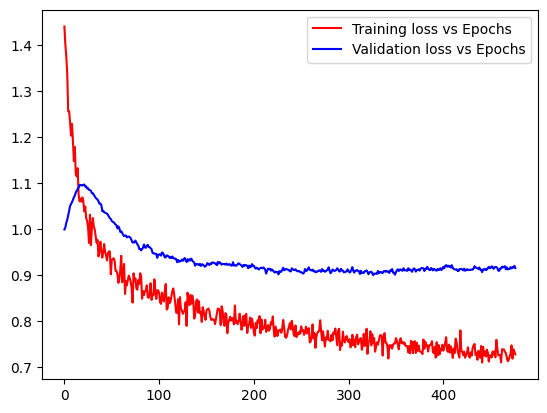

Final validation loss : 0.916, Final validation accuracy : 0.457


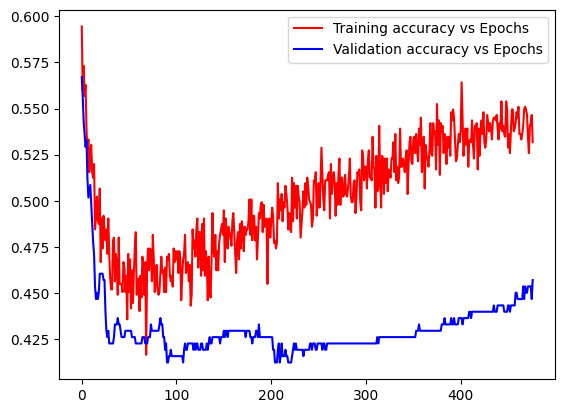

Final validation loss : 0.916, Final validation accuracy : 0.457


In [398]:

sale_mf_history = resultsmf.history
fig, ax = plt.subplots()
ax.plot(sale_mf_history['loss'], 'r', label='Training loss vs Epochs')
ax.plot(sale_mf_history['val_loss'], 'b', label='Validation loss vs Epochs')
# plt.ylim([0.2, 1.3])
ax.legend()
plt.show()
print("Final validation loss : {}, Final validation accuracy : {}"\
      .format(round(sale_mf_history['val_loss'][-1],3), round(sale_mf_history['val_accuracy'][-1],3)))
fig, ax = plt.subplots()
ax.plot(sale_mf_history['accuracy'], 'r', label='Training accuracy vs Epochs')
ax.plot(sale_mf_history['val_accuracy'], 'b', label='Validation accuracy vs Epochs')
ax.legend()
plt.show()
print("Final validation loss : {}, Final validation accuracy : {}"\
      .format(round(sale_mf_history['val_loss'][-1],3), round(sale_mf_history['val_accuracy'][-1],3)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 1ms/step
0.5929487179487181
None


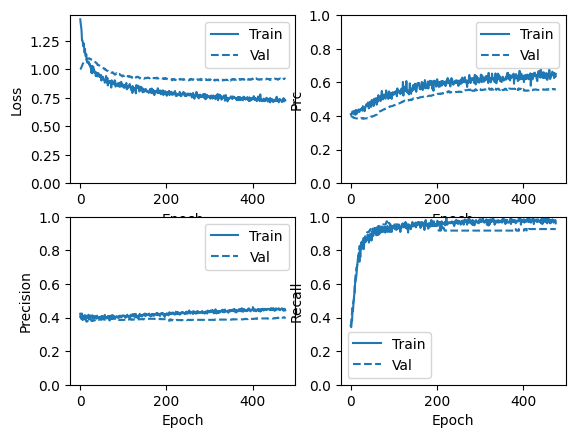

In [399]:
probmf = modelmf.predict(X_testmf)
print(roc_auc_score(Y_testmf, probmf))
print(plot_metrics(resultsmf))
plt.show()


[[ 31 121]
 [  8  31]]
6/6 [==============================] - 0s 1ms/step
Legitimate Transactions Detected (True Negatives):  68
Legitimate Transactions Incorrectly Detected (False Positives):  84
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  26
Total Fraudulent Transactions:  39


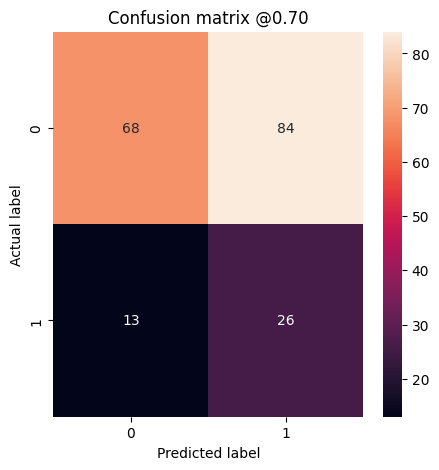

In [400]:
# confusion_matrix(Y_valcc_f, pred)
pd.value_counts(Y_testmf)
predmf = [1 if x[0] > 0.45 else 0 for x in probmf]
print(confusion_matrix(Y_testmf, predmf))
plot_cm(Y_testmf, modelmf.predict(X_testmf), p=0.70)
# plt.savefig('cm_MF.png')
plt.show()

In [107]:
weighted_resultsmf = modelmf.evaluate(X_testmf, Y_testmf, verbose=0)
for name, value in zip(modelmf.metrics_names, weighted_resultsmf):
    print(name, ': ', value)
print()

loss :  1.0529357194900513
f1_loss :  0.6770825386047363
f1_weighted :  0.6770825386047363
tp :  38.0
fp :  139.0
tn :  13.0
fn :  1.0
accuracy :  0.2670156955718994
precision :  0.21468926966190338
recall :  0.9743589758872986
auc :  0.6437246799468994
prc :  0.37218034267425537
cohen_kappa :  -13.815510749816895
sfc :  0.40632644295692444



# Propensity model for Consumer Loan

In [94]:

X_traincl = X_traincl[featuresCL].to_numpy()
X_testcl = X_testcl[featuresCL].to_numpy()
# X_traincc = X_train
# X_testcc = X_test
pd.value_counts(Y_traincl)

0.0    529
1.0    231
Name: Sale_CL, dtype: int64

In [95]:
neg_cl, pos_cl = pd.value_counts(Y_traincl).to_numpy()
total_cl = neg_cl + pos_cl
print('Clients in TrainCL:\n    Total: {}\n    Negatives: {}\n    Positive: {} ({:.2f}% of total)\n'
      .format(total_cl, neg_cl, pos_cl, 100 * pos_cl/total_cl))

Clients in TrainCL:
    Total: 760
    Negatives: 529
    Positive: 231 (30.39% of total)



In [96]:
# Over-Sampling
print(pd.value_counts(Y_traincl))
over = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.6)
# X_traincc, Y_traincc = over.fit_resample(X_traincc, Y_traincc)
X_traincl, Y_traincl = over.fit_resample(X_traincl, Y_traincl)
X_traincl, Y_traincl = under.fit_resample(X_traincl, Y_traincl)

# X = X_train
# y = Y_cc_train
print(pd.value_counts(Y_traincl))

0.0    529
1.0    231
Name: Sale_CL, dtype: int64
0.0    528
1.0    317
Name: Sale_CL, dtype: int64


In [97]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg_cl) * (total_cl / 2.0)
weight_for_1 = (1 / pos_cl) * (total_cl / 2.0)

class_weightcl = {0: weight_for_0, 1: weight_for_1/1}
class_weightcl

{0: 0.718336483931947, 1: 1.645021645021645}

In [98]:
def make_modelcl(input_shape, metrics=Metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential(
        [keras.layers.Dense(12, activation='relu', input_shape=(input_shape,), kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001)),
         keras.layers.Dropout(0.2),
         keras.layers.Dense(15, activation='relu'),
         keras.layers.Dropout(0.2),
#          keras.layers.Dense(8, activation='relu'),
         keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
         ])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=5e-4,
        decay_steps=10000,
        decay_rate=0.9)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [99]:
tf.random.set_seed(1234)
# Split the data
x_traincl, x_validcl, y_traincl, y_validcl = train_test_split(X_traincl, Y_traincl,
                                                      random_state=20, test_size=0.3,
                                                      shuffle= True, stratify=Y_traincl)

# Load model from py file
modelcl = make_modelcl(x_traincl.shape[1])
checkpoint = keras.callbacks.ModelCheckpoint('modelcl2.h5', verbose=1, save_best_only=True)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [keras.callbacks.EarlyStopping(patience=50, verbose=1, monitor='val_loss'), checkpoint]

# Compile model
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
print(modelcl.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12)                156       
                                                                 
 dropout_8 (Dropout)         (None, 12)                0         
                                                                 
 dense_16 (Dense)            (None, 15)                195       
                                                                 
 dropout_9 (Dropout)         (None, 15)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 16        
                                                                 
Total params: 367
Trainable params: 367
Non-trainable params: 0
_________________________________________________________________
None


In [100]:
resultscl = modelcl.fit(x_traincl, y_traincl,
                    validation_data=(x_validcl, y_validcl), batch_size=30,
                    epochs=1000, callbacks=callbacks,
#                         class_weight=class_weightcl
                       )

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/20 [>.............................] - ETA: 23s - loss: 1.0620 - f1_loss: 0.5132 - f1_weighted: 0.5132 - tp: 11.0000 - fp: 18.0000 - tn: 0.0000e+00 - fn: 1.0000 - accuracy: 0.3667 - precision: 0.3793 - recall: 0.9167 - auc: 0.3125 - prc: 0.3050 - cohen_kappa: -13.8155 - sfc: 0.4209WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_functi

Epoch 8/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.9307 - f1_loss: 0.6646 - f1_weighted: 0.6646 - tp: 5.0000 - fp: 13.0000 - tn: 8.0000 - fn: 4.0000 - accuracy: 0.4333 - precision: 0.2778 - recall: 0.5556 - auc: 0.3677 - prc: 0.2292 - cohen_kappa: -13.8155 - sfc: 0.2324
Epoch 8: val_loss improved from 0.81095 to 0.79111, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.8504 - f1_loss: 0.5523 - f1_weighted: 0.5523 - tp: 157.0000 - fp: 277.0000 - tn: 92.0000 - fn: 65.0000 - accuracy: 0.4213 - precision: 0.3618 - recall: 0.7072 - auc: 0.4813 - prc: 0.3746 - cohen_kappa: -13.8155 - sfc: 0.2264 - val_loss: 0.7911 - val_f1_loss: 0.5303 - val_f1_weighted: 0.5303 - val_tp: 76.0000 - val_fp: 119.0000 - val_tn: 40.0000 - val_fn: 19.0000 - val_accuracy: 0.4567 - val_precision: 0.3897 - val_recall: 0.8000 - val_auc: 0.5622 - val_prc: 0.4029 - val_cohen_kappa: -13.8155 - val_sfc: 0.1966
Epoch 9/1000
 1/20 [>.............................

Epoch 17/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6226 - f1_loss: 0.5055 - f1_weighted: 0.5055 - tp: 8.0000 - fp: 6.0000 - tn: 12.0000 - fn: 4.0000 - accuracy: 0.6667 - precision: 0.5714 - recall: 0.6667 - auc: 0.6991 - prc: 0.5452 - cohen_kappa: -13.8155 - sfc: 0.0988
Epoch 17: val_loss improved from 0.70426 to 0.69734, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.7489 - f1_loss: 0.5696 - f1_weighted: 0.5696 - tp: 125.0000 - fp: 183.0000 - tn: 186.0000 - fn: 97.0000 - accuracy: 0.5262 - precision: 0.4058 - recall: 0.5631 - auc: 0.5445 - prc: 0.4205 - cohen_kappa: -13.8155 - sfc: 0.1472 - val_loss: 0.6973 - val_f1_loss: 0.5412 - val_f1_weighted: 0.5412 - val_tp: 59.0000 - val_fp: 69.0000 - val_tn: 90.0000 - val_fn: 36.0000 - val_accuracy: 0.5866 - val_precision: 0.4609 - val_recall: 0.6211 - val_auc: 0.6262 - val_prc: 0.4413 - val_cohen_kappa: -13.8155 - val_sfc: 0.1295
Epoch 18/1000
 1/20 [>..........................

Epoch 26/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7875 - f1_loss: 0.6234 - f1_weighted: 0.6234 - tp: 5.0000 - fp: 13.0000 - tn: 7.0000 - fn: 5.0000 - accuracy: 0.4000 - precision: 0.2778 - recall: 0.5000 - auc: 0.4225 - prc: 0.3942 - cohen_kappa: -13.8155 - sfc: 0.1478
Epoch 26: val_loss improved from 0.66844 to 0.66524, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.7086 - f1_loss: 0.5635 - f1_weighted: 0.5635 - tp: 110.0000 - fp: 150.0000 - tn: 219.0000 - fn: 112.0000 - accuracy: 0.5567 - precision: 0.4231 - recall: 0.4955 - auc: 0.5969 - prc: 0.4857 - cohen_kappa: -13.8155 - sfc: 0.1231 - val_loss: 0.6652 - val_f1_loss: 0.5348 - val_f1_weighted: 0.5348 - val_tp: 65.0000 - val_fp: 57.0000 - val_tn: 102.0000 - val_fn: 30.0000 - val_accuracy: 0.6575 - val_precision: 0.5328 - val_recall: 0.6842 - val_auc: 0.6666 - val_prc: 0.4788 - val_cohen_kappa: -13.8155 - val_sfc: 0.1155
Epoch 27/1000
 1/20 [>........................

Epoch 35/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6232 - f1_loss: 0.5172 - f1_weighted: 0.5172 - tp: 5.0000 - fp: 6.0000 - tn: 12.0000 - fn: 7.0000 - accuracy: 0.5667 - precision: 0.4545 - recall: 0.4167 - auc: 0.6644 - prc: 0.4988 - cohen_kappa: -13.8155 - sfc: 0.1018
Epoch 35: val_loss improved from 0.64621 to 0.64428, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.6834 - f1_loss: 0.5541 - f1_weighted: 0.5541 - tp: 113.0000 - fp: 124.0000 - tn: 245.0000 - fn: 109.0000 - accuracy: 0.6058 - precision: 0.4768 - recall: 0.5090 - auc: 0.6239 - prc: 0.5148 - cohen_kappa: -13.8155 - sfc: 0.1156 - val_loss: 0.6443 - val_f1_loss: 0.5316 - val_f1_weighted: 0.5316 - val_tp: 62.0000 - val_fp: 58.0000 - val_tn: 101.0000 - val_fn: 33.0000 - val_accuracy: 0.6417 - val_precision: 0.5167 - val_recall: 0.6526 - val_auc: 0.6790 - val_prc: 0.5039 - val_cohen_kappa: -13.8155 - val_sfc: 0.1067
Epoch 36/1000
 1/20 [>........................

Epoch 44/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5115 - f1_loss: 0.5753 - f1_weighted: 0.5753 - tp: 4.0000 - fp: 4.0000 - tn: 18.0000 - fn: 4.0000 - accuracy: 0.7333 - precision: 0.5000 - recall: 0.5000 - auc: 0.7841 - prc: 0.6477 - cohen_kappa: -13.8155 - sfc: 0.0621
Epoch 44: val_loss improved from 0.63581 to 0.63261, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.6641 - f1_loss: 0.5513 - f1_weighted: 0.5513 - tp: 113.0000 - fp: 111.0000 - tn: 258.0000 - fn: 109.0000 - accuracy: 0.6277 - precision: 0.5045 - recall: 0.5090 - auc: 0.6430 - prc: 0.5405 - cohen_kappa: -13.8155 - sfc: 0.1060 - val_loss: 0.6326 - val_f1_loss: 0.5288 - val_f1_weighted: 0.5288 - val_tp: 60.0000 - val_fp: 52.0000 - val_tn: 107.0000 - val_fn: 35.0000 - val_accuracy: 0.6575 - val_precision: 0.5357 - val_recall: 0.6316 - val_auc: 0.6885 - val_prc: 0.5256 - val_cohen_kappa: -13.8155 - val_sfc: 0.1017
Epoch 45/1000
 1/20 [>........................

Epoch 53/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7357 - f1_loss: 0.6720 - f1_weighted: 0.6720 - tp: 3.0000 - fp: 10.0000 - tn: 12.0000 - fn: 5.0000 - accuracy: 0.5000 - precision: 0.2308 - recall: 0.3750 - auc: 0.4688 - prc: 0.2429 - cohen_kappa: -13.8155 - sfc: 0.1518
Epoch 53: val_loss improved from 0.62542 to 0.62511, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.6664 - f1_loss: 0.5570 - f1_weighted: 0.5570 - tp: 110.0000 - fp: 114.0000 - tn: 255.0000 - fn: 112.0000 - accuracy: 0.6176 - precision: 0.4911 - recall: 0.4955 - auc: 0.6351 - prc: 0.5076 - cohen_kappa: -13.8155 - sfc: 0.1085 - val_loss: 0.6251 - val_f1_loss: 0.5279 - val_f1_weighted: 0.5279 - val_tp: 60.0000 - val_fp: 49.0000 - val_tn: 110.0000 - val_fn: 35.0000 - val_accuracy: 0.6693 - val_precision: 0.5505 - val_recall: 0.6316 - val_auc: 0.6948 - val_prc: 0.5411 - val_cohen_kappa: -13.8155 - val_sfc: 0.0976
Epoch 54/1000
 1/20 [>.......................

Epoch 62/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6818 - f1_loss: 0.4872 - f1_weighted: 0.4872 - tp: 6.0000 - fp: 4.0000 - tn: 11.0000 - fn: 9.0000 - accuracy: 0.5667 - precision: 0.6000 - recall: 0.4000 - auc: 0.6667 - prc: 0.6526 - cohen_kappa: -13.8155 - sfc: 0.0978
Epoch 62: val_loss improved from 0.61944 to 0.61910, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.6431 - f1_loss: 0.5451 - f1_weighted: 0.5451 - tp: 111.0000 - fp: 100.0000 - tn: 269.0000 - fn: 111.0000 - accuracy: 0.6430 - precision: 0.5261 - recall: 0.5000 - auc: 0.6653 - prc: 0.5700 - cohen_kappa: -13.8155 - sfc: 0.0987 - val_loss: 0.6191 - val_f1_loss: 0.5258 - val_f1_weighted: 0.5258 - val_tp: 58.0000 - val_fp: 45.0000 - val_tn: 114.0000 - val_fn: 37.0000 - val_accuracy: 0.6772 - val_precision: 0.5631 - val_recall: 0.6105 - val_auc: 0.7011 - val_prc: 0.5535 - val_cohen_kappa: -13.8155 - val_sfc: 0.0943
Epoch 63/1000
 1/20 [>........................

Epoch 71/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7359 - f1_loss: 0.5415 - f1_weighted: 0.5415 - tp: 6.0000 - fp: 4.0000 - tn: 13.0000 - fn: 7.0000 - accuracy: 0.6333 - precision: 0.6000 - recall: 0.4615 - auc: 0.6493 - prc: 0.5719 - cohen_kappa: -13.8155 - sfc: 0.1181
Epoch 71: val_loss did not improve from 0.61464
20/20 [==============================] - 0s 4ms/step - loss: 0.6536 - f1_loss: 0.5486 - f1_weighted: 0.5486 - tp: 108.0000 - fp: 98.0000 - tn: 271.0000 - fn: 114.0000 - accuracy: 0.6413 - precision: 0.5243 - recall: 0.4865 - auc: 0.6544 - prc: 0.5540 - cohen_kappa: -13.8155 - sfc: 0.1006 - val_loss: 0.6150 - val_f1_loss: 0.5261 - val_f1_weighted: 0.5261 - val_tp: 58.0000 - val_fp: 45.0000 - val_tn: 114.0000 - val_fn: 37.0000 - val_accuracy: 0.6772 - val_precision: 0.5631 - val_recall: 0.6105 - val_auc: 0.7035 - val_prc: 0.5675 - val_cohen_kappa: -13.8155 - val_sfc: 0.0910
Epoch 72/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5245 - 

Epoch 80/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7768 - f1_loss: 0.5595 - f1_weighted: 0.5595 - tp: 5.0000 - fp: 8.0000 - tn: 9.0000 - fn: 8.0000 - accuracy: 0.4667 - precision: 0.3846 - recall: 0.3846 - auc: 0.4615 - prc: 0.5749 - cohen_kappa: -13.8155 - sfc: 0.1303
Epoch 80: val_loss did not improve from 0.61097
20/20 [==============================] - 0s 4ms/step - loss: 0.6385 - f1_loss: 0.5502 - f1_weighted: 0.5502 - tp: 116.0000 - fp: 90.0000 - tn: 279.0000 - fn: 106.0000 - accuracy: 0.6684 - precision: 0.5631 - recall: 0.5225 - auc: 0.6593 - prc: 0.5884 - cohen_kappa: -13.8155 - sfc: 0.0939 - val_loss: 0.6129 - val_f1_loss: 0.5258 - val_f1_weighted: 0.5258 - val_tp: 57.0000 - val_fp: 43.0000 - val_tn: 116.0000 - val_fn: 38.0000 - val_accuracy: 0.6811 - val_precision: 0.5700 - val_recall: 0.6000 - val_auc: 0.7064 - val_prc: 0.5910 - val_cohen_kappa: -13.8155 - val_sfc: 0.0887
Epoch 81/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5080 - f

Epoch 89/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6522 - f1_loss: 0.4982 - f1_weighted: 0.4982 - tp: 7.0000 - fp: 5.0000 - tn: 12.0000 - fn: 6.0000 - accuracy: 0.6333 - precision: 0.5833 - recall: 0.5385 - auc: 0.6403 - prc: 0.6419 - cohen_kappa: -13.8155 - sfc: 0.1002
Epoch 89: val_loss did not improve from 0.60798
20/20 [==============================] - 0s 4ms/step - loss: 0.6304 - f1_loss: 0.5538 - f1_weighted: 0.5538 - tp: 100.0000 - fp: 64.0000 - tn: 305.0000 - fn: 122.0000 - accuracy: 0.6853 - precision: 0.6098 - recall: 0.4505 - auc: 0.6716 - prc: 0.5805 - cohen_kappa: -13.8155 - sfc: 0.0894 - val_loss: 0.6081 - val_f1_loss: 0.5288 - val_f1_weighted: 0.5288 - val_tp: 55.0000 - val_fp: 40.0000 - val_tn: 119.0000 - val_fn: 40.0000 - val_accuracy: 0.6850 - val_precision: 0.5789 - val_recall: 0.5789 - val_auc: 0.7052 - val_prc: 0.5968 - val_cohen_kappa: -13.8155 - val_sfc: 0.0849
Epoch 90/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6398 - 

Epoch 98/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5753 - f1_loss: 0.6039 - f1_weighted: 0.6039 - tp: 3.0000 - fp: 5.0000 - tn: 16.0000 - fn: 6.0000 - accuracy: 0.6333 - precision: 0.3750 - recall: 0.3333 - auc: 0.7037 - prc: 0.4002 - cohen_kappa: -13.8155 - sfc: 0.0822
Epoch 98: val_loss improved from 0.60588 to 0.60534, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.6200 - f1_loss: 0.5523 - f1_weighted: 0.5523 - tp: 100.0000 - fp: 68.0000 - tn: 301.0000 - fn: 122.0000 - accuracy: 0.6785 - precision: 0.5952 - recall: 0.4505 - auc: 0.6793 - prc: 0.5993 - cohen_kappa: -13.8155 - sfc: 0.0852 - val_loss: 0.6053 - val_f1_loss: 0.5278 - val_f1_weighted: 0.5278 - val_tp: 52.0000 - val_fp: 40.0000 - val_tn: 119.0000 - val_fn: 43.0000 - val_accuracy: 0.6732 - val_precision: 0.5652 - val_recall: 0.5474 - val_auc: 0.7072 - val_prc: 0.6117 - val_cohen_kappa: -13.8155 - val_sfc: 0.0836
Epoch 99/1000
 1/20 [>.........................

Epoch 107/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6897 - f1_loss: 0.6596 - f1_weighted: 0.6596 - tp: 3.0000 - fp: 6.0000 - tn: 16.0000 - fn: 5.0000 - accuracy: 0.6333 - precision: 0.3333 - recall: 0.3750 - auc: 0.5625 - prc: 0.3099 - cohen_kappa: -13.8155 - sfc: 0.1221
Epoch 107: val_loss improved from 0.60276 to 0.60208, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.6128 - f1_loss: 0.5411 - f1_weighted: 0.5411 - tp: 103.0000 - fp: 65.0000 - tn: 304.0000 - fn: 119.0000 - accuracy: 0.6887 - precision: 0.6131 - recall: 0.4640 - auc: 0.6863 - prc: 0.6153 - cohen_kappa: -13.8155 - sfc: 0.0834 - val_loss: 0.6021 - val_f1_loss: 0.5294 - val_f1_weighted: 0.5294 - val_tp: 51.0000 - val_fp: 35.0000 - val_tn: 124.0000 - val_fn: 44.0000 - val_accuracy: 0.6890 - val_precision: 0.5930 - val_recall: 0.5368 - val_auc: 0.7075 - val_prc: 0.6145 - val_cohen_kappa: -13.8155 - val_sfc: 0.0815
Epoch 108/1000
 1/20 [>......................

Epoch 116/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7717 - f1_loss: 0.4874 - f1_weighted: 0.4874 - tp: 6.0000 - fp: 2.0000 - tn: 10.0000 - fn: 12.0000 - accuracy: 0.5333 - precision: 0.7500 - recall: 0.3333 - auc: 0.6250 - prc: 0.7501 - cohen_kappa: -13.8155 - sfc: 0.0999
Epoch 116: val_loss improved from 0.60208 to 0.60186, saving model to modelcl2.h5
20/20 [==============================] - 0s 4ms/step - loss: 0.6141 - f1_loss: 0.5400 - f1_weighted: 0.5400 - tp: 114.0000 - fp: 68.0000 - tn: 301.0000 - fn: 108.0000 - accuracy: 0.7022 - precision: 0.6264 - recall: 0.5135 - auc: 0.6961 - prc: 0.5956 - cohen_kappa: -13.8155 - sfc: 0.0864 - val_loss: 0.6019 - val_f1_loss: 0.5274 - val_f1_weighted: 0.5274 - val_tp: 51.0000 - val_fp: 35.0000 - val_tn: 124.0000 - val_fn: 44.0000 - val_accuracy: 0.6890 - val_precision: 0.5930 - val_recall: 0.5368 - val_auc: 0.7099 - val_prc: 0.6086 - val_cohen_kappa: -13.8155 - val_sfc: 0.0822
Epoch 117/1000
 1/20 [>.....................

Epoch 125/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7676 - f1_loss: 0.7544 - f1_weighted: 0.7544 - tp: 1.0000 - fp: 4.0000 - tn: 18.0000 - fn: 7.0000 - accuracy: 0.6333 - precision: 0.2000 - recall: 0.1250 - auc: 0.3466 - prc: 0.2039 - cohen_kappa: -13.8155 - sfc: 0.1455
Epoch 125: val_loss did not improve from 0.60079
20/20 [==============================] - 0s 4ms/step - loss: 0.6128 - f1_loss: 0.5466 - f1_weighted: 0.5466 - tp: 102.0000 - fp: 64.0000 - tn: 305.0000 - fn: 120.0000 - accuracy: 0.6887 - precision: 0.6145 - recall: 0.4595 - auc: 0.6985 - prc: 0.6076 - cohen_kappa: -13.8155 - sfc: 0.0838 - val_loss: 0.6010 - val_f1_loss: 0.5276 - val_f1_weighted: 0.5276 - val_tp: 50.0000 - val_fp: 32.0000 - val_tn: 127.0000 - val_fn: 45.0000 - val_accuracy: 0.6969 - val_precision: 0.6098 - val_recall: 0.5263 - val_auc: 0.7118 - val_prc: 0.6087 - val_cohen_kappa: -13.8155 - val_sfc: 0.0816
Epoch 126/1000
20/20 [==============================] - ETA: 0s - loss: 0.6109

Epoch 134/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6758 - f1_loss: 0.4664 - f1_weighted: 0.4664 - tp: 8.0000 - fp: 5.0000 - tn: 10.0000 - fn: 7.0000 - accuracy: 0.6000 - precision: 0.6154 - recall: 0.5333 - auc: 0.6533 - prc: 0.6921 - cohen_kappa: -13.8155 - sfc: 0.1049
Epoch 134: val_loss did not improve from 0.59817
20/20 [==============================] - 0s 4ms/step - loss: 0.5993 - f1_loss: 0.5504 - f1_weighted: 0.5504 - tp: 101.0000 - fp: 53.0000 - tn: 316.0000 - fn: 121.0000 - accuracy: 0.7056 - precision: 0.6558 - recall: 0.4550 - auc: 0.7023 - prc: 0.6263 - cohen_kappa: -13.8155 - sfc: 0.0781 - val_loss: 0.5996 - val_f1_loss: 0.5276 - val_f1_weighted: 0.5276 - val_tp: 47.0000 - val_fp: 29.0000 - val_tn: 130.0000 - val_fn: 48.0000 - val_accuracy: 0.6969 - val_precision: 0.6184 - val_recall: 0.4947 - val_auc: 0.7112 - val_prc: 0.5990 - val_cohen_kappa: -13.8155 - val_sfc: 0.0817
Epoch 135/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6298

Epoch 143/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5091 - f1_loss: 0.5264 - f1_weighted: 0.5264 - tp: 6.0000 - fp: 2.0000 - tn: 19.0000 - fn: 3.0000 - accuracy: 0.8333 - precision: 0.7500 - recall: 0.6667 - auc: 0.8386 - prc: 0.6309 - cohen_kappa: -13.8155 - sfc: 0.0641
Epoch 143: val_loss did not improve from 0.59817
20/20 [==============================] - 0s 4ms/step - loss: 0.5975 - f1_loss: 0.5420 - f1_weighted: 0.5420 - tp: 97.0000 - fp: 43.0000 - tn: 326.0000 - fn: 125.0000 - accuracy: 0.7157 - precision: 0.6929 - recall: 0.4369 - auc: 0.7055 - prc: 0.6280 - cohen_kappa: -13.8155 - sfc: 0.0776 - val_loss: 0.5987 - val_f1_loss: 0.5283 - val_f1_weighted: 0.5283 - val_tp: 46.0000 - val_fp: 30.0000 - val_tn: 129.0000 - val_fn: 49.0000 - val_accuracy: 0.6890 - val_precision: 0.6053 - val_recall: 0.4842 - val_auc: 0.7094 - val_prc: 0.5979 - val_cohen_kappa: -13.8155 - val_sfc: 0.0815
Epoch 144/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5435 

Epoch 152/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5849 - f1_loss: 0.4646 - f1_weighted: 0.4646 - tp: 8.0000 - fp: 3.0000 - tn: 14.0000 - fn: 5.0000 - accuracy: 0.7333 - precision: 0.7273 - recall: 0.6154 - auc: 0.7647 - prc: 0.7032 - cohen_kappa: -13.8155 - sfc: 0.0789
Epoch 152: val_loss did not improve from 0.59788
20/20 [==============================] - 0s 4ms/step - loss: 0.6091 - f1_loss: 0.5457 - f1_weighted: 0.5457 - tp: 99.0000 - fp: 53.0000 - tn: 316.0000 - fn: 123.0000 - accuracy: 0.7022 - precision: 0.6513 - recall: 0.4459 - auc: 0.6837 - prc: 0.6071 - cohen_kappa: -13.8155 - sfc: 0.0828 - val_loss: 0.5988 - val_f1_loss: 0.5269 - val_f1_weighted: 0.5269 - val_tp: 46.0000 - val_fp: 29.0000 - val_tn: 130.0000 - val_fn: 49.0000 - val_accuracy: 0.6929 - val_precision: 0.6133 - val_recall: 0.4842 - val_auc: 0.7113 - val_prc: 0.5990 - val_cohen_kappa: -13.8155 - val_sfc: 0.0823
Epoch 153/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6574 

Epoch 161/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6059 - f1_loss: 0.5851 - f1_weighted: 0.5851 - tp: 4.0000 - fp: 1.0000 - tn: 18.0000 - fn: 7.0000 - accuracy: 0.7333 - precision: 0.8000 - recall: 0.3636 - auc: 0.6866 - prc: 0.6559 - cohen_kappa: -13.8155 - sfc: 0.0668
Epoch 161: val_loss did not improve from 0.59770
20/20 [==============================] - 0s 4ms/step - loss: 0.5935 - f1_loss: 0.5417 - f1_weighted: 0.5417 - tp: 90.0000 - fp: 48.0000 - tn: 321.0000 - fn: 132.0000 - accuracy: 0.6954 - precision: 0.6522 - recall: 0.4054 - auc: 0.7009 - prc: 0.6423 - cohen_kappa: -13.8155 - sfc: 0.0753 - val_loss: 0.5987 - val_f1_loss: 0.5273 - val_f1_weighted: 0.5273 - val_tp: 46.0000 - val_fp: 26.0000 - val_tn: 133.0000 - val_fn: 49.0000 - val_accuracy: 0.7047 - val_precision: 0.6389 - val_recall: 0.4842 - val_auc: 0.7105 - val_prc: 0.5970 - val_cohen_kappa: -13.8155 - val_sfc: 0.0824
Epoch 162/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5730 

Epoch 170/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6846 - f1_loss: 0.5468 - f1_weighted: 0.5468 - tp: 5.0000 - fp: 5.0000 - tn: 13.0000 - fn: 7.0000 - accuracy: 0.6000 - precision: 0.5000 - recall: 0.4167 - auc: 0.5995 - prc: 0.5694 - cohen_kappa: -13.8155 - sfc: 0.1130
Epoch 170: val_loss did not improve from 0.59690
20/20 [==============================] - 0s 4ms/step - loss: 0.6098 - f1_loss: 0.5395 - f1_weighted: 0.5395 - tp: 97.0000 - fp: 63.0000 - tn: 306.0000 - fn: 125.0000 - accuracy: 0.6819 - precision: 0.6062 - recall: 0.4369 - auc: 0.6986 - prc: 0.6050 - cohen_kappa: -13.8155 - sfc: 0.0835 - val_loss: 0.5975 - val_f1_loss: 0.5291 - val_f1_weighted: 0.5291 - val_tp: 46.0000 - val_fp: 25.0000 - val_tn: 134.0000 - val_fn: 49.0000 - val_accuracy: 0.7087 - val_precision: 0.6479 - val_recall: 0.4842 - val_auc: 0.7089 - val_prc: 0.5910 - val_cohen_kappa: -13.8155 - val_sfc: 0.0811
Epoch 171/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4922 

Epoch 179/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5922 - f1_loss: 0.5688 - f1_weighted: 0.5688 - tp: 5.0000 - fp: 4.0000 - tn: 15.0000 - fn: 6.0000 - accuracy: 0.6667 - precision: 0.5556 - recall: 0.4545 - auc: 0.7153 - prc: 0.5202 - cohen_kappa: -13.8155 - sfc: 0.0750
Epoch 179: val_loss did not improve from 0.59690
20/20 [==============================] - 0s 4ms/step - loss: 0.5748 - f1_loss: 0.5355 - f1_weighted: 0.5355 - tp: 100.0000 - fp: 51.0000 - tn: 318.0000 - fn: 122.0000 - accuracy: 0.7073 - precision: 0.6623 - recall: 0.4505 - auc: 0.7336 - prc: 0.6520 - cohen_kappa: -13.8155 - sfc: 0.0708 - val_loss: 0.5987 - val_f1_loss: 0.5266 - val_f1_weighted: 0.5266 - val_tp: 46.0000 - val_fp: 26.0000 - val_tn: 133.0000 - val_fn: 49.0000 - val_accuracy: 0.7047 - val_precision: 0.6389 - val_recall: 0.4842 - val_auc: 0.7097 - val_prc: 0.5973 - val_cohen_kappa: -13.8155 - val_sfc: 0.0833
Epoch 180/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6192

Epoch 188/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4014 - f1_loss: 0.4350 - f1_weighted: 0.4350 - tp: 9.0000 - fp: 0.0000e+00 - tn: 20.0000 - fn: 1.0000 - accuracy: 0.9667 - precision: 1.0000 - recall: 0.9000 - auc: 0.9800 - prc: 0.9704 - cohen_kappa: -13.8155 - sfc: 0.0299
Epoch 188: val_loss did not improve from 0.59558
20/20 [==============================] - 0s 4ms/step - loss: 0.5740 - f1_loss: 0.5299 - f1_weighted: 0.5299 - tp: 105.0000 - fp: 47.0000 - tn: 322.0000 - fn: 117.0000 - accuracy: 0.7225 - precision: 0.6908 - recall: 0.4730 - auc: 0.7334 - prc: 0.6591 - cohen_kappa: -13.8155 - sfc: 0.0725 - val_loss: 0.5967 - val_f1_loss: 0.5265 - val_f1_weighted: 0.5265 - val_tp: 46.0000 - val_fp: 25.0000 - val_tn: 134.0000 - val_fn: 49.0000 - val_accuracy: 0.7087 - val_precision: 0.6479 - val_recall: 0.4842 - val_auc: 0.7118 - val_prc: 0.6008 - val_cohen_kappa: -13.8155 - val_sfc: 0.0831
Epoch 189/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.

Epoch 197/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.8059 - f1_loss: 0.5720 - f1_weighted: 0.5720 - tp: 3.0000 - fp: 2.0000 - tn: 13.0000 - fn: 12.0000 - accuracy: 0.5333 - precision: 0.6000 - recall: 0.2000 - auc: 0.5400 - prc: 0.6012 - cohen_kappa: -13.8155 - sfc: 0.1183
Epoch 197: val_loss did not improve from 0.59558
20/20 [==============================] - 0s 4ms/step - loss: 0.5960 - f1_loss: 0.5387 - f1_weighted: 0.5387 - tp: 97.0000 - fp: 51.0000 - tn: 318.0000 - fn: 125.0000 - accuracy: 0.7022 - precision: 0.6554 - recall: 0.4369 - auc: 0.7087 - prc: 0.6180 - cohen_kappa: -13.8155 - sfc: 0.0786 - val_loss: 0.6008 - val_f1_loss: 0.5278 - val_f1_weighted: 0.5278 - val_tp: 48.0000 - val_fp: 26.0000 - val_tn: 133.0000 - val_fn: 47.0000 - val_accuracy: 0.7126 - val_precision: 0.6486 - val_recall: 0.5053 - val_auc: 0.7082 - val_prc: 0.5965 - val_cohen_kappa: -13.8155 - val_sfc: 0.0849
Epoch 198/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6199

Epoch 206/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5999 - f1_loss: 0.5343 - f1_weighted: 0.5343 - tp: 5.0000 - fp: 3.0000 - tn: 16.0000 - fn: 6.0000 - accuracy: 0.7000 - precision: 0.6250 - recall: 0.4545 - auc: 0.7297 - prc: 0.6515 - cohen_kappa: -13.8155 - sfc: 0.0791
Epoch 206: val_loss did not improve from 0.59558
20/20 [==============================] - 0s 4ms/step - loss: 0.5896 - f1_loss: 0.5320 - f1_weighted: 0.5320 - tp: 101.0000 - fp: 52.0000 - tn: 317.0000 - fn: 121.0000 - accuracy: 0.7073 - precision: 0.6601 - recall: 0.4550 - auc: 0.7167 - prc: 0.6452 - cohen_kappa: -13.8155 - sfc: 0.0773 - val_loss: 0.5992 - val_f1_loss: 0.5270 - val_f1_weighted: 0.5270 - val_tp: 46.0000 - val_fp: 25.0000 - val_tn: 134.0000 - val_fn: 49.0000 - val_accuracy: 0.7087 - val_precision: 0.6479 - val_recall: 0.4842 - val_auc: 0.7110 - val_prc: 0.5995 - val_cohen_kappa: -13.8155 - val_sfc: 0.0850
Epoch 207/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6059

Epoch 215/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6438 - f1_loss: 0.6220 - f1_weighted: 0.6220 - tp: 3.0000 - fp: 5.0000 - tn: 15.0000 - fn: 7.0000 - accuracy: 0.6000 - precision: 0.3750 - recall: 0.3000 - auc: 0.5950 - prc: 0.3886 - cohen_kappa: -13.8155 - sfc: 0.0868
Epoch 215: val_loss did not improve from 0.59558
20/20 [==============================] - 0s 4ms/step - loss: 0.5921 - f1_loss: 0.5358 - f1_weighted: 0.5358 - tp: 104.0000 - fp: 59.0000 - tn: 310.0000 - fn: 118.0000 - accuracy: 0.7005 - precision: 0.6380 - recall: 0.4685 - auc: 0.7084 - prc: 0.6156 - cohen_kappa: -13.8155 - sfc: 0.0786 - val_loss: 0.6001 - val_f1_loss: 0.5285 - val_f1_weighted: 0.5285 - val_tp: 47.0000 - val_fp: 25.0000 - val_tn: 134.0000 - val_fn: 48.0000 - val_accuracy: 0.7126 - val_precision: 0.6528 - val_recall: 0.4947 - val_auc: 0.7091 - val_prc: 0.5974 - val_cohen_kappa: -13.8155 - val_sfc: 0.0850
Epoch 216/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5191

Epoch 224/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7840 - f1_loss: 0.6116 - f1_weighted: 0.6116 - tp: 4.0000 - fp: 5.0000 - tn: 14.0000 - fn: 7.0000 - accuracy: 0.6000 - precision: 0.4444 - recall: 0.3636 - auc: 0.5144 - prc: 0.3800 - cohen_kappa: -13.8155 - sfc: 0.1537
Epoch 224: val_loss did not improve from 0.59558
20/20 [==============================] - 0s 4ms/step - loss: 0.5931 - f1_loss: 0.5400 - f1_weighted: 0.5400 - tp: 94.0000 - fp: 50.0000 - tn: 319.0000 - fn: 128.0000 - accuracy: 0.6988 - precision: 0.6528 - recall: 0.4234 - auc: 0.7104 - prc: 0.6161 - cohen_kappa: -13.8155 - sfc: 0.0778 - val_loss: 0.6013 - val_f1_loss: 0.5265 - val_f1_weighted: 0.5265 - val_tp: 47.0000 - val_fp: 25.0000 - val_tn: 134.0000 - val_fn: 48.0000 - val_accuracy: 0.7126 - val_precision: 0.6528 - val_recall: 0.4947 - val_auc: 0.7097 - val_prc: 0.6000 - val_cohen_kappa: -13.8155 - val_sfc: 0.0864
Epoch 225/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6034 

Epoch 233/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5715 - f1_loss: 0.5501 - f1_weighted: 0.5501 - tp: 4.0000 - fp: 5.0000 - tn: 15.0000 - fn: 6.0000 - accuracy: 0.6333 - precision: 0.4444 - recall: 0.4000 - auc: 0.7450 - prc: 0.5789 - cohen_kappa: -13.8155 - sfc: 0.0806
Epoch 233: val_loss did not improve from 0.59558
20/20 [==============================] - 0s 4ms/step - loss: 0.5752 - f1_loss: 0.5334 - f1_weighted: 0.5334 - tp: 95.0000 - fp: 53.0000 - tn: 316.0000 - fn: 127.0000 - accuracy: 0.6954 - precision: 0.6419 - recall: 0.4279 - auc: 0.7350 - prc: 0.6629 - cohen_kappa: -13.8155 - sfc: 0.0726 - val_loss: 0.5993 - val_f1_loss: 0.5306 - val_f1_weighted: 0.5306 - val_tp: 45.0000 - val_fp: 25.0000 - val_tn: 134.0000 - val_fn: 50.0000 - val_accuracy: 0.7047 - val_precision: 0.6429 - val_recall: 0.4737 - val_auc: 0.7085 - val_prc: 0.5982 - val_cohen_kappa: -13.8155 - val_sfc: 0.0843
Epoch 234/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4691 

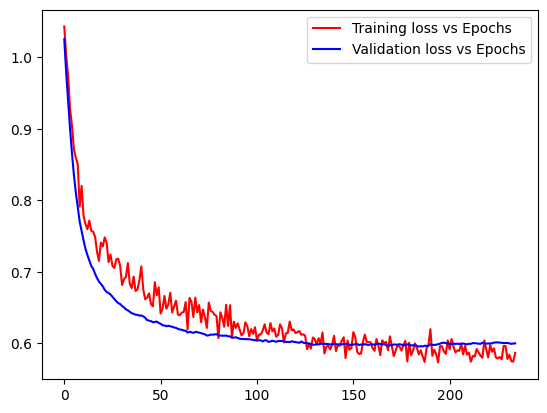

Final validation loss : 0.6, Final validation accuracy : 0.713


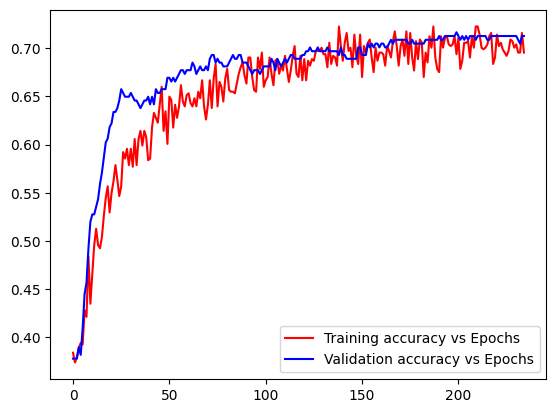

Final validation loss : 0.6, Final validation accuracy : 0.713


In [101]:
sale_cl_history = resultscl.history
fig, ax = plt.subplots()
ax.plot(sale_cl_history['loss'], 'r', label='Training loss vs Epochs')
ax.plot(sale_cl_history['val_loss'], 'b', label='Validation loss vs Epochs')
# plt.ylim([0.2, 1.3])
ax.legend()
plt.show()
print("Final validation loss : {}, Final validation accuracy : {}"\
      .format(round(sale_cl_history['val_loss'][-1],3), round(sale_cl_history['val_accuracy'][-1],3)))
fig, ax = plt.subplots()
ax.plot(sale_cl_history['accuracy'], 'r', label='Training accuracy vs Epochs')
ax.plot(sale_cl_history['val_accuracy'], 'b', label='Validation accuracy vs Epochs')
ax.legend()
plt.show()
print("Final validation loss : {}, Final validation accuracy : {}"\
      .format(round(sale_cl_history['val_loss'][-1],3), round(sale_cl_history['val_accuracy'][-1],3)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 1ms/step
0.6082447498055484
None


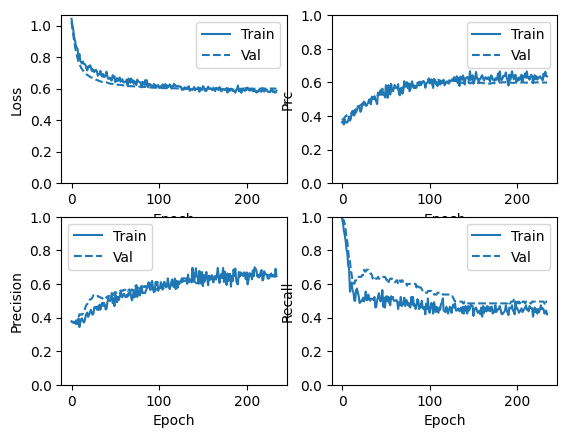

In [102]:
probcl = modelcl.predict(X_testcl)
print(roc_auc_score(Y_testcl, probcl))
print(plot_metrics(resultscl))
plt.show()


[[97 36]
 [33 25]]
6/6 [==============================] - 0s 998us/step
Legitimate Transactions Detected (True Negatives):  85
Legitimate Transactions Incorrectly Detected (False Positives):  48
Fraudulent Transactions Missed (False Negatives):  28
Fraudulent Transactions Detected (True Positives):  30
Total Fraudulent Transactions:  58


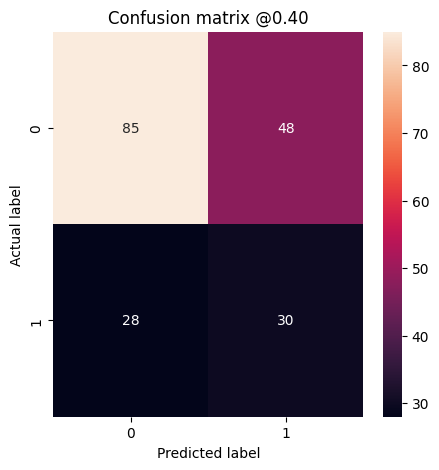

In [105]:
# confusion_matrix(Y_valcc_f, pred)
pd.value_counts(Y_testcl)
predcl = [1 if x[0] > 0.45 else 0 for x in probcl]
print(confusion_matrix(Y_testcl, predcl))
plot_cm(Y_testcl, modelcl.predict(X_testcl), p=0.40)
# plt.savefig('cm_cl.png')
plt.show()

In [106]:
weighted_resultscl = modelcl.evaluate(X_testcl, Y_testcl, verbose=0)
for name, value in zip(modelcl.metrics_names, weighted_resultscl):
    print(name, ': ', value)
print()

loss :  0.6179413199424744
f1_loss :  0.6270069479942322
f1_weighted :  0.6270068287849426
tp :  20.0
fp :  27.0
tn :  106.0
fn :  38.0
accuracy :  0.6596858501434326
precision :  0.42553192377090454
recall :  0.3448275923728943
auc :  0.6081150770187378
prc :  0.4966103434562683
cohen_kappa :  -13.815510749816895
sfc :  0.08682802319526672



# Predictions on Target clients

In [270]:
target.fillna(0, inplace=True)

c:\users\python\python37\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [271]:
targetmf = target[featuresMF].fillna(0)
targetcc = target[featuresCC].fillna(0)
targetcl = target[featuresCL].fillna(0)

revfeaMF = [i for i in features_to_normalize if i in featuresMF]
revfeaCC = [i for i in features_to_normalize if i in featuresCC]
revfeaCL = [i for i in features_to_normalize if i in featuresCL]

targetmf[revfeaMF] = StandardScaler().fit_transform(targetmf[revfeaMF])
targetcc[revfeaCC] = StandardScaler().fit_transform(targetcc[revfeaCC])
targetcl[revfeaCL] = StandardScaler().fit_transform(targetcl[revfeaCL])


In [272]:
probtarmf = modelmf.predict(targetmf)
probtarcc = modelcc.predict(targetcc)
probtarcl = modelcl.predict(targetcl)

mftar = pd.DataFrame({'Client': target['Client'], 'bin': [1 if i >= 0.65 else 0 for i in probtarmf], 'prob': [i[0] for i in probtarmf]})
print(mftar['bin'].value_counts())
cctar = pd.DataFrame({'Client': target['Client'], 'bin': [1 if i >= 0.50 else 0 for i in probtarcc], 'prob': [i[0] for i in probtarcc]})
print(cctar['bin'].value_counts())
cltar = pd.DataFrame({'Client': target['Client'], 'bin': [1 if i >= 0.50 else 0 for i in probtarcl], 'prob': [i[0] for i in probtarcl]})
print(cltar['bin'].value_counts())

mftar.sort_values(by=['prob'], ascending=False).head(int(np.round(426*0.15))).head(30)
target.loc[:, 'Prob_MF'] = probtarmf
target.loc[:, 'Sale_MF'] = [1 if i >= 0.65 else 0 for i in probtarmf]


cctar.sort_values(by=['prob'], ascending=False).head(int(np.round(426*0.15))).head(30)
target.loc[:, 'Prob_CC'] = probtarcc
target.loc[:, 'Sale_CC'] = [1 if i >= 0.5 else 0 for i in probtarcc]


cltar.sort_values(by=['prob'], ascending=False).head(int(np.round(426*0.15))).head(30)
target.loc[:, 'Prob_CL'] = probtarcl
target.loc[:, 'Sale_CL'] = [1 if i >= 0.5 else 0 for i in probtarcl]

20/20 [==============================] - 0s 997us/step
1    426
0    210
Name: bin, dtype: int64
0    526
1    110
Name: bin, dtype: int64
0    473
1    163
Name: bin, dtype: int64


c:\users\python\python37\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\python\python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Cleaning the revenue data for quality 

In [274]:
# Filter out the non-zero Revenue statistics
Revenue_MF = train['Revenue_MF'][train['Revenue_MF']>0]
Revenue_CC = train['Revenue_CC'][train['Revenue_CC']>0]
Revenue_CL = train['Revenue_CL'][train['Revenue_CL']>0]

Text(0.5, 1.0, 'Revenue_MF of customers')

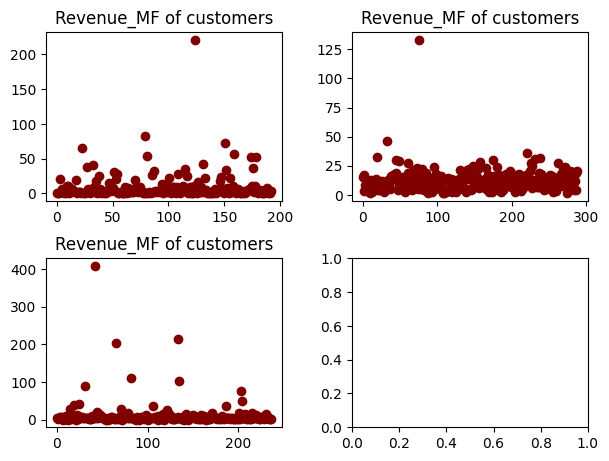

In [275]:
figure, axis = plt.subplots(2,2)
figure.tight_layout(pad=2.0)
axis[0,0].scatter(range(len(Revenue_MF)), Revenue_MF, color='maroon')
axis[0,0].set_title("Revenue_MF of customers")
axis[1,0].scatter(range(len(Revenue_CC)), Revenue_CC, color='maroon')
axis[1,0].set_title("Revenue_MF of customers")
axis[0,1].scatter(range(len(Revenue_CL)), Revenue_CL, color='maroon')
axis[0,1].set_title("Revenue_MF of customers")
# ax[0,0].ylabel('Revenue_MF'), plt.xlabel('Customers')

# plt.show()

### Removing outliers(IQR) and taking average 

In [278]:
def rem_outliers(data):
    # calculate interquartile range
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]

    # remove outliers
    outliers_removed = [x for x in data if x > lower and x < upper]
    return outliers_removed
Revenue_MF = rem_outliers(Revenue_MF)
Revenue_CC = rem_outliers(Revenue_CC)
Revenue_CL = rem_outliers(Revenue_CL)

Text(0.5, 1.0, 'Revenue_MF of customers')

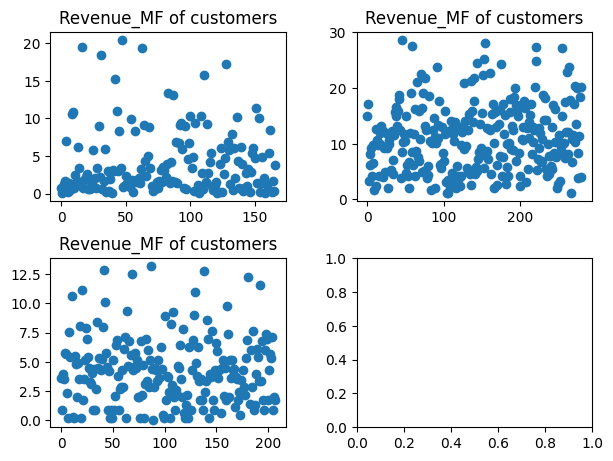

In [279]:
figure, axis = plt.subplots(2,2)
figure.tight_layout(pad=2.0)

axis[0,0].scatter(range(len(Revenue_MF)), Revenue_MF)
axis[0,0].set_title("Revenue_MF of customers")
axis[1,0].scatter(range(len(Revenue_CC)), Revenue_CC)
axis[1,0].set_title("Revenue_MF of customers")
axis[0,1].scatter(range(len(Revenue_CL)), Revenue_CL)
axis[0,1].set_title("Revenue_MF of customers")

# Revenue

In [281]:
mean_RevenuMF = np.mean(Revenue_MF)
mean_RevenuCC = np.mean(Revenue_CC)
mean_RevenuCL = np.mean(Revenue_CL)

target.loc[:,'Revenue_MF'] = mean_RevenuMF
target.loc[:, 'Revenue_CC'] = mean_RevenuCC
target.loc[:, 'Revenue_CL'] = mean_RevenuCL

c:\users\python\python37\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [394]:
pot_client = target[['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL',
                     'Prob_MF', 'Prob_CC', 'Prob_CL',
                     'Revenue_MF', 'Revenue_CC', 'Revenue_CL']]


# Adjusted Revenue Based on the Heuristic proccess    
$$
M = *maximize* \sum_{j=1}^n\left[\left(P_j-C_j\right) u_j-f_j\right]
$$<br>

    1: For each product j, compute the average revenue Pj and the average cost Cj
    2: Solve the resulting integer-programming formulation (M)
    3: Sort products such that for two products j and k, j < k if and only if Pjuj ≥ Pkuk
    4: For each product j, sort clients such that for two clients i and l, i < l if and only if pij ≥ plj
    5: consider the products following the order obtained in line 3; offer each product j to the first uj active clients
    in the sequence given by line 4
    6: keep this solution if it is feasible and if its total profit is greater than 0; otherwise, output the trivial solution
       

In [304]:
summf = pot_client['Sale_MF'].sum(axis=0)
sumcc = pot_client['Sale_CC'].sum(axis=0)
sumcl = pot_client['Sale_CL'].sum(axis=0)

In [305]:
pot_client['adj_revMF'] = pot_client['Revenue_MF'] *  pot_client['Prob_MF'] * pot_client['Sale_MF']
pot_client['adj_revCC'] = pot_client['Revenue_CC'] *  pot_client['Prob_CC'] * pot_client['Sale_CC']
pot_client['adj_revCL'] = pot_client['Revenue_CL'] *  pot_client['Prob_CL'] * pot_client['Sale_CL']

c:\users\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [306]:
pot_client



,Client,Sale_MF,Sale_CC,Sale_CL,Prob_MF,Prob_CC,Prob_CL,Revenue_MF,Revenue_CC,Revenue_CL,adj_revMF,adj_revCC,adj_revCL
2,545,0,1,1,0.643817,0.608426,0.809086,4.025552,4.249449,11.040906,0.000000,2.585476,8.933046
3,667,0,0,0,0.492643,0.432526,0.287714,4.025552,4.249449,11.040906,0.000000,0.000000,0.000000
5,1360,1,0,1,0.712026,0.362775,0.717777,4.025552,4.249449,11.040906,2.866299,0.000000,7.924904
6,267,0,0,0,0.635948,0.402611,0.242386,4.025552,4.249449,11.040906,0.000000,0.000000,0.000000
8,1420,1,0,0,0.738792,0.370993,0.238184,4.025552,4.249449,11.040906,2.974044,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,655,1,0,0,0.781670,0.295721,0.396564,4.025552,4.249449,11.040906,3.146652,0.000000,0.000000
1577,1569,1,1,1,0.998227,0.544156,0.600425,4.025552,4.249449,11.040906,4.018416,2.312364,6.629237
1578,1494,0,0,0,0.422471,0.335869,0.262363,4.025552,4.249449,11.040906,0.000000,0.000000,0.000000
1580,1503,0,0,0,0.603633,0.432858,0.291977,4.025552,4.249449,11.040906,0.000000,0.000000,0.000000


## Saving the top clients for each product

In [315]:
pot_client[pot_client['Sale_MF'] == 1][['Client', 'Prob_MF']].sort_values('Prob_MF', ascending=False).to_csv('clients_propensity_MF.csv', header=True, index=False)
pot_client[pot_client['Sale_CC'] == 1][['Client', 'Prob_CC']].sort_values('Prob_CC', ascending=False).to_csv('clients_propensity_CC.csv', header=True, index=False)
pot_client[pot_client['Sale_CL'] == 1][['Client', 'Prob_CL']].sort_values('Prob_CL', ascending=False).to_csv('clients_propensity_CL.csv', header=True, index=False)

## Targeting Strategy
 - Since there is condition to contact a customer only once, we strike with the offer which has maximum estimated revenue among  adjusted revenues from the three products.
 - We sort the clients based on the best maximum revenue and choose 15 pct out of all targets or 100 clients.

In [393]:
pot_client.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Prob_MF,Prob_CC,Prob_CL,Revenue_MF,Revenue_CC,Revenue_CL,adj_revMF,adj_revCC,adj_revCL,Best_Revenue,Best_Offer
2,545,0,1,1,0.643817,0.608426,0.809086,4.025552,4.249449,11.040906,0.000000,2.585476,8.933046,8.933046,Consumer Loan
3,667,0,0,0,0.492643,0.432526,0.287714,4.025552,4.249449,11.040906,0.000000,0.000000,0.000000,0.000000,Not Potential
5,1360,1,0,1,0.712026,0.362775,0.717777,4.025552,4.249449,11.040906,2.866299,0.000000,7.924904,7.924904,Consumer Loan
6,267,0,0,0,0.635948,0.402611,0.242386,4.025552,4.249449,11.040906,0.000000,0.000000,0.000000,0.000000,Not Potential
8,1420,1,0,0,0.738792,0.370993,0.238184,4.025552,4.249449,11.040906,2.974044,0.000000,0.000000,2.974044,Mutual Fund


In [341]:
def maximize_revenue(rown):
    if rown['adj_revMF'] > rown['adj_revCC'] and rown['adj_revMF'] > rown['adj_revCL']:    # Best offer for this customer is MF
        res1 = [rown['adj_revMF'], 'Mutual Fund']
    elif rown['adj_revCC'] > rown['adj_revMF'] and rown['adj_revCC'] > rown['adj_revCL']:  # Best offer for this customer is CC
        res1 = [rown['adj_revCC'], 'Credit Card']
    elif rown['adj_revCL'] > rown['adj_revMF'] and rown['adj_revCL'] > rown['adj_revCC']:  # Best offer for this customer is CL
        res1 = [rown['adj_revCL'], 'Consumer Loan']
    else:
        res1 = [0, 'Not Potential']
    return res1

In [342]:
pot_client.loc[:, 'Best_Revenue'] = pot_client.apply(lambda row:maximize_revenue(row)[0], axis=1)
pot_client.loc[:, 'Best_Offer'] = pot_client.apply(lambda row:maximize_revenue(row)[1], axis=1)

c:\users\python\python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [364]:
# Removing the "Not Potential" Clients to obtain final output
output = pot_client[pot_client['Best_Revenue'] != 0][['Client','Best_Revenue', 'Best_Offer']]


In [367]:
output.to_csv('client_offer_target.csv', index=False)
output.head()

,Client,Best_Revenue,Best_Offer
2,545,8.933046,Consumer Loan
5,1360,7.924904,Consumer Loan
8,1420,2.974044,Mutual Fund
9,1024,2.772493,Mutual Fund
11,119,7.151151,Consumer Loan
...,...,...,...
1565,237,3.029696,Mutual Fund
1569,750,6.221204,Consumer Loan
1574,655,3.146652,Mutual Fund
1577,1569,6.629237,Consumer Loan


# Marketing Target
    - There are 104 clients out of 636 clinets who are not potential targets of any products
    - There are total of 532 potential customers
    - 313 clients to target with Mutual Funds
    - 163 clinets to target with Consumer Loans
    - 56 Clinets to target with Credit card

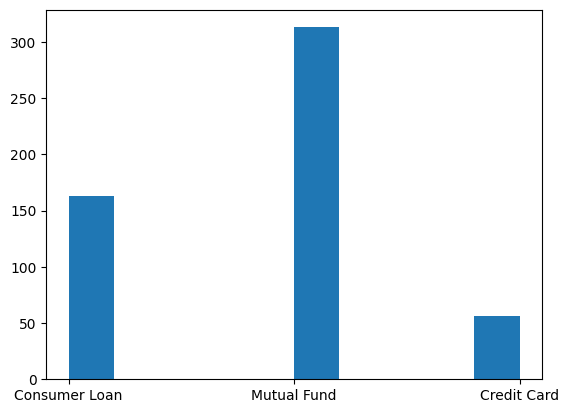

104

In [387]:
plt.hist(output['Best_Offer'], label=True)
plt.show()


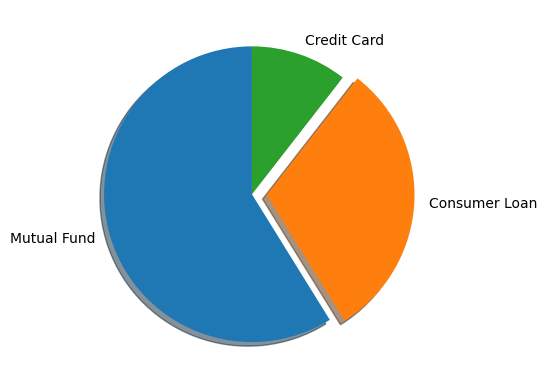

In [403]:
values = np.array(output['Best_Offer'].value_counts())
labels = ['Mutual Fund', 'Consumer Loan', 'Credit Card']
myexplode = [0, 0.1, 0, ]
plt.pie(values, labels = labels, startangle = 90, explode = myexplode, shadow = True)
plt.show() 

## Estimated Total Revenue

In [362]:
# Sum of all the estimated revenues from the top clients with high propensities.
output.sort_values('Best_Revenue', ascending=False).head(100)['Best_Revenue'].sum()

783.9254801683727

# Estimating Revenue from previous Campaign
    - The Revenue from previous setting is estimated in the same way using the "Sales_Revenues" table data. 
    - Comparing the previous Estimated revenue with the obtained revenue from heuristic process.
    - The current Estimated Revenues is 783.9 ~ 784
        - Revenue from previous setting(existing data) is 740
    - Shows that they both match with each other.

## Previous Total Revenue

In [456]:
sales_rev['Revenue_MF'].head(100).sum() + sales_rev['Revenue_CC'].head(100).sum() + sales_rev['Revenue_CL'].head(100).sum()

740.0225

# Conclusion

The aim of this study is to study and estimate the propensities of the customers who are not the targets before thereby providng the right marketing strategy fo those clients with higher propensities and achieve maximum revenue out of expenditures.
<br><br>
Over-sampling, Under-sampling and mixture of both (Combine) are used to get most important feature among useless features. But these techniques failed to show significant results in the simple models like Logistic regression and XGBoost. Even though ANN are prone to over fitting and difficult to work with large number of hyperparameters, gave best results compared to other models. Thanks to cost sensitive learning and class weighting technique that gave good results when used with ANN. Even though the final accuracies are low, the f1-scores and recall of the models are quite satisfactory to rely upon and plan marketing strategies.

The Final revenues are estimated based on the Heuristic process gave very good result when compared with the revenues from the existing sales data. The final best revenues and target offers are saved to the project folder as follows:<br>
- 'client_offer_target.csv'   : Total target Clients who whith high propensities to buy at least 1 product<br>
- 'clients_propensity_CC.csv' : High potential top 100 target clients for the Credit Card product<br>
- 'clients_propensity_CL.csv' : High potential top 100 target clients for the Consumer Loan product<br>
- 'clients_propensity_MF.csv' : High potential top 100 target clients for the Mutual Funds product<br><br>
    **Final Expected Revenues based on this strategy is 784**.<br><br>